# Agent-Augmented Portfolio Construction

This case study shows how traditional portfolio construction techniques can be augmented with agentic systems to produce highly customized, client-specific portfolios at scale. The agent-enhanced process combines traditional fundamental factor models, agentic sustainability scoring, and agentic fundamental screening to create a bespoke equity portfolio.

### Task Scope

A wealth manager is asked to build a custom, separately managed account (SMA) for a high-net-worth client. The client requests:

- A portfolio of US companies drawn from the S&P 500
- A dividend yield at least 20% higher than the S&P 500
- A beta between 0.8 and 1.2
- Sustainability considerations - adoption of innovative sustainable technology
- Benchmark: S&P Global Dividend Aristocrats Index

## Install Dependencies

In [ ]:
pip install --upgrade yfinance pandas numpy tqdm pip lxml

## Step 1: Define the Universe and Extract Data

The base universe is the **S&P 500.** Data will be extracted for each company, including:

- **Dividend Yield**
- **Payout Ratio** (as a proxy for dividend sustainability)
- **3-Year Dividend Growth CAGR**
- **Price History** (for factor and beta calculations)
- **Sector Classification**

To maintain the open source nature of the project we are using Yahoo Finance data. However, Yahoo Finance data can be inconsistent leading to data cleanliness issues. This tutorial is intended to show how you might construct a portfolio using screening agents. Its purpose is not to produce a production ready tool and should not be used for anything other than educational or information purposes. 

### Import S&P 500 Constituents and Pull Data


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def get_sp500_constituents() -> pd.DataFrame:
    """
    Return a DataFrame with the current S&P 500 ticker symbols, company names,
    GICS Sector and GICS Sub-Industry.
    """
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    df = pd.read_html(url, header=0)[0]
    df.rename(columns={"Symbol": "Ticker"}, inplace=True)
    df["Ticker"] = df["Ticker"].str.replace(".", "-", regex=False)
    return df[["Ticker","Security", "GICS Sector", "GICS Sub-Industry"]]

def get_dividend_metrics(ticker: str, years: int = 3) -> pd.Series:
    """
    Fetch dividend-related metrics for a single ticker.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (Yahoo format).
    years : int, default 3
        Number of years for Dividend CAGR calculation.

    Returns
    -------
    pd.Series
        DividendYield, PayoutRatio, DivCAGR_<years>y
    """
    t = yf.Ticker(ticker)

    # --- Dividend Yield & Payout Ratio ---
    info = t.info
    div_yield = info.get("dividendYield", np.nan)
    payout    = info.get("payoutRatio", np.nan)

    # --- Dividend CAGR ---
    divs = t.dividends.copy()
    div_cagr = np.nan
    if not divs.empty:
        divs.index = divs.index.tz_localize(None)
        now = datetime.now()
        past_cutoff = now - timedelta(days=365*years)

        # sum of last 12 months
        recent = divs[divs.index >= now - timedelta(days=365)].sum()
        # sum of that same 12-month window X years ago
        past   = divs[(divs.index >= past_cutoff - timedelta(days=365)) &
                      (divs.index <  past_cutoff)].sum()
        if past > 0 and recent > 0:
            div_cagr = (recent / past) ** (1/years) - 1

    return pd.Series({
        "DividendYield": div_yield,
        "PayoutRatio": payout,
        f"DivCAGR_{years}y": div_cagr,
    }, name=ticker)


def get_return_series(ticker: str, years: int = 3, interval: str = "1d") -> pd.Series:
    """
    Fetch daily return series for the last `years` years.

    Returns a pandas Series of percentage changes.
    """
    t = yf.Ticker(ticker)
    hist = t.history(period=f"{years}y", interval=interval)["Close"]
    if hist.empty:
        return pd.Series(dtype=float, name=ticker)
    rets = hist.pct_change().dropna()
    rets.name = ticker
    return rets


def get_metrics_and_returns(tickers: list[str], years: int = 3) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Get dividend metrics and return series for multiple tickers.

    Returns
    -------
    metrics_df : DataFrame
        DividendYield, PayoutRatio, DivCAGR_<years>y
    returns_df : DataFrame
        Daily return series for each ticker
    """
    metrics = []
    rets_list = []

    for tk in tickers:
        print(f"Fetching {tk}...")
        metrics.append(get_dividend_metrics(tk, years))
        rets_list.append(get_return_series(tk, years))

    metrics_df = pd.DataFrame(metrics).set_index("Ticker", drop=False) if not isinstance(metrics[0], pd.Series) else pd.DataFrame(metrics)
    returns_df = pd.concat(rets_list, axis=1)

    return metrics_df, returns_df

In [ ]:
constituents = get_sp500_constituents()
metrics_df, returns_df = get_metrics_and_returns(constituents.Ticker)

### Save Data

In [187]:
metrics_df.to_csv('metrics_df.csv')
returns_df.to_csv('returns_df.csv')
constituents.to_csv('SP_constitutents.csv')

## Step 2: Factor Construction 

We use a decile spread methodology to contruct three dividend factors, comprising dividend yield, payout ratio, and dividend growth rate (3-year CAGR). The methodology includes taking the returns of companies in the top decile of the given factor, and subtracting the returns of companies in the bottom decile of the factor.

Each factor is regressed on the returns of each company creating beta values representing the exposrure to each factor. 

Given we want to rank high for each factor we use a rank methodology to score each company for a given factor (i.e. the highest factor is ranked 1 and the lowest factor is ranked 100).

These scores are summed to create a **composite dividend factor score**, and the top 100 companies are selected.

### Build the Factors

In [162]:
def construct_factor(metric:str,metrics_df:pd.DataFrame,returns_df:pd.DataFrame,cuttoff_percentile:float=.1) -> pd.Series:
    """A function to construct factors from metrics from constituents of an index
    Args:
        metric (str): the metric to base the factor
        metrics_df (pd.DataFrame): the dataframe housing the financial metrics of index constituents
        returns_df (pd.DataFrame): the dataframe housing the return series for the index constituents
        cutoff_percentile (float): the percent to include in the top and bottom n constituents. For example a value of .1 would be the top decile and bottom decile of non-na metric values.
    Returns:
        pd.Series: A series containing the final factor
        """
    # split the metrics by percentile highest and lowest
    top = metrics_df[metric].nlargest(round(len(metrics_df[metric].dropna())*cuttoff_percentile)).index
    bottom = metrics_df[metric].nsmallest(round(len(metrics_df[metric].dropna())*cuttoff_percentile)).index

    # obtain the return series for top and bottom 
    top_returns = returns_df.loc[:,top]
    top_returns['Average'] = top_returns.mean(axis=1)
    bottom_returns = returns_df.loc[:,bottom]
    bottom_returns['Average'] = bottom_returns.mean(axis=1)

    # construct the factor
    return_factor = top_returns['Average'] - bottom_returns['Average']
    return_factor.name = f'{metric}Factor'
    return return_factor


In [173]:
# create the dividend yield return factor
div_yield_return_factor = construct_factor('DividendYield',metrics_df,returns_df)

# create the payout return factor
payout_return_factor = construct_factor('PayoutRatio',metrics_df,returns_df)

# create the 3 year div growth factor
div_growth_return_factor = construct_factor('DivCAGR_3y',metrics_df,returns_df)

factors_df = pd.concat([div_yield_return_factor,payout_return_factor,div_growth_return_factor],axis=1)

### Save Factors

In [165]:
factors_df.to_csv('factors.csv')

### Beta Calculations and Top 100 Selection

In [175]:
from sklearn.linear_model import LinearRegression

factor_names = ['DividendYieldFactor','PayoutRatioFactor','DivCAGR_3yFactor']
stocks = returns_df.columns

betas = {}

for stock in stocks:
    try:
        stock_returns_df = returns_df[[stock]].dropna()
        combined = stock_returns_df.join(factors_df)
        y = combined[stock]
        X = combined[factor_names]
        model = LinearRegression().fit(X,y)
        betas[stock] = model.coef_
    except Exception as e:
        print(f'Error:{e} for {stock} with returns:{combined}')

betas_df = pd.DataFrame(betas,index=factor_names).T

### Save Betas

In [191]:
betas_df.to_csv('betas_df.csv')

## Stratify by Sector
We need to stratify our factor betas by sector in order to ensure we have a universe of stocks to pick from to meet our portfolio sector constraints.

In [ ]:
# Run this if your runtime reset and need to start from here.

import pandas as pd
returns_df = pd.read_csv('returns_df.csv',index_col=0,parse_dates=True)
factors_df = pd.read_csv('factors_df.csv',index_col=0,parse_dates=True)
betas_df = pd.read_csv('betas_df.csv',index_col=0,parse_dates=True)
metrics_df = pd.read_csv('metrics_df.csv',index_col=0)
constituents = pd.read_csv('SP_constitutents.csv',index_col=0)


In [ ]:
betas_ranked_df = betas_df.rank(ascending=False)
betas_ranked_df['CompositeScore'] = betas_ranked_df.sum(axis=1)
betas_ranked_df = betas_ranked_df.join(constituents.loc[:,['Ticker','GICS Sector']].set_index('Ticker'))


In [199]:
sector_weights = constituents.groupby('GICS Sector').agg(pct_SPY=('GICS Sector',lambda x: x.count()/len(constituents))).round(2)

In [ ]:
stratifieds = []
universe_count = 100

for sector in sector_weights.index:
    filter = betas_ranked_df['GICS Sector'] == sector
    sector_weight = sector_weights.at[sector,'pct_SPY']
    sector_universe_count = int(sector_weight * universe_count)
    sector_sample = betas_ranked_df[filter].nsmallest(sector_universe_count,'CompositeScore')
    stratifieds.append(sector_sample)

In [188]:
stratified_df = pd.concat(stratifieds)

In [189]:
stratified_df.groupby('GICS Sector').agg(pct_strat=('GICS Sector',lambda x: x.count()/len(stratified_df))).round(2).join(sector_weights.round(2))

,pct_strat,pct_SPY
GICS Sector,,
Communication Services,0.05,0.05
Consumer Discretionary,0.10,0.10
Consumer Staples,0.08,0.08
Energy,0.04,0.04
Financials,0.15,0.15
Health Care,0.12,0.12
Industrials,0.16,0.16
Information Technology,0.14,0.14
Materials,0.05,0.05


In [ ]:
len(stratified_df)

The final number of companies in the stratified_df will be near 100 due to rounding errors from S&P sector weights

### Save Stratified Universe

In [73]:
stratified_df.to_csv('stratified_universe.csv')

## Step 3: Run Agent-Based Sustainability Screen
The client requested a portfolio tilted towards companies that are adopting innovative sustainable technology. Thus we build a scoring system to give to the agent to ground its answer on for this request. Each of the top 100 companies is evaluated by the **Deep Research Sustainability Agentic Workflow**, which scores them on a 0–100 scale based on:

- Adoption of sustainable technology
- Innovation leadership
- Measurable impact
- Future strategy
- Industry position

The scores are normalized and added as a fourth factor in the composite rank.

### Build the prompt

In [74]:
prompt = """Research {company_name}'s adoption of innovative sustainable technologies and provide an overall score (0-100) based on the criteria below:

## RESEARCH AREAS:

1. **Key Technologies Adopted (25 points)**: What specific sustainable technologies (renewable energy, energy efficiency, carbon management, sustainable materials) has {company_name} implemented?

2. **Innovation Leadership (25 points)**: What cutting-edge sustainable technology initiatives, R&D projects, or partnerships is {company_name} pursuing?

3. **Measurable Impact (25 points)**: What quantifiable environmental and business impacts have resulted from their sustainable technology investments?

4. **Future Strategy (15 points)**: What are {company_name}'s documented commitments and roadmap for future sustainable technology adoption?

5. **Industry Position (10 points)**: How does {company_name} compare to competitors in sustainable technology leadership and adoption?

## SCORING CRITERIA (Total: 100 points):

**Technology Adoption (25 points):**
- 20-25: Multiple breakthrough technologies implemented at scale across operations
- 15-19: Several innovative technologies deployed with significant operational integration
- 10-14: Some sustainable technologies adopted but limited scope or innovation
- 5-9: Basic sustainable technology implementations, mostly conventional solutions
- 0-4: Minimal or no significant sustainable technology adoption

**Innovation Leadership (25 points):**
- 20-25: Leading industry with proprietary sustainable tech development, major R&D investments, breakthrough patents
- 15-19: Strong innovation program with partnerships, pilot projects, and emerging tech investments
- 10-14: Moderate innovation efforts, some R&D or partnerships in sustainable tech
- 5-9: Limited innovation activities, following industry trends rather than leading
- 0-4: No significant sustainable technology innovation or R&D

**Measurable Impact (25 points):**
- 20-25: Documented major environmental improvements (>50% emissions reduction, significant resource savings)
- 15-19: Strong measurable impact (25-50% improvements in key metrics)
- 10-14: Moderate documented impact (10-25% improvements)
- 5-9: Some measurable benefits but limited scope or impact
- 0-4: No clear quantifiable environmental or efficiency benefits

**Future Strategy (15 points):**
- 13-15: Comprehensive roadmap with specific targets, timelines, and major investments committed
- 10-12: Clear strategy with some specific commitments and targets
- 7-9: General sustainability commitments with limited specific tech focus
- 4-6: Vague future plans, minimal concrete commitments
- 0-3: No clear future sustainable technology strategy

**Industry Position (10 points):**
- 9-10: Industry leader, setting standards, widely recognized for sustainable tech leadership
- 7-8: Among top performers in industry sector
- 5-6: Average compared to industry peers
- 3-4: Below average, following rather than leading
- 0-2: Laggard in industry for sustainable technology adoption

## OUTPUT REQUIREMENTS:
- Provide detailed findings for each research area
- Give specific scores for each category with justification
- Calculate and present final overall score (0-100)
- Include recent examples (2022-2025), specific metrics, and credible sources
- Focus on innovation and leadership rather than basic compliance 

## FINAL ASSESSMENT FORMAT:
**SUSTAINABLE TECHNOLOGY ADOPTION SCORE: [X]/100**

Technology Adoption: [X]/25
Innovation Leadership: [X]/25  
Measurable Impact: [X]/25
Future Strategy: [X]/15
Industry Position: [X]/10

**Overall Assessment**: [Brief summary of company's sustainable tech position]"""

### Import the Research Agentic Workflow
We need to import the research workflow by appending its path to the system path for this notebook. This allows us to import all the functions of the workflow like it was a package. 

While we are using this research agentic workflow for sustainability purposes. It can be used to research any subject.

In [ ]:
import sys
import os


# Add research_agent to path
sys.path.insert(0, os.path.join(os.getcwd(), 'sustainability_research_workflow'))


### Extract The Score
We built the prompt to provide a score in the end in a specific format. This allows us to use regular expression to extract the score instead of making a seperate llm call to perform a stuctured outputs.

In [83]:
import re

def extract_score(text: str) -> int | None:
    match = re.search(r"SUSTAINABLE TECHNOLOGY ADOPTION SCORE:\s*(\d+)/100", text)
    if match:
        return int(match.group(1))
    return None

### Perform Sustainability Research
This saves all the reports in Agents/reports.

In [ ]:
from graph import graph

reports = {}

for tk in stratified_df.index:
    company_name = constituents.loc[constituents['Ticker']==tk,'Security'].values[0]
    formated_prompt = prompt.format(company_name=company_name)
    state = graph.invoke(
        {"messages": [{"role": "user", "content": formated_prompt}]},
    )
    report = state["messages"][-1].content
    with open(f'../../The-Automation-Ahead-Copy/Agents/reports/{tk}', 'w') as f:
        f.write(report)
    score = extract_score(report)
    reports[company_name] = {'report':report,'score':score}


### Sample report

In [22]:
from IPython.display import Markdown, display

# This will render markdown properly
display(Markdown(reports[list(reports.keys())[-1]]['report']))

Below is a focused, evidence-backed assessment of Vistra Corp.’s adoption of innovative sustainable technologies (2022–2025) and a scored evaluation against your criteria.

SUSTAINABLE TECHNOLOGY ADOPTION SCORE: 78/100

Technology Adoption: 21/25  
Innovation Leadership: 17/25  
Measurable Impact: 18/25  
Future Strategy: 14/15  
Industry Position: 8/10

Findings and justification (by research area)

Technology Adoption (21/25) — What specific sustainable technologies has Vistra implemented?
- Battery energy storage systems (BESS) at scale: Vistra owns and expanded the Moss Landing Energy Storage Facility (phases totaling up to 750 MW / 3,000 MWh after a 350 MW / 1,400 MWh expansion completed in mid‑2023) and brought online other large systems (e.g., DeCordova 260 MW / 260 MWh in Texas). These projects are used for energy arbitrage, ancillary services and resource adequacy in CAISO/ERCOT/MISO markets [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF7mOh2jrNGa-Ah2ZLRbEesSaxN-jfvDrbiSmtjZupgU_9-jFu4L1bOzj_FyWKC7JoWgcsPJrWX1-Niv8-Y-QP6cRrI3sibydRGyV4zbTitxQWxpK6DTEOEzzob4AwmRScAfZ4DIEho4XV71QImU2eHIBq5y-OV9wHwdbO16LjLpr5egdOlssmXwUAi4uggav8gW5WtSvM2b0sB5mz1MsQSO4jc2CfL1aNSuCQHz3b8Z1P9) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxutFbVtYXgaDd33S2Y4psVTFf2pgXZ37Z4Fjne8OE_i3ItyD-8MFu-pR3Mx05EG0S9jfwsi60JL6Mj81hIUas_lqk4Nw9SFJJMa4scr3sLlM6Q6rFm8GFfFNnXcExSCg71O7vGf2tLj8gaFHiHnyaagSX4f0Bsk2RIGnSphtNx7Ia65wZIKEZNix-4T2k6UVEG_IF0NjtFNyVG4q9pr91VXBfQzur62hdpqNCvDuGWJ0zAIGCQT728w_BjBkegxo=) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHQKVk1fGFLZei4VqJe9FGQjo-W15G_6hz9nlu30AqoYG1Alk7mH6oLz1CRc7r488iQk_IDxVvL5tO7WY6OBQysWRc6pXRmp1cwIl__uxa5lh8b0AAAn7nO0n6WmMCWC2BmGGPUaTssibGPYHx-QtAlZW_TFKZs9beHV6Inz98E5AH4N-WzgerMWoIF3Baz8HGwczDTQpXgtuxLy6Zdg1Qe99dXoA==) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEBbrIS_BI2kr0r0lspd-uMiQHQpzA1lhFCP4NtgwbiKfby9j1HcDclUjt1NEhr6AmcQPvCLDGOoRbTGmbnXs-cPE6t27ju69J9Nj1AwM5-fGotQaPEUyosAc_xYE7dOOhhPtpyOg_-hFKGg9wF-VyBTbpI20DWcxPcIzL71w997pXrZ3qi8Ik08UJ3aj8OgY_mxr9uzco0G79G) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHJJQEkWxUQFNGwtXvAtLp26b_VyUU2nLeb9kf9jkKsffuHejLy2jHTleN-UEwugDjUb5Cd9uhuvc-YVqPyJnIlbCTtV0VFb3R6H-8pnKfTUbzaZqnYN5krSl9iPuDeAYU6UMSL04EzpFP_) [westerneim](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEVMwVdw0vIKqk0Ql6gVoq5t0Ublx9DmZDvbb7YouH9ko0WCYRxHAm4NXZwlYV_gNQlme1rB2_RKJFlFbaj62-t8y4PAi7oIc39Im4gLKgDiuZBs5xPZ6rgVcdxe5cTFE-FhOtExQaG0QWgUOso6peUPRqD7CAdcN_UH1dv9lMMv_RAt6LhSnBcAGhonaYwweHWJ4ygvMry91Uvn44Xq7fCH7tJL3IW).
- Utility-scale solar and PV+storage deployments and PPAs: multiple new solar facilities (e.g., Brightside 50 MW, Emerald Grove 108 MW in Texas), redevelopment of former coal sites into solar + storage (Illinois “Retire and Renew”), and major corporate PPAs (Amazon ~200 MW in Texas; Microsoft ~405 MW in Illinois) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEDMNGsMg8SyEYfmz1dcsqD6JwHQCmDhg3QVXdPfkN5Nx_CsGeH3koRwKyDmC96yB-yEK1qpAwR0gR8yEtIsNwdOJ1nxiw0kbOEZEeT4io3gOk68alU9FNr5dYdCcWVQl9nioiqm0CsttI7dbOVYY5bMNhbHffLYd0Wkh4Z5Knv7on0XI-sjQfe9mBpC58l-WxNi0TMIiaWaZBKOEdiSFzkR79PGbWrQlp-38xejucRzk2nBH9YMyr3K_5UblwnQP4It9LWEUJG_5fLYRnvP8M=) [power-eng](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGRDWW9cr4BxtWUqbiUTZ0JEk0VepuE6UBnfNwgnYw-kgJvODBLeBtiNLO1iIafSnii92SvcrL4l6mZbXjOdWlgPBIUeucVmVN59RbLLouLaHe11AQ3yEQNbzdYQqIkbeYgVPnAPAqZs2vfI8NZNbuOi0UI7HbHxQlgDlZZDa-b8cnPxMkv1iees_R4SAh81w7q1l_uK6Gu_UB7te8JypRyrDZbiqJfPwrNl7KlU5-7RPdUH1pMe-s=) [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHmwZCpNTbD_6GEKdRype5mIkJFRmFqJl3RPVZH3tIHYnNFzIQ6FE68MYntCR84vQfL3_qQSYbuf6QAADAReJOtKsv1iuFaBphVaue0JQlew6L9jHoN_mqntsWRkFTm-RzuoFLg9TTEqW7WjkW0NQrqN77XM80xcQRhge0WpfX9VEkrSVgpukciCMsrtqI3KCvzncaHSoQCKz8zFoCD) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEZxEEzn3ovoY64z0MjeXJPWoSeQkfs7qhOgP-rprbAqA5waLDgs3qFKldGL_wjnUmTg-kXCDd4iVXm0np_UgfOvMze3iYQPi2QCa_6cvTRMWOO09QNggj2pKT2vIErcDh3iWPMLBLq5J3OmjjemJ7G5Rr-YAFI9kocV_bS9-lVwcruiitjefrb2g99PnMXFQ==).
- Nuclear (carbon‑free) capacity scaling via acquisition: 2023–2024 acquisition of Energy Harbor added ~4,000 MW of nuclear capacity to Vistra’s portfolio (immediately increasing zero‑carbon baseload) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxutFbVtYXgaDd33S2Y4psVTFf2pgXZ37Z4Fjne8OE_i3ItyD-8MFu-pR3Mx05EG0S9jfwsi60JL6Mj81hIUas_lqk4Nw9SFJJMa4scr3sLlM6Q6rFm8GFfFNnXcExSCg71O7vGf2tLj8gaFHiHnyaagSX4f0Bsk2RIGnSphtNx7Ia65wZIKEZNix-4T2k6UVEG_IF0NjtFNyVG4q9pr91VXBfQzur62hdpqNCvDuGWJ0zAIGCQT728w_BjBkegxo=) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEgMUrgl00WNnPQHY48logLQo4DnnKhF67tJFYz1t3nlLJRf-JNwSYGa5OqReoHGqZkqXArPxQXAzV2bf4PkfbKHXQOduyHmIing0s9YhOIsCdV7hvlIm36eVRV5MUJrpS3gpUjVKQO8NJQpT91JNYhkKw79855Bs5298FF9Tk=) [marketscreener](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRRSP68fetNPV6GssfA1X-UYJHlRNGzgrx0iObcXPIE1tJ3lH4neB3tvQ14oNzqObMRLokr9JPgeK6JOvhU9jeY2AFyTWgDaH-CRbIBd5KtNLGFqb8nXv__fWNUxtMkeSYHT3Z58q5XOes_Jy51CGyqJmBWcYiwH5EB9wl9uuZjGueLNtt95SgeCmR2JLULTIv).
- Fleet transitions and retirements: >12,000 MW of coal/gas retired to date with plans to retire ~7,500 MW more (and additional retirements planned through 2027), enabling a shift toward lower-carbon generation [txn20](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGShqh6rYD8oBM91sNqxsThFv9BcfOAdE1iRvccKxwf2gmxh8cbXrtp4WB3YIgk6dYDMgVeglNOKtVOCmQRo5tyeb9tNSpw7cwP0a2r1vjs1p-PZ2SWnxfNxM-zqwTk8BiK7-I8) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFhHdDRPRdvRzMMCgbTrzbOyqqKNBrcwFUHb7vCnMzdFVZxLf0u6D-BOyC7qh5eLC8upmCX2YwNj1sxRuVqve-62ytoK08B4NNF6gyFRAW4K4Iobm2OZ8ZwBFYLku2ywZU_PuIJWrh9WFjnVHDPmQdOAIlxP825w1o37Ipr7Oo=) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxxD0BIrwYxp_my4HvOU_WglGcNR1x_CoYsPzCFiVhR_2gGFkDMw_F5zicqSv0l0kkkXmtvl6I0MM9dqqwl6vN0BbWyKb-aOVxKwT04UKZccdWbuKXpzQK5D7IlsJcXoa9h0JmnE3l0hOYUELOiwOsSNQHh47LiWObSaom2_R-N6X77d1qEJzo8-tTEVcOfO-jK8ppT9Z1IYic1KqnAigrow==).
- Grid modernization and other measures: investments in grid modernization and EV charging infrastructure and customer-facing renewable plans (50+ retail renewable plans) [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGlVtgov_xAekTZZHqMbMdnaI97ZP5_OJgtxOHq9m1jd4v-7vjb0dDHMaTPN2X82HV6MzyOZ5h8v9UCLrkGXSTAktJ6SXfSw_75dRrgNzd7P4XF5bU027fxqAPldSfdh9l6_00KgBwE0NCw) [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG74RUOG5xN2L5wVz893ClzR-8U1cDrjmJMVRL0zovAPi61DvKHo0PeGgXh-qCTHpZdvpcjhAEYEAAImm1N7q80fXZZcG-DN7OUTX-At-nhxlA0GOUvHZxxFww2PZpvJDTJc4U12fw_wFnT-zA__Q7PPSofHgaqy0Fq1fKaONa1Wrt74Zic266-RxMbwkhCGVvr42VwFNh0F9CEsHHkfbErHJVAcXkD) [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGlVtgov_xAekTZZHqMbMdnaI97ZP5_OJgtxOHq9m1jd4v-7vjb0dDHMaTPN2X82HV6MzyOZ5h8v9UCLrkGXSTAktJ6SXfSw_75dRrgNzd7P4XF5bU027fxqAPldSfdh9l6_00KgBwE0NCw).

Why 21/25: Vistra has deployed multiple breakthrough technologies at commercial scale (largest-in-class BESS, substantial solar + BESS roll-outs, nuclear capacity acquisition). Points were reduced slightly for (a) continued material exposure to natural gas in the short term and (b) some project delays and operational setbacks (see risks below), which moderate the “at-scale” claim across the full 41 GW portfolio [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHlJz-kyaAFAjvbQx2NSkSg80g1tKSt5iOfOqZvR52dTI0pTFpxgjmUjOs6A2jjMt90G1928fysLkmNzo_tfwfc9uvk1cPXxoLpOE_ovNl4slhWyjwkU0Cr9OJ8XH0=) [seekingalpha](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHTuJEKiAKNtnsIFCk1UZO0_Fdx8YGUs-ed4UUVioF4LWSwbD7aptRKSnHBN5oc4kV0Z1MZPYCn9_TaO_4qMqXfsxyEK9pPT1M4BufKa6wDV8zK6vV7n27gCAon1P2kxXL_tGnVlCfoPNnjuuBioeqgNH7b8WoNymcxdDtOFDoyf93dpQDe2G2mFxLYn_IptGeIrjZkYzxrgSLZl6U=).

Innovation Leadership (17/25) — R&D, pilot projects, partnerships and “cutting-edge” initiatives
- Leadership signals: operating and expanding Moss Landing established Vistra as a leading BESS operator; Vistra is using BESS as grid services providers (arbitrage, frequency regulation, RA) rather than only behind‑the‑meter storage [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHQKVk1fGFLZei4VqJe9FGQjo-W15G_6hz9nlu30AqoYG1Alk7mH6oLz1CRc7r488iQk_IDxVvL5tO7WY6OBQysWRc6pXRmp1cwIl__uxa5lh8b0AAAn7nO0n6WmMCWC2BmGGPUaTssibGPYHx-QtAlZW_TFKZs9beHV6Inz98E5AH4N-WzgerMWoIF3Baz8HGwczDTQpXgtuxLy6Zdg1Qe99dXoA==) [westerneim](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEVMwVdw0vIKqk0Ql6gVoq5t0Ublx9DmZDvbb7YouH9ko0WCYRxHAm4NXZwlYV_gNQlme1rB2_RKJFlFbaj62-t8y4PAi7oIc39Im4gLKgDiuZBs5xPZ6rgVcdxe5cTFE-FhOtExQaG0QWgUOso6peUPRqD7CAdcN_UH1dv9lMMv_RAt6LhSnBcAGhonaYwweHWJ4ygvMry91Uvn44Xq7fCH7tJL3IW).
- Strategic partnerships and offtakes: long-term PPAs with hyperscalers (Amazon, Microsoft) underpin large new solar+storage projects and indicate commercial innovation in structuring large-scale clean energy deals [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHmwZCpNTbD_6GEKdRype5mIkJFRmFqJl3RPVZH3tIHYnNFzIQ6FE68MYntCR84vQfL3_qQSYbuf6QAADAReJOtKsv1iuFaBphVaue0JQlew6L9jHoN_mqntsWRkFTm-RzuoFLg9TTEqW7WjkW0NQrqN77XM80xcQRhge0WpfX9VEkrSVgpukciCMsrtqI3KCvzncaHSoQCKz8zFoCD) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEZxEEzn3ovoY64z0MjeXJPWoSeQkfs7qhOgP-rprbAqA5waLDgs3qFKldGL_wjnUmTg-kXCDd4iVXm0np_UgfOvMze3iYQPi2QCa_6cvTRMWOO09QNggj2pKT2vIErcDh3iWPMLBLq5J3OmjjemJ7G5Rr-YAFI9kocV_bS9-lVwcruiitjefrb2g99PnMXFQ==).
- Product & market innovation: redeveloping coal sites into PV+storage (Retire and Renew) and combining merchant nuclear, renewables and storage in the Vistra Zero strategy demonstrates business-model innovation [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEiZhkIKGXg_e2irkIgx29qagY0619hMSFAqmrxg317yjY7T1xA-g-qG5SMTSPaud5NEUASV8tK9GM7-gdhfb-2m5ygaTREouuNhqNOD5iy-6JKVK0cx-dIvzZhfyC48eSR3NLK-FXBzTLViqzQt1Md7BX8eckPQhNavWwag2H0AQuj8llJQ0oHP7zf5S4XQzajpIwjSLmhgbGxJoje1ERiDF1rizg7L9XR-ikztFMJfGsiqfq_8xr4C0XcC8VQrTEP5fZVgwgpcYYmf6YylCkbftODxDHh9U8CYMJsORngLZ7EpItgZWBZowqr5NMH) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGA26bE2iks8R1gCHClaZcQ7-Pwvq2mB5HoAmDfeoxoekd3qEg3kUAe3lINrSDHcRq2N55I7Rb2TzSWNxlS-3OMBwwZeN_GtC5iTyjlH-6KQIuDRLb54jUp2QQ6rbKh1LKkWnTtnHkajdaNxQWiz4P3VUQQ3e9CLK6UhkdhGNNwm4Mjf__yjNT2).
- Limits: there is little public evidence of proprietary breakthrough R&D, patents or major venture-style technology bets (e.g., hydrogen pilots, carbon capture projects with demonstrable deployments, or in‑house new battery chemistries) in 2022–2025. Vistra has signaled reliance on commercially mature BESS (NMC chemistry reported at Moss Landing) and on policy/market constructs to enable new tech adoption; hydrogen and CCS are noted as necessary future enablers but not yet deployed at scale by Vistra [fastcompany](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHHM82e1Jw-rlUN1QYXGsBMPe--yMEZNHESNa-W8U-4k2BbRSRIxx92aCdQrc_prhXYbNyFHuT7JVKpmRlFBwqEP8RFiz601w1oL7MXEiDc3G6v1iNA8HxHW3urvN35nYD8J2OAHr_HX2c5xDM34thxYGVptE1Jo8Ob1Y2U7QyuZ28uz2cdhPEU-eExsTADDCduBeAIAOsAOgjk62rap4A3Uu8NDgzwOAB22XmrNQU63_2qB29xh_Q=) [nsenergybusiness](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEc0Fw0-a2c_gOUioT_FMft4KsiL6CvHZw-bgeO2G-H5byJVLXSCrlRuolCoouuwX3USpMTvJ_9fFPwE-MRuDJ0TuoASR_I3ZIsOlQB1gYwAP6yRMUiMpIb8GfU4mnnp0q4z8Vbw2MtKtTuce8Gv2DgwqX-V6w8VYPnQNr37HkCtwhU1etuPVgh1PwLRHV3vvI1cXSrAF15CJR_RBOu7MP0XeT0rrEi3_2nXIs=).

Why 17/25: Vistra shows strong, pragmatic innovation through large-scale system integration (BESS, PV+storage, novel site reuse) and market-facing partnerships, but it is not clearly an R&D or patent-led technology originator. The lack of visible proprietary technology development and some safety/operational incidents restrain the score [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF7mOh2jrNGa-Ah2ZLRbEesSaxN-jfvDrbiSmtjZupgU_9-jFu4L1bOzj_FyWKC7JoWgcsPJrWX1-Niv8-Y-QP6cRrI3sibydRGyV4zbTitxQWxpK6DTEOEzzob4AwmRScAfZ4DIEho4XV71QImU2eHIBq5y-OV9wHwdbO16LjLpr5egdOlssmXwUAi4uggav8gW5WtSvM2b0sB5mz1MsQSO4jc2CfL1aNSuCQHz3b8Z1P9) [canarymedia](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFzGoJcAwydvL59hU9xaxnxCfj9o5J4WHDZonU3G7JB4tlH0MK56wJanqac8rVUwtoHttWCoATPLU1Vl8-TqFn06Bro04mJOLn8Ho0InXRTXscbQN84xcuW5DFd7cmNHp6p0SaejxG5YHf7WZqc4TPrb_ZUSbQujvpUtMJUdW5-rnrsLztLXAM9ujrNef5zIaHwwUHNvLJjJRC08pu1jRJdbm20dWNiAkUNaGaDdw==) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHQKVk1fGFLZei4VqJe9FGQjo-W15G_6hz9nlu30AqoYG1Alk7mH6oLz1CRc7r488iQk_IDxVvL5tO7WY6OBQysWRc6pXRmp1cwIl__uxa5lh8b0AAAn7nO0n6WmMCWC2BmGGPUaTssibGPYHx-QtAlZW_TFKZs9beHV6Inz98E5AH4N-WzgerMWoIF3Baz8HGwczDTQpXgtuxLy6Zdg1Qe99dXoA==).

Measurable Impact (18/25) — Quantifiable environmental and business impacts
- Emissions reductions and intensity improvements:
  - Vistra’s targets: 60% CO2e reduction by 2030 vs. 2010 baseline and net‑zero by 2050; near-term commitments include 58% absolute Scope 1 & 2 reduction by 2028 vs. 2018 [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGSYecxy5SMgX27VptEckLay1foesN935EImKPnVupjTTFa0c4W371PWOSnfBfJixuqw_Mxbcg_MGDMdxcIjuqT-5tUxq9P3RSh4qQqws7MQQzt9vzpQQ9MCSAY99z7BwGO) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEN70KanpUwJ4a4zoh6tJIwLZZ6LkvbtpICfxAUs-EPClstlLg4J-j2atdVjofv5zBzk-nmROMij1q02sC0QTjTmM90lKz-c5cWjcrMdmb9hxCixtWvd5TAADBLVC-leG-ULeynb_SL0dGKnj7NT4qYx__1LRo5djI_WvmeEzCfuDJPZBy-zhG-P7tVHrpHUC-luqDT492JKsCZylD9a1KYdg==) [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH8ylI6orcZX75Y2XIpL5Y3xGxLEeqCvw_k1y7lIUySunbumIG0nqShS22VGIRS3rSxwbsXyjYxWOXTF2ZpSA8n9UXdiERAe2qyv_F5PpP6ydywLn3mkbXtZV46DWXoVIoWPNpXeyE2JQD7ELwvLrw5rX8=).
  - Progress: Vistra reported a 9% year‑over‑year Scope 1 GHG reduction in 2023; a 45% decrease in CO2e from 2010 to 2020 (≈76% of its 2030 target already achieved by 2020), and carbon intensity improvements (e.g., forecasted 31% intensity improvement in 2024 after adding nuclear) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEiZhkIKGXg_e2irkIgx29qagY0619hMSFAqmrxg317yjY7T1xA-g-qG5SMTSPaud5NEUASV8tK9GM7-gdhfb-2m5ygaTREouuNhqNOD5iy-6JKVK0cx-dIvzZhfyC48eSR3NLK-FXBzTLViqzQt1Md7BX8eckPQhNavWwag2H0AQuj8llJQ0oHP7zf5S4XQzajpIwjSLmhgbGxJoje1ERiDF1rizg7L9XR-ikztFMJfGsiqfq_8xr4C0XcC8VQrTEP5fZVgwgpcYYmf6YylCkbftODxDHh9U8CYMJsORngLZ7EpItgZWBZowqr5NMH) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHH8TxljjY65F_CW64ZukfyVXDlqp-Bio8RJmHYxtjAiXPnRjitQYoZwQvXWAsQCE6uRuX4mqeU4qXrlo2j44K1cLuGy1jKqn4YlTgpo5GBUUVwWe8LnrvroSLaietLysTcY1qxpItZM_IOz3VX9-pHRnONLqBfMR8jNJehs6HSJ26XoEyA0tEERYvRlvZTjblj-fK4SEoO7OX4QdfFdG0UdyNI2wH5RjgjZWGJd8L-5cdzK5g3B4JrTHWx3VA1Fjt2rsY11OUV42-sNonFPioj_oJBapJZ_FQVoQ_wRnuDX68HSAoIyxl3Pt0ALls=) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE9SA1_rYG-R3PXvelPj4La0qvlMioxQe0-Cg5gI7e9KnXEQspU-uvKLxs94G3hxbbyPBsokQVrgvUs8ueAGBfpPRpaEtUe5WRLTzn0DCKYWyQRsGBCmmSzMN-P1aIzn_RRYv0EmTpTB3c1RMG3Dzwwe3iw6otDoY79JRPvsTNOtfDB-2kmAfZsv3g7K3wwOYQgAGuXJgFPf7v9iTS0Zv_mald7DkZ9UVegc2dqyGwrUpQ7xRp1qxpnqlmdFJ3yw-EHLt3qKCHO7U_JyxqpdPvQNPq9f9ncYvdFJKJlI0IOSYZAx5bBFK6XFfFeeUnE) [sec](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH2a18vJrNnopofFWL0vjJMqhy-iZNiJaCxV8FAh-DoUYMGCOywkJVzLNcmKssmxFfhKaEqxshW04ht_runwiFs0FUx-6Ghg7-22rdXxKGvZDH80hkmT1A8OGAB-c-QflO1FoPX_qasTqltD6MrH4n7PjNPcLPOSP26-VmHqIgpDJ2ewUphW7c59H8kiJYK6ew=).
- Fleet impacts: retirement of >12,000 MW of fossil generation (plus planned retirements ~4,600–7,500 MW) and rapid build-out of zero‑carbon projects (Vistra Zero: target ~7,300 MW by 2026) materially reduces system emissions and increases zero-carbon capacity [txn20](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGShqh6rYD8oBM91sNqxsThFv9BcfOAdE1iRvccKxwf2gmxh8cbXrtp4WB3YIgk6dYDMgVeglNOKtVOCmQRo5tyeb9tNSpw7cwP0a2r1vjs1p-PZ2SWnxfNxM-zqwTk8BiK7-I8) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH8ylI6orcZX75Y2XIpL5Y3xGxLEeqCvw_k1y7lIUySunbumIG0nqShS22VGIRS3rSxwbsXyjYxWOXTF2ZpSA8n9UXdiERAe2qyv_F5PpP6ydywLn3mkbXtZV46DWXoVIoWPNpXeyE2JQD7ELwvLrw5rX8=) [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH8ylI6orcZX75Y2XIpL5Y3xGxLEeqCvw_k1y7lIUySunbumIG0nqShS22VGIRS3rSxwbsXyjYxWOXTF2ZpSA8n9UXdiERAe2qyv_F5PpP6ydywLn3mkbXtZV46DWXoVIoWPNpXeyE2JQD7ELwvLrw5rX8=) [renewableenergyworld](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFNwHvDtJB83Dhe_-ssT28bL-J1rNbOzAAyBZrCepjJjzXfLtSokCXijzukv8xxMcsa1I7-nEurWQlfLNg06gr_B5-jTzUaTeh8wg8Rn9Fytr_-MbsSzC7fkqThLjfmdmk4hXGdx-brNnHKqIjCqTHeR3m-b8TwgJDGkWW0X-5CEadsQYwBhrdiBd-hjZspY2uIosU=).
- Business/financial impacts: committed capital deployment (~$5B into renewables over the coming years; investment guidance ~$2.27B in 2025) and PPAs with major customers support revenue diversification and EBITDA from renewables (Vistra expects renewables/storage to contribute meaningfully to EBITDA by 2030) [txn20](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGShqh6rYD8oBM91sNqxsThFv9BcfOAdE1iRvccKxwf2gmxh8cbXrtp4WB3YIgk6dYDMgVeglNOKtVOCmQRo5tyeb9tNSpw7cwP0a2r1vjs1p-PZ2SWnxfNxM-zqwTk8BiK7-I8) [nasdaq](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEeyNyfYe-tuBAG55YWngGOwmlEn7h_mI8KKBHJgthZGT5SvO3OOawzYZsOxOEu0EnD6I7Gbq0AR3TgmEk5wQMgFQFrPyOfSXueRq4QZwhOoLyTDrm-J9c1e57qq7eAyyZSP9Mf79vBB0zy_4xETvCfKcq8mlNwUeDPAvErOUtfRFJCXzheVo37ok-o_I8XGLPFvA==) [vistraenergy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH9kuHGf2RddsY3QGn_TcWGDy9pOiEQOA0lffBVT6WA7VmAlbmRln5lIh6ONjH_sz9Cauy8rLSJ-B0rDLfhZQsvU395_KZ2LuEXZxf3qAVBT74BpPwkkemv0zcmhKQdduCSNav9zcR31xTlNWJ3pgeCLp4wVvA5KKyMkNrKFEiC7KmR3hubwNEgej1weQ==).
- Limitations and adverse impacts: operational incidents at Moss Landing (overheating events, and a reported fire/evacuation and subsequent impaired asset write‑off of ~US$400M in early 2025) and supply‑chain delays have reduced availability and created financial/operational setbacks that offset some environmental gains in the short term [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGPtqHSuxyVxtf6d17FbJ73P86VTdqTrfk3FAPC6mCXiKqGTCzjRzwXv-LE4PQNyuB7cUkcAs4Rz_BZQYguIucklsLFAuXloocm0GnzmiXLzmduqcl2hKmSL47kVRSTVU8p5SDgtn-_0o1dJQ5Dt27vJzxIP5A65eeOJoLa8AWv2TE9jTyZLJ-mT1hQql9Jw2V2bAD4_osZedWEwztNtL7eHDsO5g==) [canarymedia](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFzGoJcAwydvL59hU9xaxnxCfj9o5J4WHDZonU3G7JB4tlH0MK56wJanqac8rVUwtoHttWCoATPLU1Vl8-TqFn06Bro04mJOLn8Ho0InXRTXscbQN84xcuW5DFd7cmNHp6p0SaejxG5YHf7WZqc4TPrb_ZUSbQujvpUtMJUdW5-rnrsLztLXAM9ujrNef5zIaHwwUHNvLJjJRC08pu1jRJdbm20dWNiAkUNaGaDdw==) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEVl8dje8_3lCfIYs8PCkjDaEgJWE5vJzHlfzOeY5C752jHDDxOwiVPnI_nW4_GjcOSzijeIR83s_7izNcTpmGIRb9AEUcVkDrMnG3ugLmNr3RyffgFjdvzAnoxyg9asOx9cApXuO641QU8fmjHg5Ce_VFFmVeNXb0GIahoEJeZpVrHg6DJnPPv43w8jvZ3oE1-l8-E) [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE4cReBWCRGceimWChvOQ3XsT0WJgTSinvs3mfdam46DQhgwdZ23ljNQhJOA9apqO5kFIgRH2ZbAUu8BDa_9aPnq4WwZqXZcXvv3rTcF3OuR7LM71OP-ZVdg_ftLkZrV-xN7N0DnbqdQrTfexKcF9BgaKEE8DQf6n0J83z0bcnV29pMu2xpOfQk5UxZfQ-oQr4xcC1dS1GXY6zTkGGcFnY=).

Why 18/25: Vistra demonstrates strong, documented emissions reductions and capacity transitions in measurable terms (many tens of percent in key metrics and clear generation retirements/zero‑carbon additions). The score is not higher because the company’s large operational incidents, remaining fossil capacity (natural gas still a large share in 2025) and some project delays reduce the net realized impact to date versus targets [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFhHdDRPRdvRzMMCgbTrzbOyqqKNBrcwFUHb7vCnMzdFVZxLf0u6D-BOyC7qh5eLC8upmCX2YwNj1sxRuVqve-62ytoK08B4NNF6gyFRAW4K4Iobm2OZ8ZwBFYLku2ywZU_PuIJWrh9WFjnVHDPmQdOAIlxP825w1o37Ipr7Oo=) [seekingalpha](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHTuJEKiAKNtnsIFCk1UZO0_Fdx8YGUs-ed4UUVioF4LWSwbD7aptRKSnHBN5oc4kV0Z1MZPYCn9_TaO_4qMqXfsxyEK9pPT1M4BufKa6wDV8zK6vV7n27gCAon1P2kxXL_tGnVlCfoPNnjuuBioeqgNH7b8WoNymcxdDtOFDoyf93dpQDe2G2mFxLYn_IptGeIrjZkYzxrgSLZl6U=) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGPtqHSuxyVxtf6d17FbJ73P86VTdqTrfk3FAPC6mCXiKqGTCzjRzwXv-LE4PQNyuB7cUkcAs4Rz_BZQYguIucklsLFAuXloocm0GnzmiXLzmduqcl2hKmSL47kVRSTVU8p5SDgtn-_0o1dJQ5Dt27vJzxIP5A65eeOJoLa8AWv2TE9jTyZLJ-mT1hQql9Jw2V2bAD4_osZedWEwztNtL7eHDsO5g==).

Future Strategy (14/15) — Commitments, roadmap and timelines
- Clear multi-decade commitments and near-term targets: net‑zero by 2050; 60% CO2e reduction by 2030 (2010 baseline); 58% absolute Scope 1 & 2 reduction by 2028 (2018 baseline) — public, time‑bound targets [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGSYecxy5SMgX27VptEckLay1foesN935EImKPnVupjTTFa0c4W371PWOSnfBfJixuqw_Mxbcg_MGDMdxcIjuqT-5tUxq9P3RSh4qQqws7MQQzt9vzpQQ9MCSAY99z7BwGO) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEN70KanpUwJ4a4zoh6tJIwLZZ6LkvbtpICfxAUs-EPClstlLg4J-j2atdVjofv5zBzk-nmROMij1q02sC0QTjTmM90lKz-c5cWjcrMdmb9hxCixtWvd5TAADBLVC-leG-ULeynb_SL0dGKnj7NT4qYx__1LRo5djI_WvmeEzCfuDJPZBy-zhG-P7tVHrpHUC-luqDT492JKsCZylD9a1KYdg==) [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH8ylI6orcZX75Y2XIpL5Y3xGxLEeqCvw_k1y7lIUySunbumIG0nqShS22VGIRS3rSxwbsXyjYxWOXTF2ZpSA8n9UXdiERAe2qyv_F5PpP6ydywLn3mkbXtZV46DWXoVIoWPNpXeyE2JQD7ELwvLrw5rX8=).
- Financing and programmatic commitments: Vistra Zero portfolio growth targets (7,300 MW by 2026), $5B expected renewables spend, specific capital guidance for 2025, Vistra’s Green Finance Framework, and a clear strategy to redevelop coal sites (Retire and Renew) show a defined technology and investment roadmap [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH8ylI6orcZX75Y2XIpL5Y3xGxLEeqCvw_k1y7lIUySunbumIG0nqShS22VGIRS3rSxwbsXyjYxWOXTF2ZpSA8n9UXdiERAe2qyv_F5PpP6ydywLn3mkbXtZV46DWXoVIoWPNpXeyE2JQD7ELwvLrw5rX8=) [renewableenergyworld](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFNwHvDtJB83Dhe_-ssT28bL-J1rNbOzAAyBZrCepjJjzXfLtSokCXijzukv8xxMcsa1I7-nEurWQlfLNg06gr_B5-jTzUaTeh8wg8Rn9Fytr_-MbsSzC7fkqThLjfmdmk4hXGdx-brNnHKqIjCqTHeR3m-b8TwgJDGkWW0X-5CEadsQYwBhrdiBd-hjZspY2uIosU=) [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGQ0JlxpDsJOB67dOun20we_KRF07DqSIFAQLa5hAUOFNttXUU_08NxOzlYt4_4IyKoNiEWoTRM-FwKpehfta0Zv-2kpQauzu33CiB2pxDMY2bBk0ZN9kqq-WzF3YK0BnIbURD_N_OuElNQyANwzz1b9Xz1bmz3X9rRPG2goEF2Ukj1GLD1hk70knvW0q0WLbbGW2engl83f5G_fmBv3vqBNoRMP8vS) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEN70KanpUwJ4a4zoh6tJIwLZZ6LkvbtpICfxAUs-EPClstlLg4J-j2atdVjofv5zBzk-nmROMij1q02sC0QTjTmM90lKz-c5cWjcrMdmb9hxCixtWvd5TAADBLVC-leG-ULeynb_SL0dGKnj7NT4qYx__1LRo5djI_WvmeEzCfuDJPZBy-zhG-P7tVHrpHUC-luqDT492JKsCZylD9a1KYdg==).
- Contingencies acknowledged: Vistra explicitly conditions parts of its 2050 net‑zero path on technology advancement and supportive policy (economy‑wide carbon solutions) — a realistic caveat that is transparent but implies dependence on external enablers [txn20](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGShqh6rYD8oBM91sNqxsThFv9BcfOAdE1iRvccKxwf2gmxh8cbXrtp4WB3YIgk6dYDMgVeglNOKtVOCmQRo5tyeb9tNSpw7cwP0a2r1vjs1p-PZ2SWnxfNxM-zqwTk8BiK7-I8) [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEX2HuD1cmwJtKL7kZoTgZBNipIyJ0-uaXzXsxUk1ZQPV3AxVx8ChjCNXm8TCp45Ajp-QIssXPvA4BmVQDd0IcEbYOvNwDj7spXyLA4TI4wzmopZ6PhCd74-_2NLmz9JuZQh7J8WQXKbKOhPJqZemtumK6VN_knL25Zumjvqd2RBjuOK4BMSDsorV62oWAplbnP-rDOQT-hZpKGXAph5VhZWgb3h1VuE7tCfL2cg0h9).

Why 14/15: Vistra has a comprehensive, well-documented roadmap with specific targets, timelines and committed capital. The small deduction reflects their explicit caveat that some targets depend on external technology/policy advances and the existence of near‑term operational and supply‑chain execution risks [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGSYecxy5SMgX27VptEckLay1foesN935EImKPnVupjTTFa0c4W371PWOSnfBfJixuqw_Mxbcg_MGDMdxcIjuqT-5tUxq9P3RSh4qQqws7MQQzt9vzpQQ9MCSAY99z7BwGO) [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEN70KanpUwJ4a4zoh6tJIwLZZ6LkvbtpICfxAUs-EPClstlLg4J-j2atdVjofv5zBzk-nmROMij1q02sC0QTjTmM90lKz-c5cWjcrMdmb9hxCixtWvd5TAADBLVC-leG-ULeynb_SL0dGKnj7NT4qYx__1LRo5djI_WvmeEzCfuDJPZBy-zhG-P7tVHrpHUC-luqDT492JKsCZylD9a1KYdg==).

Industry Position (8/10) — How Vistra compares with peers
- Strengths: Vistra is a clear leader in large-scale utility BESS deployment and in practical “coal-to-solar+storage” site redevelopment; Moss Landing positioned Vistra among the top operators in grid-scale battery storage. The Energy Harbor acquisition meaningfully increases Vistra’s zero‑carbon baseload credentials relative to many peers [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHQKVk1fGFLZei4VqJe9FGQjo-W15G_6hz9nlu30AqoYG1Alk7mH6oLz1CRc7r488iQk_IDxVvL5tO7WY6OBQysWRc6pXRmp1cwIl__uxa5lh8b0AAAn7nO0n6WmMCWC2BmGGPUaTssibGPYHx-QtAlZW_TFKZs9beHV6Inz98E5AH4N-WzgerMWoIF3Baz8HGwczDTQpXgtuxLy6Zdg1Qe99dXoA==) [ccarbon](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHbxhAYkCPbCEE_ckrX6VuWSq1n0boZB5J25hmBuHlH8ay7jKXTlTu739cJ4FvLmbjoZdakGvpzxx99Qbglpl4Wo8OtuBT8N_wP8AerZjX3nAHquFL2uh7aQqSNJz8UJUmVAsSaP9CXYaWhJGfZDpVEBbI9W144LkI40radJxGwYrck0KOLXLh0QIfb5yw8c8NtPHdqRoHvf3a1OEt44iVVR2Vepr53--YOjFk=) [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxutFbVtYXgaDd33S2Y4psVTFf2pgXZ37Z4Fjne8OE_i3ItyD-8MFu-pR3Mx05EG0S9jfwsi60JL6Mj81hIUas_lqk4Nw9SFJJMa4scr3sLlM6Q6rFm8GFfFNnXcExSCg71O7vGf2tLj8gaFHiHnyaagSX4f0Bsk2RIGnSphtNx7Ia65wZIKEZNix-4T2k6UVEG_IF0NjtFNyVG4q9pr91VXBfQzur62hdpqNCvDuGWJ0zAIGCQT728w_BjBkegxo=).
- Relative position vs. largest peers: companies such as NextEra have far larger renewable pipelines and investment scale (NextEra’s multi‑tens of GW ambitions); Vistra is competitive in storage and pragmatic in portfolio transformation but is not the top renewable developer by absolute MW or R&D spend [nexteraenergyresources](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGYA9QmOFjGbkj5Z0YoJVBSeByYCixwtlfe20Jyb6zoZl4lG6ei-KCE17A4RnfQAdUMKOabm85JQ39T99F0FHHiTv4O30RX9v3rmli4tLApC0UKgtv86UKtIr8R_C68psg1fQ==) [pv-tech](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEEbD1Bi5K11FU_S5KOLcZSxdP0_hLty85hgYvp_HAQ7OdgXy1Qz9PmRsjMgkW2FhOQYyIJk5uJjvlX4irxOW6CgNwVb37z9524uTaps8nbfwtysmh9WV7J3C49wMyUx5qpayefzq2oWQUSX0OMSfJIIOn0Gk2q0Ea5pN8N59I8OD1DoAY4U7mytE6qMUPNMw3Wo6NNnSQyXg==) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEx9LEUvr2bQD6qZnk8CYBhPXgm3DCNtu5U4xh7V_8BlSFA4nr4ILnQTL1zMTvxyfuD6sGMQECNkHr4F5iA2IzWH-jNeVFaOanGkzRCp2s1k79mXyNOasMpMUrB5pqYZ__rwGUGGEatHNBOAQIL0vafxQ9UCv8ob6mI8ej3ht7h8Qb-n_w_oIaegmnALrz_hDND4gEASm3Sr3GXe4JH).
- Why 8/10: Vistra is among the top performers in the sector on storage and site-redevelopment innovation, and is rapidly scaling zero‑carbon capacity — but it is not setting the overall industry standard in total renewables buildout or in proprietary technology R&D compared with the largest pure-play renewables leaders [seekingalpha](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHcI8HsBBQX2Fm9mIMO-dRnYAvAOaktWtNMk7IgkD53jFPaNQv4B4-IIvfbGHtq3iWMm9TbV9FtS0clA4qSvJbbp0fUlpvmeOIIPrrWDLUCDLpwmSAn6rUcOzgGT5HyclX032um7WVZ4vBodFqSz9UCkdqHwq0L-P2ebslFOcwO4VxB7SPIbLpbxeLGuDOtKStMKfTcRUDoQm0agbE=) [ccarbon](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHbxhAYkCPbCEE_ckrX6VuWSq1n0boZB5J25hmBuHlH8ay7jKXTlTu739cJ4FvLmbjoZdakGvpzxx99Qbglpl4Wo8OtuBT8N_wP8AerZjX3nAHquFL2uh7aQqSNJz8UJUmVAsSaP9CXYaWhJGfZDpVEBbI9W144LkI40radJxGwYrck0KOLXLh0QIfb5yw8c8NtPHdqRoHvf3a1OEt44iVVR2Vepr53--YOjFk=) [enkiai](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGElqDN0uLI4QmrQWMW8INFM6XXugUNTHPhOgC1Zn4zmxgT0BISc-7S8kMS5m_ttGmDMuQ7vmUJqJk3X_F5pr8il87Mqpm6pPdgpUqPJ7RuJl81MRHW70x-pNOCP63SSm7YTcQMTHZJ4jRvKmZ18g7bAQwq9pqcHRIdD8-jGiynKegDpuj95vuoICZaSCv5tiGdzL0pg8Zp3MOIAOFhDFEbAOQ0LveFoMW8LmiSgfoC).

Risks and execution challenges (concise)
- Moss Landing incidents and asset impairment: overheating incidents in earlier phases and a reported fire/evacuation event that led to a ~$400M write‑off in Q1 2025 highlight BESS safety/operational risks and capital exposure [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGPtqHSuxyVxtf6d17FbJ73P86VTdqTrfk3FAPC6mCXiKqGTCzjRzwXv-LE4PQNyuB7cUkcAs4Rz_BZQYguIucklsLFAuXloocm0GnzmiXLzmduqcl2hKmSL47kVRSTVU8p5SDgtn-_0o1dJQ5Dt27vJzxIP5A65eeOJoLa8AWv2TE9jTyZLJ-mT1hQql9Jw2V2bAD4_osZedWEwztNtL7eHDsO5g==) [canarymedia](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFzGoJcAwydvL59hU9xaxnxCfj9o5J4WHDZonU3G7JB4tlH0MK56wJanqac8rVUwtoHttWCoATPLU1Vl8-TqFn06Bro04mJOLn8Ho0InXRTXscbQN84xcuW5DFd7cmNHp6p0SaejxG5YHf7WZqc4TPrb_ZUSbQujvpUtMJUdW5-rnrsLztLXAM9ujrNef5zIaHwwUHNvLJjJRC08pu1jRJdbm20dWNiAkUNaGaDdw==) [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEVl8dje8_3lCfIYs8PCkjDaEgJWE5vJzHlfzOeY5C752jHDDxOwiVPnI_nW4_GjcOSzijeIR83s_7izNcTpmGIRb9AEUcVkDrMnG3ugLmNr3RyffgFjdvzAnoxyg9asOx9cApXuO641QU8fmjHg5Ce_VFFmVeNXb0GIahoEJeZpVrHg6DJnPPv43w8jvZ3oE1-l8-E).
- Supply chain delays: multi‑year wait times for key equipment (e.g., breakers) threaten interconnection timelines and project schedules (Illinois projects sought multi‑year extensions) [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE4cReBWCRGceimWChvOQ3XsT0WJgTSinvs3mfdam46DQhgwdZ23ljNQhJOA9apqO5kFIgRH2ZbAUu8BDa_9aPnq4WwZqXZcXvv3rTcF3OuR7LM71OP-ZVdg_ftLkZrV-xN7N0DnbqdQrTfexKcF9BgaKEE8DQf6n0J83z0bcnV29pMu2xpOfQk5UxZfQ-oQr4xcC1dS1GXY6zTkGGcFnY=) [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFuUOoEBa7rBP7fCw53XdQy7Q3GNUBstLc3rABRQRc4kzs97X2I-0Z9vTjSEhVnbA-xnMsS6Xn2fMVn8m5_RIL60W0yMQJIRyIjNozej1awVNH0Ye4JF4w3yolvkZuP8TmalCCMlmCiHw7r-Rl0x6sGYxEQRbQnv2v_5uSlxIFmcBBe7FK0f4vCJ7uGY0b5El_d4WUzh4c9amWoEoTZbQ==).
- Technology choices: reliance on NMC chemistry at Moss Landing has raised safety comparisons to LFP alternatives; industry trends favor LFP for new BESS because of safety and lifecycle tradeoffs [fastcompany](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHHM82e1Jw-rlUN1QYXGsBMPe--yMEZNHESNa-W8U-4k2BbRSRIxx92aCdQrc_prhXYbNyFHuT7JVKpmRlFBwqEP8RFiz601w1oL7MXEiDc3G6v1iNA8HxHW3urvN35nYD8J2OAHr_HX2c5xDM34thxYGVptE1Jo8Ob1Y2U7QyuZ28uz2cdhPEU-eExsTADDCduBeAIAOsAOgjk62rap4A3Uu8NDgzwOAB22XmrNQU63_2qB29xh_Q=) [ess-news](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFevK-1342c4SwQi6WFU2lqFxKyV_lrrA0755rosqG1egoHXFxCaXSlX_prG-uOV1oLkLx8kNbbxrity_WLQld5OqE0ogxAknBhNkhLFwFANEvGw64pFl9xStmmvYr1GrwgqYtuZhuUsZIUtYLSAghF6BPl7kh8sm3wgtc7trvzTdbJ1d2JIk3X6xbylEk4T8zmrzPSxXllYNZXV7qOOuFaJXQ9LIQM38JohWqKuelztqRIM1N3MRyp8cIwlpVi).

Executive summary / Overall Assessment
Vistra has executed an ambitious, pragmatic transition strategy that emphasizes high‑value, scalable sustainable technologies: large utility-scale battery energy storage (Moss Landing and multiple other BESS), utility solar and PV+storage redevelopments, and an enlarged carbon‑free base through nuclear acquisition. These moves put Vistra among the sector leaders for operational storage capacity and for innovative site redevelopment (coal → solar+BESS) and commercially driven PPAs with hyperscalers. Vistra’s emissions metrics and retirement program show measurable progress toward its 2030 and 2050 commitments.

However, Vistra is not a pure technology R&D leader — its approach is deployment and systems‑integration focused rather than patent/R&D driven — and near‑term operational incidents and supply‑chain constraints have tempered realized gains. On balance the company appears to be a strong, commercially pragmatic adopter and integrator of sustainable technologies with solid near‑term roadmaps and material investments — earning a total score of 78/100.

Sources (all citations from the provided summaries)
- [txn20](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGShqh6rYD8oBM91sNqxsThFv9BcfOAdE1iRvccKxwf2gmxh8cbXrtp4WB3YIgk6dYDMgVeglNOKtVOCmQRo5tyeb9tNSpw7cwP0a2r1vjs1p-PZ2SWnxfNxM-zqwTk8BiK7-I8)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGoed7RVAme5iPWZ4vC_X6baBqHLNtPx_oNA6hycXh3YJIS8ml_rnZn5LQ0o3dtWqxXoeAHPxX7wZx8gAV4VOdSHRjEx861Q0NbST_sWl9S6Ycc1DlQzTbcrs7Ho5j_cK4MVB03lDMTjN6ioGXcFnw22SsOfdR_udTA3I8VKz0=)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEYc9TiFD66baLSh9Oh4lMhUyQUSstmLRQGoKbdiXFdaBV5UYerbeR8noiCv6UhvLtXZ8cWi0uNmp890LQ4ykO_ltHGMhY0teQe_wRDHRR2Wt_RVGM0k5LibcRB6AU0iAs1gU3uinVR0be31nCdS3ayF8a2_0IP2HUz5MGNAosIC2BAbrrfdKZYQIMVyXtriEg1e36cKaZ0Ab--luK0gtme9J2HjL-ms7zCRTgtQ25WI9kjB5JS8WFWI1e1xEKmw-xze9AsoS_qAeFEP3jrSrnX_EidhFLaAwLNuHj39EsW_p7w)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGKSDcogg1XmNCVEIP12sxNaLKZbiu-j0g7-jyg5nk-jkU9Wc25FctrMGJNIFTd6KMghB67QE-dn8eigFiECETcvp9VFt8Wn_7QjUEXrQ6S1RLxgJ_QLCAnVjObwdqR1lZxioR_mkl04mmiTl-b2f9YNpsSX1xEow85CqCEGSYG8nrV4dRXDpdLyE8gFx-Wh4Z8meeiQ48SbT9HC_dZNgStTCYBYMZZ7Kelj-4jHfZ6eyzzIaCmoJ_5CbP59VRtIqXvlu23qfVfdPZcH98PAkadTEct18ndV3qj9BakVorJ7PkZqXzQ3KLEg5_CYsUl)  
- [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGyv06eMwS9-CUAzSx_Mhel5zf3y2E8kNT4OQnP5ln81rbkbL2PZHFi1BPS44OBhWU4dSiUqsXszd3wxxzc5_uBiiQjt9ZnAr5nLoruBW-7oOCCXNak6SiuzKrbouuv3yXZFKaASbDm2BBNfrmDSrxo5J2k2bW1gqxu4SgZEu_k58rhoHrQjDb8f1V6ZsmPeL8-0xNxD8SXlfRw0tLM)  
- [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG74RUOG5xN2L5wVz893ClzR-8U1cDrjmJMVRL0zovAPi61DvKHo0PeGgXh-qCTHpZdvpcjhAEYEAAImm1N7q80fXZZcG-DN7OUTX-At-nhxlA0GOUvHZxxFww2PZpvJDTJc4U12fw_wFnT-zA__Q7PPSofHgaqy0Fq1fKaONa1Wrt74Zic266-RxMbwkhCGVvr42VwFNh0F9CEsHHkfbErHJVAcXkD)  
- [youtube](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHi0FwEwDKawL-fS_6QDNBuPU8Uj-3Lrq-7SHsniNoVKtIDx381M6TfMByMDbiylL6ZsiuURozYt-PYpJY22YY3t4PrahfKdCDB61iovOtJXOeZRJyPu7kpcJjUWeoDnzk9Z0uZ278=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGInOFVbbrShK61CuBKjNLGlOMT4_WAHD8BLP0lYSlutqGz3-2JRpfj-pnL5rz1STR72wECevwlloKHbI6wYMT_VCrhb5n1bGoysNyCjriVXB70fXfb-yRygnowifbl02XL7BscMgpo5Sg082cBfGT-jzVWg4WesMKhjhI6grTp7FR665-19wdpgz820famHhbwZFKVflvLq4vEU-sMhqYbMySEVbFJthrOfc7IHCHBFfLaHw==)  
- [marketscreener](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRRSP68fetNPV6GssfA1X-UYJHlRNGzgrx0iObcXPIE1tJ3lH4neB3tvQ14oNzqObMRLokr9JPgeK6JOvhU9jeY2AFyTWgDaH-CRbIBd5KtNLGFqb8nXv__fWNUxtMkeSYHT3Z58q5XOes_Jy51CGyqJmBWcYiwH5EB9wl9uuZjGueLNtt95SgeCmR2JLULTIv)  
- [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF1un-EDB-aj42mKG7v-cP-t8gBXtOIftRh44jhWvrgKRMKbfiIhllf2_PBqUR0ATj2KytoJMebpEf5lkvYZAhe3gj1o6x79zELQ2pvnOGNrZYkLDLFKGetf5fQoQMZCCfwUf97T3vKVIzaeWbVpAgFjJazWdFEzyAPPIxgCDhd8kxSjyUwVo1wYdLSzZ4bYBtVtqsLkzFGTA==)  
- [txn20](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFRcV3V5R4Pbvgn7IeCfCAsg6VCq9gEAQi14WwOurde1bRGCBczKlHYQ4vy0_NTjrk3Vim1m7cYy3S9ouJAZU0R7dLgX-4DOHVD1_ZO0qrvZVbvTU0EQexQV3aJM6NSrlYcyA==)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFVgUQhK_VSRsXY9NyS5zgknG_0nuZPs72IJfeUl4ExVdSNKvdy8WQjBnJgFxvyxTnuSh53sdPv4oTSaefE5U6T-k-rKbvlibv2JD7Ad_7559yCmjXhNOwVAGRpMiOIgWhrv7_nPpSYuZiQXrOsQB3x94FOghYm1HYzRpE=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEWodLOxJFDUGpjMWziyxEVVGhRuJzE_VS23vJIaiWayrJOnlYz_WUfB8odd46fHDyAhroH8nn9-hC7TXpTKNZ2bPGT8X16Ga_JQ5ECB2xyX_DN713ev2MOTMSFQrVS9T3tZzeiWON5j-YMckuMvbY3kROYgHouK7bQdaLHFOEl-4LQhsoyndNzdtD9KBiDoDM=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH6PmLU3o2DtOXqxfVt6U_BQo78-NIW_sX2MDzc_guh0b1z41R6br5cF_wF6Bewwg9N2oz0IXuQDPxe8t1-TuSd5p1x-_9a8BiVURucfxZhwXOEefra8A2zOzu2Zw7ol-Y=)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHH8TxljjY65F_CW64ZukfyVXDlqp-Bio8RJmHYxtjAiXPnRjitQYoZwQvXWAsQCE6uRuX4mqeU4qXrlo2j44K1cLuGy1jKqn4YlTgpo5GBUUVwWe8LnrvroSLaietLysTcY1qxpItZM_IOz3VX9-pHRnONLqBfMR8jNJehs6HSJ26XoEyA0tEERYvRlvZTjblj-fK4SEoO7OX4QdfFdG0UdyNI2wH5RjgjZWGJd8L-5cdzK5g3B4JrTHWx3VA1Fjt2rsY11OUV42-sNonFPioj_oJBapJZ_FQVoQ_wRnuDX68HSAoIyxl3Pt0ALls=)  
- [vistraenergy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH9kuHGf2RddsY3QGn_TcWGDy9pOiEQOA0lffBVT6WA7VmAlbmRln5lIh6ONjH_sz9Cauy8rLSJ-B0rDLfhZQsvU395_KZ2LuEXZxf3qAVBT74BpPwkkemv0zcmhKQdduCSNav9zcR31xTlNWJ3pgeCLp4wVvA5KKyMkNrKFEiC7KmR3hubwNEgej1weQ==)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFpOMCv_acPt3L2Rga4voEJje6ymI8S8VTsrzrBPVm4XCgXEHHOhO6ub96lZxVno12yotOxtB-ReKRsFk3f94X47nXPlLoEceuUhlNzv9gH5ZZ7YfoDYI8sanqs6et66WixAM0hGjunJReJgztZKFhCrm4rTyZNF_9-7SlaMHsQXxiMr8zQp_LkClP1h_iV_Snj4qUCBjB0z96tOkcTFhsN6xjUyGADaVcmsd5bYfYwfI2MoAGYRNyM6zCc23JoKA_wb4VgnHzA0N7E4FcahFLr4CyNDPJCGqvyF93qU2sbH1o=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEZxEEzn3ovoY64z0MjeXJPWoSeQkfs7qhOgP-rprbAqA5waLDgs3qFKldGL_wjnUmTg-kXCDd4iVXm0np_UgfOvMze3iYQPi2QCa_6cvTRMWOO09QNggj2pKT2vIErcDh3iWPMLBLq5J3OmjjemJ7G5Rr-YAFI9kocV_bS9-lVwcruiitjefrb2g99PnMXFQ==)  
- [power-eng](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGRDWW9cr4BxtWUqbiUTZ0JEk0VepuE6UBnfNwgnYw-kgJvODBLeBtiNLO1iIafSnii92SvcrL4l6mZbXjOdWlgPBIUeucVmVN59RbLLouLaHe11AQ3yEQNbzdYQqIkbeYgVPnAPAqZs2vfI8NZNbuOi0UI7HbHxQlgDlZZDa-b8cnPxMkv1iees_R4SAh81w7q1l_uK6Gu_UB7te8JypRyrDZbiqJfPwrNl7KlU5-7RPdUH1pMe-s=)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGTeORMHgdGRJJgLWK_XexuxT8GAOlmODZbfO8j7siyRBeKaiV8g1ZqHL6vSRkuTMpT6sGRUTiAgwvj9PDdPOzs36EpObHJE89lM_Nq9zFZJYWx8pGmXiVmKiVXKvWhOVbHWnF0IXYvj_0d1gmaB662UxicXmlmUJNow7vJoCkvg0xONmTG0rdsyB9ESgmikduiOBI6B-JQGBQn-suTmoplmCWxgR5PUTcr-yxSGRnLpRQql5baQtqYOAFq0GWd0_nkVD78-BVlsiXIkn0CDJmOFPR9ozoZmpQI0mhVdh_BpkAIoe_ojTnwdUXel8eoVu2soOy5Q18Gd_sfH4wJLzR77cn8if7niw==)  
- [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFUmIdfnOJLuY5xviVSk0SLvdbBbFOYUQ0PHRMJNI5_1afLVDu24tv0DVw6FzND7MhqrOd4oUXovxjbeRBK4w6chlDOAHykm4-X7T58I4pRA-lrSDu1iMzoA7sI05s_ybzzFXuDkShua_pNBW3CjjrXKZI8ZQbOZPDkHNz19nKWHpC-kSLV7DkzKtesVB8-ljLg10RE6YIdKbI4j4JzJ2rHN7o7PzuZz5F0hQ8PfUHt00auxvHjtK-f)  
- [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFuUOoEBa7rBP7fCw53XdQy7Q3GNUBstLc3rABRQRc4kzs97X2I-0Z9vTjSEhVnbA-xnMsS6Xn2fMVn8m5_RIL60W0yMQJIRyIjNozej1awVNH0Ye4JF4w3yolvkZuP8TmalCCMlmCiHw7r-Rl0x6sGYxEQRbQnv2v_5uSlxIFmcBBe7FK0f4vCJ7uGY0b5El_d4WUzh4c9amWoEoTZbQ==)  
- [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGC-X_xMMbo6AcZigw5JruPTqxPh3O9Fwa4bjKi9T2QwIeP_MSWcerrnlb9gbMjeYtQpqBxgXTedU4A2yM62mpPgPtnRO4NdqYAOEeoSdW76BGRkbi1FOdtSEdDNkcPCnw6qoLDUhGVJNPuxAUeZCSiXQ==)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEO9_Fco_lfzuWp5xzB0WrZglaDy2oSpwkWdrtMJdnCrSI79bkZLRbfj1LdApYhsRiJUnQvojq6NcHV8lS_mRv5_DaWWfRcG4vojKxHnZnaPaKPn3RysbnPp9o5RcN8fxalhTVGR3ykyias0fbbqhqGDNrDp_qNfTlCZ5m1Ow==)  
- [sec](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH2a18vJrNnopofFWL0vjJMqhy-iZNiJaCxV8FAh-DoUYMGCOywkJVzLNcmKssmxFfhKaEqxshW04ht_runwiFs0FUx-6Ghg7-22rdXxKGvZDH80hkmT1A8OGAB-c-QflO1FoPX_qasTqltD6MrH4n7PjNPcLPOSP26-VmHqIgpDJ2ewUphW7c59H8kiJYK6ew=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGSYecxy5SMgX27VptEckLay1foesN935EImKPnVupjTTFa0c4W371PWOSnfBfJixuqw_Mxbcg_MGDMdxcIjuqT-5tUxq9P3RSh4qQqws7MQQzt9vzpQQ9MCSAY99z7BwGO)  
- [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGQ0JlxpDsJOB67dOun20we_KRF07DqSIFAQLa5hAUOFNttXUU_08NxOzlYt4_4IyKoNiEWoTRM-FwKpehfta0Zv-2kpQauzu33CiB2pxDMY2bBk0ZN9kqq-WzF3YK0BnIbURD_N_OuElNQyANwzz1b9Xz1bmz3X9rRPG2goEF2Ukj1GLD1hk70knvW0q0WLbbGW2engl83f5G_fmBv3vqBNoRMP8vS)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGqy794-tMwDhLycolpE32Me9JkP-qe_1JT_-ZI3YTgANyMydFj9OOz8thRA7lZKDUVsOBOqyugMmE9Omwj6_pCSlS4G00WOYOXy8skP4IyaanPt11Trak3ES6wHU_xe8Ei05GcGvKhyvX9o7B3IWRhAU3jZeK9boa-FXsm833EZWg01mKebnxiN6mxmdrz9Eyn)  
- [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH8ylI6orcZX75Y2XIpL5Y3xGxLEeqCvw_k1y7lIUySunbumIG0nqShS22VGIRS3rSxwbsXyjYxWOXTF2ZpSA8n9UXdiERAe2qyv_F5PpP6ydywLn3mkbXtZV46DWXoVIoWPNpXeyE2JQD7ELwvLrw5rX8=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGkVOmkOn6jOo_ZLNJeZbg0ONtEi7bxCU6IWjmkjQCiUtP_4q0Gsvyt4AttBo2iyT0WtvHEIMtn2RZ13g3CMxGJ_paCtiEMOPDX8mxd1c7DUXjtF-6CUx-hO5k7g6yRUEDfeir3BxWFmKBxxD5nl8sNDVThjbVsyluX3Mlwbk0lCM_TF2AFsg==)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEN70KanpUwJ4a4zoh6tJIwLZZ6LkvbtpICfxAUs-EPClstlLg4J-j2atdVjofv5zBzk-nmROMij1q02sC0QTjTmM90lKz-c5cWjcrMdmb9hxCixtWvd5TAADBLVC-leG-ULeynb_SL0dGKnj7NT4qYx__1LRo5djI_WvmeEzCfuDJPZBy-zhG-P7tVHrpHUC-luqDT492JKsCZylD9a1KYdg==)  
- [nsenergybusiness](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFVS91z0-kq-kTvPirqQ6DsOKP0VSM4QiOHXmAIsni3nGSeROPnJyX1Wfv7RK7EFb0_Um4iUUfLv6fzzpE-ese1XmYi4r8RJAqPWE170f0oXC0Nx6Jw6I-pXTDLyRylrtiHtD8EtYspUvixZpoLCwPH4nEHJPNBFzobaUansf8iFXIwOoGdgdjjozyKNyzjm2jLujFSNl_aAmmK535x-semtqj0wdcW)  
- [seekingalpha](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHa7-wSwNZxiISwPHqSf6Aw_DJYrO3qgpiDz_8FED5fOW3TX3QVHxWD7w57sl-DQXTXYr1R8I6XgJQhlf8XUa9ZytjhOqObgynOUrskcZl3E5Ty1dhXhjHjDKGGdy5JglsmAloDZbSlSO4vR1NZJheUztdgr7trseJ2fBtLRN8qj0_x3OTK5rh7Z1opE0-arKoJWcMpetm8N2KDpLE=)  
- [renewableenergyworld](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFNwHvDtJB83Dhe_-ssT28bL-J1rNbOzAAyBZrCepjJjzXfLtSokCXijzukv8xxMcsa1I7-nEurWQlfLNg06gr_B5-jTzUaTeh8wg8Rn9Fytr_-MbsSzC7fkqThLjfmdmk4hXGdx-brNnHKqIjCqTHeR3m-b8TwgJDGkWW0X-5CEadsQYwBhrdiBd-hjZspY2uIosU=)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEDMNGsMg8SyEYfmz1dcsqD6JwHQCmDhg3QVXdPfkN5Nx_CsGeH3koRwKyDmC96yB-yEK1qpAwR0gR8yEtIsNwdOJ1nxiw0kbOEZEeT4io3gOk68alU9FNr5dYdCcWVQl9nioiqm0CsttI7dbOVYY5bMNhbHffLYd0Wkh4Z5Knv7on0XI-sjQfe9mBpC58l-WxNi0TMIiaWaZBKOEdiSFzkR79PGbWrQlp-38xejucRzk2nBH9YMyr3K_5UblwnQP4It9LWEUJG_5fLYRnvP8M=)  
- [nasdaq](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEeyNyfYe-tuBAG55YWngGOwmlEn7h_mI8KKBHJgthZGT5SvO3OOawzYZsOxOEu0EnD6I7Gbq0AR3TgmEk5wQMgFQFrPyOfSXueRq4QZwhOoLyTDrm-J9c1e57qq7eAyyZSP9Mf79vBB0zy_4xETvCfKcq8mlNwUeDPAvErOUtfRFJCXzheVo37ok-o_I8XGLPFvA==)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF7mOh2jrNGa-Ah2ZLRbEesSaxN-jfvDrbiSmtjZupgU_9-jFu4L1bOzj_FyWKC7JoWgcsPJrWX1-Niv8-Y-QP6cRrI3sibydRGyV4zbTitxQWxpK6DTEOEzzob4AwmRScAfZ4DIEho4XV71QImU2eHIBq5y-OV9wHwdbO16LjLpr5egdOlssmXwUAi4uggav8gW5WtSvM2b0sB5mz1MsQSO4jc2CfL1aNSuCQHz3b8Z1P9)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxutFbVtYXgaDd33S2Y4psVTFf2pgXZ37Z4Fjne8OE_i3ItyD-8MFu-pR3Mx05EG0S9jfwsi60JL6Mj81hIUas_lqk4Nw9SFJJMa4scr3sLlM6Q6rFm8GFfFNnXcExSCg71O7vGf2tLj8gaFHiHnyaagSX4f0Bsk2RIGnSphtNx7Ia65wZIKEZNix-4T2k6UVEG_IF0NjtFNyVG4q9pr91VXBfQzur62hdpqNCvDuGWJ0zAIGCQT728w_BjBkegxo=)  
- [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHQKVk1fGFLZei4VqJe9FGQjo-W15G_6hz9nlu30AqoYG1Alk7mH6oLz1CRc7r488iQk_IDxVvL5tO7WY6OBQysWRc6pXRmp1cwIl__uxa5lh8b0AAAn7nO0n6WmMCWC2BmGGPUaTssibGPYHx-QtAlZW_TFKZs9beHV6Inz98E5AH4N-WzgerMWoIF3Baz8HGwczDTQpXgtuxLy6Zdg1Qe99dXoA==)  
- [olimpskrzyszow](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHz_v491FM97cjJkvPcdu_Jkkqa13WD1qXHHnPQ546o5IH0OE7zYfMQZ7QH7sVaLnqYc5l0SW_EAJ9TMuY4mYGVTNemffginxtTNPbGLow7y-Spf4WsF5keM5jO-7tlpFHQr1JLXqRxy4LrTlQrDPKp2rFahwPtdbTvH7btoy08uJLxvrotOWnvG_jam618xlFzZfx0pUmVLYS2E2e7W21mgMjBzLVUoqHI81doYAlRVmbRZ5V9nrYfxWM=)  
- [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEBbrIS_BI2kr0r0lspd-uMiQHQpzA1lhFCP4NtgwbiKfby9j1HcDclUjt1NEhr6AmcQPvCLDGOoRbTGmbnXs-cPE6t27ju69J9Nj1AwM5-fGotQaPEUyosAc_xYE7dOOhhPtpyOg_-hFKGg9wF-VyBTbpI20DWcxPcIzL71w997pXrZ3qi8Ik08UJ3aj8OgY_mxr9uzco0G79G)  
- [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEPgi56yuonhzJqJcX23ShX0AmWxheNrypj8MIRRJTWWuUozzVVj51gz361JxYifN-OYh2msTV4rgoEioDycpQsECV8VHmN2xOgyJSbs0f7kCWEBR2c2wUsHo1T2E9JLrWbTY-Mtvt3GAXfHxuCNwOPCs4XInyELD0WwMdlYJhQQfdyXNwxoteu5i_wlBQqA_8beX8KlFTTWckR6gAP)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHJJQEkWxUQFNGwtXvAtLp26b_VyUU2nLeb9kf9jkKsffuHejLy2jHTleN-UEwugDjUb5Cd9uhuvc-YVqPyJnIlbCTtV0VFb3R6H-8pnKfTUbzaZqnYN5krSl9iPuDeAYU6UMSL04EzpFP_)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEiZhkIKGXg_e2irkIgx29qagY0619hMSFAqmrxg317yjY7T1xA-g-qG5SMTSPaud5NEUASV8tK9GM7-gdhfb-2m5ygaTREouuNhqNOD5iy-6JKVK0cx-dIvzZhfyC48eSR3NLK-FXBzTLViqzQt1Md7BX8eckPQhNavWwag2H0AQuj8llJQ0oHP7zf5S4XQzajpIwjSLmhgbGxJoje1ERiDF1rizg7L9XR-ikztFMJfGsiqfq_8xr4C0XcC8VQrTEP5fZVgwgpcYYmf6YylCkbftODxDHh9U8CYMJsORngLZ7EpItgZWBZowqr5NMH)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHmwZCpNTbD_6GEKdRype5mIkJFRmFqJl3RPVZH3tIHYnNFzIQ6FE68MYntCR84vQfL3_qQSYbuf6QAADAReJOtKsv1iuFaBphVaue0JQlew6L9jHoN_mqntsWRkFTm-RzuoFLg9TTEqW7WjkW0NQrqN77XM80xcQRhge0WpfX9VEkrSVgpukciCMsrtqI3KCvzncaHSoQCKz8zFoCD)  
- [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE4cReBWCRGceimWChvOQ3XsT0WJgTSinvs3mfdam46DQhgwdZ23ljNQhJOA9apqO5kFIgRH2ZbAUu8BDa_9aPnq4WwZqXZcXvv3rTcF3OuR7LM71OP-ZVdg_ftLkZrV-xN7N0DnbqdQrTfexKcF9BgaKEE8DQf6n0J83z0bcnV29pMu2xpOfQk5UxZfQ-oQr4xcC1dS1GXY6zTkGGcFnY=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEnPGp_eAbmZnm74WoujtPiT11PwUGZTgpz6xjnxkH-zWt6qycRICNsOBfHYMxollxyR5-uA0tOoZOfg2q9xt_uP_rdaHmCd913zZQ1GhDq1nEALF83pBLOR3RpObjlypFYExkFGbSk6fgI4OA_RVkju_6UqpQ9ShmARUle9ylCJ0JoFG10YeJf4llJTScPgYKFojWQLFyxALyqdrsLo6FFCGt9w6WRPAdILdNRaKHDyC2M0w==)  
- [morrobayca](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF12HBSL-ScQxMFZO_DZYjaGFIIyBe2mePeTwZI0k1fsOe5RimJnjMe_4A_pvk3ZdgZaCcMb4RgxYJs70vg_EmPWnCP7T0z1qC4N6JpQP3SlWbJdjrjkPnGR6NwYG5hFemAO1_Fj1fJvMrNQ8CKkgzNOPphpUNhnA2vRghI9mTd)  
- [dcfmodeling](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGlVtgov_xAekTZZHqMbMdnaI97ZP5_OJgtxOHq9m1jd4v-7vjb0dDHMaTPN2X82HV6MzyOZ5h8v9UCLrkGXSTAktJ6SXfSw_75dRrgNzd7P4XF5bU027fxqAPldSfdh9l6_00KgBwE0NCw)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGA26bE2iks8R1gCHClaZcQ7-Pwvq2mB5HoAmDfeoxoekd3qEg3kUAe3lINrSDHcRq2N55I7Rb2TzSWNxlS-3OMBwwZeN_GtC5iTyjlH-6KQIuDRLb54jUp2QQ6rbKh1LKkWnTtnHkajdaNxQWiz4P3VUQQ3e9CLK6UhkdhGNNwm4Mjf__yjNT2)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEgMUrgl00WNnPQHY48logLQo4DnnKhF67tJFYz1t3nlLJRf-JNwSYGa5OqReoHGqZkqXArPxQXAzV2bf4PkfbKHXQOduyHmIing0s9YhOIsCdV7hvlIm36eVRV5MUJrpS3gpUjVKQO8NJQpT91JNYhkKw79855Bs5298FF9Tk=)  
- [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHuXXbxlt-udakqEwv1-Xs0nMrjzRdhvGew2bDK4RAUXaePBrd3aoEsMK4pPV_1enQNuDUYr6B-KfIh6y6CRD442Miifb0gSGk9Pag5doBxAUDp5c1uwlstlFNw-3xKQsuoUREM_BeD7MuEcykMzl6tYdj7GxynBbxwEMuZlideBUKps9rk4xCcGY12H4Fqab-5JW3mIRgAHw==)  
- [energycentral](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF4yTre9K7mEIjcI_ZmmlQBhsz3yi_79Q0BC8CImh9bLSMcVsXGfwg1OdahTDzP8XTLNAJe8wVJQTbD-mehkI9i_ZsLRwUh2VIonj-AoLp2HoqKocB8RL5Kr5EvB7Hlkl9V2xbgXQLby8pOfCthu-RFwp0ctD-Y2112WjaAiJ-fhPRxmsdRc21IZDuuuDybbebip8RRimPgbVzczCTm6MiULwrpZuXL)  
- [rbccm](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGs-MxU1ZXIZgXRk3P1-4SEzbHXsK5ot5yyz4lQidp-istRo1DSekSd8Mppo0E2guX0Qxny4pVCnlbHAJItnF5qil7BKDfozAKldykx4r7sg-i9JadGDbhFLLWctIX2w7O0Um2W_Yx4dS-K574PWK5SquW_arF0dKcTnIKpCHFQxE0tmEIZTfPsyPtTDNiub0wQE2CEeK_ALhoGeHbvrgPGE7zFKP0FEkrTkcAccRCJbDYahu-aadmnmZFh7x2MQB79KedC41e7_lgkWf36wPLAohdHjzs--xkDBVLwJg0kkACBaHA8gMeeXsg=)  
- [spglobal](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFV9VW_-GPbUDsdml83OMHCwRRKydldgoQFNpPUYkkqkyCWb6J7I7YvKtDlAm2raGjLAiEDon3ywTCORFTnS8bZ147F8HOkaB0pbxblkI2QA1zkSQmwg5UNH0Dq8sAl2vV5eFTaamNb2Ptw_ROoAnrFNVIHm3kBba5PTN7fBHvB0OkcvARfmWB-oUpFeKUhn1M3g4iYBAh_woZx4KOsPI6qNihR4EXxKQ3Fu9xrPIFVctMZ6bco03v2cv6lDhim7JmgILY7AnuTV71chkzejdZZ19zAonM9FOvJt7hqPSz06We8c6Jfw_m_)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHoml2h6sSsDn4utLaRLcVCjDs4BZ9wQLVTMa4xIOX0lkYKiXrxSZUqeJ8oTt51a2xu_ieKltNE6jsWLg4FbSAWS-wwilrkKJx43eiUDJEEe--3yjiIPMg3UovlLbLff0D7xb5uaPQu2F3gFXc1WEGDIRs8MQrMk6F30qI=)  
- [responsibilityreports](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHoml2h6sSsDn4utLaRLcVCjDs4BZ9wQLVTMa4xIOX0lkYKiXrxSZUqeJ8oTt51a2xu_ieKltNE6jsWLg4FbSAWS-wwilrkKJx43eiUDJEEe--3yjiIPMg3UovlLbLff0D7xb5uaPQu2F3gFXc1WEGDIRs8MQrMk6F30qI=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH_MyGnDSHvtJhWYL1Pxh50P9q28ww2LzgfmfT73ngN4oidCs9G7S8OabTSu3VVyjfVa0fxlM13ULUVDypmYvgwixJ-zHX3bDsbcsa15iZ3XOube94PTtEOBajxpryrCgfp4jxLfohsl5mDpQ==)  
- [annualreports](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGfa_bJNe_xiSq15VNGjDdSXHLwhsz4t3QbL58p3guGGMHIEYiK2qIGex3oy-pW6QsO6Q6sUe04nNcS44cH5KgRm6YmbMh-SbH6xCJO5Npt9yIHpdW-rjKnlP6zX6T-lUaMEhEHO14HShC8Xg-PoCGyh1FSv42-P_CaBY5_TkhLHVT_3bUNLyyGTuEs)  
- [ditchcarbon](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFFEbpEPgLyPthqiZIiBwEEjH_pyagaXFKf8V_qYLSjqHCtP-eC1iCgwKwcu7V7xj-V4mv-H8AFvgQbRrIE5IvLve7LJ9IG1NaDKrdstOtWOBck9b49_-F_dfcN6NJpwLhnbsv2QSHi)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFlxLenWMBuxu1T5P_Lt3ElAPlyPGZgVKcGcoZjrrfAn2W1668AioAURKLDmuIB5u2p3gCHHLXBEJLHTMgszTawFP0VLr5RJ0s0anJv4s8oDLd0oIB_fHF4ynV-GzyylJuumBAr-3S7L1AJp91l-a9ExpvBGGvhlo2ifzJ3ihodIHP1YZ_4EV-D3Nymmr4-DOpq6shzS2qQACnsacht30Tfn4dd890ZO7_oXyuIwGwX6elNNv2GFmvW_WkmXQDgy0fyXq1-35j8uHA_AGakzjclF6KIECarDJRYjA8FrxIPfg==)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE9SA1_rYG-R3PXvelPj4La0qvlMioxQe0-Cg5gI7e9KnXEQspU-uvKLxs94G3hxbbyPBsokQVrgvUs8ueAGBfpPRpaEtUe5WRLTzn0DCKYWyQRsGBCmmSzMN-P1aIzn_RRYv0EmTpTB3c1RMG3Dzwwe3iw6otDoY79JRPvsTNOtfDB-2kmAfZsv3g7K3wwOYQgAGuXJgFPf7v9iTS0Zv_mald7DkZ9UVegc2dqyGwrUpQ7xRp1qxpnqlmdFJ3yw-EHLt3qKCHO7U_JyxqpdPvQNPq9f9ncYvdFJKJlI0IOSYZAx5bBFK6XFfFeeUnE)  
- [worldbenchmarkingalliance](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGVYsgis_3OZXpA4M_x8cSBpd-Dzdh0ghyRhSZHlSuNIoUwqYR5qH9WL0LUpc42dq8ZEaveqW4t5C1qqJMExM-ROd95-17seATy0eaZL70i0anDGcm-7yrCDJkm4lQ7BDWhG1xvyuNawJSJrAlZjWBUgHwKXAVsJm1MLhPg6H8f-SGhxb100yt8QG0kBin2jiAZPBUYQg==)  
- [seekingalpha](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHTuJEKiAKNtnsIFCk1UZO0_Fdx8YGUs-ed4UUVioF4LWSwbD7aptRKSnHBN5oc4kV0Z1MZPYCn9_TaO_4qMqXfsxyEK9pPT1M4BufKa6wDV8zK6vV7n27gCAon1P2kxXL_tGnVlCfoPNnjuuBioeqgNH7b8WoNymcxdDtOFDoyf93dpQDe2G2mFxLYn_IptGeIrjZkYzxrgSLZl6U=)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHlJz-kyaAFAjvbQx2NSkSg80g1tKSt5iOfOqZvR52dTI0pTFpxgjmUjOs6A2jjMt90G1928fysLkmNzo_tfwfc9uvk1cPXxoLpOE_ovNl4slhWyjwkU0Cr9OJ8XH0=)  
- [youtube](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEgrz7-NXzpx0anP5oLzCeY6pxQKVX6CUFTzgl8wgMjIPNdFKaE_7bYKUXPtTE-A6OmAWKc1PzU9AI468EuS8xvXIpMRvIg65r5YTCUzN2J409OPGrrbIsuDUPXnl4teE6pSyKCH9c=)  
- [investorroom](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEX2HuD1cmwJtKL7kZoTgZBNipIyJ0-uaXzXsxUk1ZQPV3AxVx8ChjCNXm8TCp45Ajp-QIssXPvA4BmVQDd0IcEbYOvNwDj7spXyLA4TI4wzmopZ6PhCd74-_2NLmz9JuZQh7J8WQXKbKOhPJqZemtumK6VN_knL25Zumjvqd2RBjuOK4BMSDsorV62oWAplbnP-rDOQT-hZpKGXAph5VhZWgb3h1VuE7tCfL2cg0h9)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEn5QrorYTpQDYmux9gpjEi-2lc0UxIM1DV7Im02h1qw7EODFDEDxuDAZehRPu8bpRG9-e19O0ySvVgkq_UZc6YFjrZ8Bmd5dtQg8NWm7tueTukbQQob3PRbdEL4HopEcM6SPVDLk8EbvF4Sl3dPl_Evu0fxs0v1_rTIhcTv9E91O3VuBGNspR1kKqoMsK364YEC4tqvqGRlDEarngwi2RLIC-m_tgEK9G-fm6AzrKnhOST)  
- [wikipedia](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGvsz1izIO2q2a8UtdcYrPL8-fXhUgTfocK4WOeqXm1z-3-e6R43uNCOhceUYoFBXgjWe2lOO2EB7us9GxWu7w7Gn6ncgsssp9FVDXhTiQzeRHly9CLa7YFf6QaqxH8UVYjC22DbIuZkhRYKtEOdwmo8g==)  
- [wikiwand](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEFzyLURFr8klbfzsBXZaMDP1HvjhyPiNm2Iv0ul4VLfEmoRzJzTs9-KfG4aR9zv0Sd6HH3aQNsZxq6OjJSldyxzjCCFei89pE3AQDDOZxBaYyQl7ghBrAzgv88DrN07ZCJZMqIFqYx78dF3richOQe8E5ZDVt6pas=)  
- [renewableenergyworld](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHWxLsc5eLA5EO4nxW7xmQb8DBz9sG34NJods1yAcXQfY-9Hpyg8INF19m5ZhqQEZgObYUVWMGIIeNGV6MPxbIssA9tT0OlKvpkqDz-0lJW1WWyazBT1xpJudnWnAmKDnX0nZMi5vFDFCKDnu7irrwL0pKEpEC2_RWYp9tZPdohdp55BzhSqw28_B3Uet3apINVBaPcsY2gXimG5T_qH3xImaJkHmKTz6A9Wp5umJVl6NW2jZ-xHcomPCQOB0mTGowRmvRq2_gmwQrsVg==)  
- [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGPtqHSuxyVxtf6d17FbJ73P86VTdqTrfk3FAPC6mCXiKqGTCzjRzwXv-LE4PQNyuB7cUkcAs4Rz_BZQYguIucklsLFAuXloocm0GnzmiXLzmduqcl2hKmSL47kVRSTVU8p5SDgtn-_0o1dJQ5Dt27vJzxIP5A65eeOJoLa8AWv2TE9jTyZLJ-mT1hQql9Jw2V2bAD4_osZedWEwztNtL7eHDsO5g==)  
- [westerneim](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEVMwVdw0vIKqk0Ql6gVoq5t0Ublx9DmZDvbb7YouH9ko0WCYRxHAm4NXZwlYV_gNQlme1rB2_RKJFlFbaj62-t8y4PAi7oIc39Im4gLKgDiuZBs5xPZ6rgVcdxe5cTFE-FhOtExQaG0QWgUOso6peUPRqD7CAdcN_UH1dv9lMMv_RAt6LhSnBcAGhonaYwweHWJ4ygvMry91Uvn44Xq7fCH7tJL3IW)  
- [tamarindo](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGhYH2WLHzyIzYw_nRFY3ecrQdRNKMClmizHqeXP6l1hQ_XSmS53aDiSmD-jtxDH3ObpH4clNzukQpV1jU_Gi5Sy6xej3Y1FUyoxZJkl-YHMj6tb4vJ_CVwK_jbnHJV-KMhin-qcoKHPlaKAG9PgR6WDM_pSy6mpeeHUUxoBfzZdZQ=)  
- [ca](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH7aXHOiHiVJsrxCX3WYHCIzP4HilJOXrjcumiVTdcFt29nI4pZxR-7ZsV6ZKrj9r3erjGF0bcRNUOM7KTqmmcTO-mzcDkLolxs_yeSxvmuSCrCczjd2zoo-Haq_NWvwJfl1fo_AMm-N-qXPyTgJ99hjktf0PrpeBzOv_1ocT7uahd4gFziDUlOHsiKDtVwS2Ahc8G9a52yVyzLQkCaMnx4jku7rgGO7ZV1Z3lmN3VPR4Y667oklweJJoe06fI5U23pJwuAjsnGqIOkHSOvv_T5YoMguZYmdRM=)  
- [pnnl](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHAiDYqydtw2HL2p4ulaVC5Uh_aTCEmoWcp4KFLQAaVYTn7c_n9gJ_cUcA5uXx6ybWpfMnjIRbLmHSnuqlTsUvfvnmLvdqHQa2qz3K8mW9WOIDbL0Dx0fX9yloMp-7bk7Umu5JX1yig6sCM3OU=)  
- [canarymedia](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFzGoJcAwydvL59hU9xaxnxCfj9o5J4WHDZonU3G7JB4tlH0MK56wJanqac8rVUwtoHttWCoATPLU1Vl8-TqFn06Bro04mJOLn8Ho0InXRTXscbQN84xcuW5DFd7cmNHp6p0SaejxG5YHf7WZqc4TPrb_ZUSbQujvpUtMJUdW5-rnrsLztLXAM9ujrNef5zIaHwwUHNvLJjJRC08pu1jRJdbm20dWNiAkUNaGaDdw==)  
- [fastcompany](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHHM82e1Jw-rlUN1QYXGsBMPe--yMEZNHESNa-W8U-4k2BbRSRIxx92aCdQrc_prhXYbNyFHuT7JVKpmRlFBwqEP8RFiz601w1oL7MXEiDc3G6v1iNA8HxHW3urvN35nYD8J2OAHr_HX2c5xDM34thxYGVptE1Jo8Ob1Y2U7QyuZ28uz2cdhPEU-eExsTADDCduBeAIAOsAOgjk62rap4A3Uu8NDgzwOAB22XmrNQU63_2qB29xh_Q=)  
- [canarymedia](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH45iZy26zYLLslpDq2W-8PJ--7JY-2-lwbDhxPnjcFKGoj7mI2QlnjgZcOoG6xtNFs1MMmYgEXLYpFM4NIQ7GwMcVc3cFUpoaQ0upF3J2csFFD8N2gEKkKikhbB_OX6hCrTF3CnRe3FEumEwOv4WLTkLRUeTmT4x__ComQObFBbyayBPGKM2ZTtR69IIeb_l1KgHYs9J6QzxlHu66YJuk-yJdkZYFPJRNaUf-W9GBE_MKhpKF8)  
- [ess-news](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFevK-1342c4SwQi6WFU2lqFxKyV_lrrA0755rosqG1egoHXFxCaXSlX_prG-uOV1oLkLx8kNbbxrity_WLQld5OqE0ogxAknBhNkhLFwFANEvGw64pFl9xStmmvYr1GrwgqYtuZhuUsZIUtYLSAghF6BPl7kh8sm3wgtc7trvzTdbJ1d2JIk3X6xbylEk4T8zmrzPSxXllYNZXV7qOOuFaJXQ9LIQM38JohWqKuelztqRIM1N3MRyp8cIwlpVi)  
- [smart-energy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEpHclxzHjXCwAba5uF1d997GMO6rTpHi5nBwhTe3DGjEkTdXodz-N9gNb7A-9Cp9gCbp_sk8__EkSnmdWRfBnExHeBC8GwfNz0dXd0VwW8GzzWG0bBxfJp2-lZbr4ORmgIYqlv5oWFJ55tx4b4H94b2PYbZcPPs8FejMG-fdE6MI3UXOM93lb8HpK6LAa6w9Adc9WeTkkxJkH3I9ZPFZrWIAlSY0prNHadXxU2ewQ=)  
- [olimpskrzyszow](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEdaRE-wwxdf7TSXlp1LuJblYQqtzUpQW5hlqt0r6ElB2o9oaWDdn-k6_eI5BffRumR1waCNdk1Bz18iSnOiuV_LyfixUB14xwe3GPHUkbJDkxoIY78kjR1IK4hlVwdoAgVdbZh1edh5DZROyvo38Wb7kI6JUYpLS6_sGrkK1pbJVkGgX7Ih07BJmZPF8XcFnMgvWF4TEYZDzGRSXteKtznaArJAQtdP2kHx62BIHdFVPv5OLP9c0GpJo4=)  
- [ccarbon](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHbxhAYkCPbCEE_ckrX6VuWSq1n0boZB5J25hmBuHlH8ay7jKXTlTu739cJ4FvLmbjoZdakGvpzxx99Qbglpl4Wo8OtuBT8N_wP8AerZjX3nAHquFL2uh7aQqSNJz8UJUmVAsSaP9CXYaWhJGfZDpVEBbI9W144LkI40radJxGwYrck0KOLXLh0QIfb5yw8c8NtPHdqRoHvf3a1OEt44iVVR2Vepr53--YOjFk=)  
- [nexteraenergyresources](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGYA9QmOFjGbkj5Z0YoJVBSeByYCixwtlfe20Jyb6zoZl4lG6ei-KCE17A4RnfQAdUMKOabm85JQ39T99F0FHHiTv4O30RX9v3rmli4tLApC0UKgtv86UKtIr8R_C68psg1fQ==)  
- [pv-tech](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEEbD1Bi5K11FU_S5KOLcZSxdP0_hLty85hgYvp_HAQ7OdgXy1Qz9PmRsjMgkW2FhOQYyIJk5uJjvlX4irxOW6CgNwVb37z9524uTaps8nbfwtysmh9WV7J3C49wMyUx5qpayefzq2oWQUSX0OMSfJIIOn0Gk2q0Ea5pN8N59I8OD1DoAY4U7mytE6qMUPNMw3Wo6NNnSQyXg==)  
- [duke-energy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFsuo3Xn7Gls2PkZU-_Fyt26XmrraaZuEu1uVc4628VKB3f95Vtmsy1gEpYuI3qAoFpFG4QsbnpF9xGISVbapRRFo52awUE7tbRasGdJ_exm8BmNPYu9h8Pn3wYE20npa5JC5oRSU2iPvvIMvPfbkOpdQqh_HyQYz7RpBWAgaQ4LuQF-oWJRmPAOUXJ6O0BAtPKY4KP3eBNrbgpzPfKIBLdhX_Og_Vlr9ea9WNTvcWJwiNsK2IZuB3h-HH8WctLSesKQNJGEgGvBgvGs1wPrlseyEYi4vu7i1C3)  
- [duke-energy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFEf7ZtKc_WXSIDlFVTiguAXxrf9nCPlvUDq7F6s2HC_uwy_P7GoR72IMOCpoStE8YLoCIroeBeLm5IEy_RV7YRDiFqDZgUtDySCvYbwH2PpFaZTXTZ7LlusMBSdaWHyKz2DWSaAQD4Ymovf8mCRAS9Cg5EowPFsDBt_AV0-2o=)  
- [ainvest](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGVXQ58R-vLdZo9uQPF3I2RZvQ2NtVfyDJ1Bwo45O3B-vyvQ9WVT1ZBtoRS4-tLxSFkjPT2otQUlAXbNCLhUOw89XfGSR_PCV9eoDAmc41JLVn5cDdERAE9bq1mu5gKpaFUBhEmToIrOoqCVZ4gogwvIi58XEfqHwF2Es5mWAYu61uA6qk90JoL8bIPzrGA-5WaA66kvk0bLvASyzKsSKk=)  
- [worldbenchmarkingalliance](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEgc8JdPmDKG_7kLnayo7edZq1Zp7sG_OIAsGAH-ZKtnPFmwJEi57IkDyFCUMkfj-WSMkbaj8Rt8ER7Uzrv3eJDvFDdZXfTOZl-JbUeJCqJbTLH1EhOLN7KrOM9c4ddkQVEJ3_fxQ29Y-tPX5ntlDuJsOclFzKDfDpqbUA8I7-bW3M6TYnTkefJPmVw10hPIQuj0mpFMhHRJvJkvHZGjg==)  
- [energy-storage](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEx9LEUvr2bQD6qZnk8CYBhPXgm3DCNtu5U4xh7V_8BlSFA4nr4ILnQTL1zMTvxyfuD6sGMQECNkHr4F5iA2IzWH-jNeVFaOanGkzRCp2s1k79mXyNOasMpMUrB5pqYZ__rwGUGGEatHNBOAQIL0vafxQ9UCv8ob6mI8ej3ht7h8Qb-n_w_oIaegmnALrz_hDND4gEASm3Sr3GXe4JH)  
- [enkiai](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGElqDN0uLI4QmrQWMW8INFM6XXugUNTHPhOgC1Zn4zmxgT0BISc-7S8kMS5m_ttGmDMuQ7vmUJqJk3X_F5pr8il87Mqpm6pPdgpUqPJ7RuJl81MRHW70x-pNOCP63SSm7YTcQMTHZJ4jRvKmZ18g7bAQwq9pqcHRIdD8-jGiynKegDpuj95vuoICZaSCv5tiGdzL0pg8Zp3MOIAOFhDFEbAOQ0LveFoMW8LmiSgfoC)  
- [enkiai](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFhWm3jTd5_jPLDq8knjKATiDgD2C_j5j2Y_kJwCrb1d92me68ze4n0d0JkNFW6NAdeKMGG32M3M6VCicqR78G1xbNJRZ4RAnHRoBQYCWEjLwo2rlg9bsnunkISXWxy_EFE1pA_DKX3XqgeKI6Syn8MGtQfCIDi6CcU_YAzXDs2Ki0nybl79BR1kYbvi8f5w8zhUtYpT-U=)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEcjAoCciTxUXFBG0vAyL4E0ZxDmhFnNHtmGwW4l4tm7UGN2ovWqfKO0c3-u6BTfmNnk_JKLS84K1sFvECtIAS66YCvMNFg2CInkex12290HlYB-qoti3U4kSdSLfEqbyKHd8zCJ5ixJyEyY6xdfhS5n8PAlxYX_ORfSL1-uIS1RBljHfUQguMehpXNBdHzJC3cz6e6kG8XrAtPXWogSradbdQXF-ulr3MBRrEzd5QHrYdTDOIlQxgeFYQV5wKyo8_Yp3jZMOb7JjGwLQ==)  
- [kallanish](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF8xtKDakXBD85iAZcccsTcOlJbzBZrFYLWlk7fgd_h8ic02Dw2oG-pLttPxOUSdQ3e4fyDlFTyPErOFAIwUg8qJIJl4Q1D8s6ktYo2hQH6fUMOs8jILYh8P399GqlT1EE8-r3NbxLXBFLlHsxZvcFmRAhGIbVN5BgXYkqrTQZM6OvDBhcToNjjq8peFBIm7RqCcaLa7WabcG5oFZn5HbgpObfoKAOh24-Rcdsz_7vwX2ELNQf2VMOGeUJHvOMX8lmRKxSSosZOHxTgJK66QwEotOS4b8JHz8J_A8a2R-aTiJ-p)  
- [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGEFtC8mkTV-XpDu-zkbtzaVLQuoIDOifSDUTCs9UCMWBSaPAS98qhKP2_Ez2F8_q6BRgjFJXHP10I2PHbCrhtES3nq47LulfC1kQRhK7-mWEN4BuzuDQTqJBkH8Ms1O7GfY_Pqk6RBe5aGfsoFW5aAnDcQsl0LuFOieA90eDd_0_lms_PgqELvxFVm4GxaofjBdLVFOzUzOQ2FwlVt0ryLj1vYlwBbDswBjQ==)  
- [power-eng](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE6Rc0HWQw2ZkkeBXK2mWQsD_IJj9S_CUd_QWmjQMLrgMhQzSf8YiRB6EYuc5cyW7fYidAhs7xKoJgKHrO1MGNmsv7uOcneqLTgPyRUaoAGCjPwAIItACXZ4Fsg0ve4kpr9m_bNYBYSqoFAZ9KuNUS84kaOarb1ZlYDkHFIF4DVFldf9cd3xiBDMcpxoernhM5RigqYyO7bf0cAajW5G0aYkNMYUcl9O8q1)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGGU0qVQzVfHYMyROqVUB7Nn0NbUjlkFGm_sepWCriW689SAMlrD1fu3evP7trcs31ZN_4po-0oaeNd69TbaK2QjazQA-Vov8Nb1ZTG-u4ILyantNgQKdapfWu6tAXHGuIaQlnORRCbh9rkzV8cFYzeZR-2FNXoDy2SfSMLM_3dMmTVXld-mrpIr2hak0QPDGOMO2UvhG9EPVB2kM2mxgWczCICjJQ_l9KbFE2LWpfhLJ7Buf3ALf_LcN8fgeacbzp6K_hiP6Q_K9G64BDCZZUTMRBX2AbP0fM93uXed5T7covk0fBpUWNhaf8=)  
- [prnewswire](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFreLa9XA3cyuKrNPEsQKXcKUnWBlieTc-U1_sPubVmN9mbKO_lYGz6DaJEkbhr7U3bGv84Xs9i_gLKwA4OPidJV_GXfVRg_RP_7stzvCmQ8PR1goQOOImhh4F_1t6GLitpIBomgWDA4QARx92U8O7wsHE5Rh6KxYNvgiUhux_SEAEvkfUBnj-wfl_85Mp3TZIN3G-sKvXqEflOzvT3IWoRNKMoX_rxB_CFYlIN-5Dp5pACkPL_xYPqKnC5SFdJtwoygUon2KwhJ7AuI9YXOA0qlZ3Ra1dj9qTvJjX2uqTRNQtsRExYabJMyrCuMHbn)  
- [vistracorp](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG4SbzyTv6S-dbn2RBIqIPtEpgcn-F_uF9h2GM-76nGEuLZP831sW3aeRXH2Vk78xdlUn9t7HfS5lp023UG8AWMt7hDgtTyN2ZlL322YdKKVjh3wKsrouuy4mc-ZjyeFscZLGcMIw7FChyRekAzkxYKzALPf47l7itmwjhdcP1hYmD1SxM44Q==)  
- [ditchcarbon](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHmBu_91WqrTPVVUODXJYlNuMIKeCd5GnyzRvxL8eMw5etDI5l1Pg47EYU_QJQ8NQecVs-zC98zA6HJMOu3qh83kPkoddjjrfgvBWgqscU-jAMdoc2ejSCbQPPRLDI70apYFqmfP8iW)  
- [environmentenergyleader](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGtduVhq4JAEwUt96EkjKTzVU-ak0GDXfaC3yxbwfLFFA_qiZbKiWA-qZqU6plLcBYCNx0t7QwAR5jDWbGu487AQr2iyGr8JoXfSY1Na7Da4lOCz-u0QDXOwQ1TuulJ1d4vtZFRJ6dqs1_Pga_-BED_Fznqk_AAh82iUlpvgINSP87RUYImUnP_akgt1S8LpSbmTR92ReZM0kjECy2mQwdmMgdi9dvCqnCKb8s_xw==)  
- [dominionenergy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHDGvTNRFQsSs0QMT9XejIb0ugAujnyNChZD-2PdknDzA4bgvHRonGzeNwb0naZc9JN01vgWY5lAgIlOoeMvBSarNgOdprX0asph3NH_b4agPh6VfapyqiQ8vRiqa8bVw0jzk0RUo6U9-bKyZ6SAm99y8CCRuV05pg6b931)  
- [onefuture](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGuP5D3hlt2NC49ShYqa4qN7_0XXr9EHNs7sKKEJ2u4FlEvOepQu5Qp5Zq0gqiwJlu_Z3u7dKKPmtcBcQmXhjFD3GVaRYUolknVOzILb2d6ZZ1Tqx1soblKm0BKeFieU0ba3I27syPNmc1ogw==)  
- [nexteraenergy](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEDuQU5PnFA7j78wvRHpzK9K4Pz-5JTtIMAyjoS3abvmuO7Mdwy_86UtAsVk8ZUvP0qUGRZI_RxhxmXT4GRxHyCZyajTfAEcQ2HD5ydnMmX1tqqjO1LxLGnGubdflstVu3-lBW5Heg9uJtvgIXqT6xG-LRY213cCCcX2EO5kjMm8U0VxT_YbEturj4ez9yUFrOC6WSCV9NBEVukI7_IswVU)  
- [nrg](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFQYF8iuyEeNAhd2Jg0bTMao2pVdSkDJ9zL15C-S2e0VkLHn0bXajqw0TlZ3eYMVH7tpjxHWj467wjTw6pVfzmnJIXYX25b46zTHW6LU9T5QRX1h2j2XOMfwLuuSEx132rnWj5H1bjl0r-lBtwC)  
- [utilitydive](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGyf5NcSHHwQxBhPyWVhhwcfoJONemwYxvHQ6756R40YrmWknsvEu2EmAITvUmg1iBBY3EAw6gHGInLPTdgVOzyiXyv9i00XK2y3wdce-a2TuTT4-QSGV_XSurb5g1-1euk3ouf3jwq2ECV0IVmYv_hc3ulbiQGf0c_fTz-kWIu130j6SVq5TexSvRk5tU9iG9kcY07ug==)

If you’d like, I can:
- produce a concise one‑page briefing with the key links and figures for investors/board review, or
- model Vistra’s emissions trajectory given expected MW additions and retirements through 2026 to estimate the likelihood of meeting the 2030 target.

# Step 4: Run Regime-Based Fundamental Screener
Next, the **Economic Regime Screening Workflow** is activated to evaluate how well each company is positioned for the forecasted macroeconomic environment (e.g. stagflation, inflation, recession, expansion). 

These scores are added as a fifth factor.

### Import The Workflow

In [ ]:
import sys, os
sys.path.append(os.path.abspath("../Agents/regime_screening_workflow"))

### Run The Regime Screening Agentic Workflow
We now run the workflow for all the tickers in the top 100. We can choose from 4 economic regimes that we believe we are currently in or heading in. Each regime has specific criteria tailored for that regime. For example, if we believe we are in a stagflation environment the agent uses the following criteria to base its answer.

| Metric                                    | Favorable | Neutral   | Unfavorable | Rationale                                                                  |
|-------------------------------------------|-----------|-----------|-------------|----------------------------------------------------------------------------|
| EBITDA Margin Volatility (stdev).         | < 4%      | 4% – 6%   | > 6%        | Operational stability matters when growth slows and costs rise.            |
| Gross Margin Trend (YoY, bps)             | > +50     | 0 to +50  | < 0         | Ability to hold or expand gross margin indicates pricing power.            |
| Net Debt / EBITDA                         | < 1.0x    | 1.0x–2.0x | > 2.0x      | Low leverage mitigates refinancing and spread-widening risk.               |



Go to Agents/regime_screening_agent/evaluation_tables.py for other regime creteria.

### Get The Tickers
We will need the tickers in a single comma seperated string to paste as input for the regime screener.

In [ ]:
tickers = stratified_df.index
tickers_string = ','.join(tickers)
print(tickers_string)

Copy the above string, but do not include the apostrophes

In [ ]:
from regime_workflows import ParallelRegimeScreeningWorkflow
from llama_index.core.workflow import InputRequiredEvent,HumanResponseEvent
w = ParallelRegimeScreeningWorkflow(timeout=600, verbose=True)

handler = w.run()  

async for ev in handler.stream_events():
    if isinstance(ev, InputRequiredEvent):
        user_text = input(ev.prefix if ev.prefix else "Enter value: ")
        handler.ctx.send_event(HumanResponseEvent(response=user_text))

result = await handler

In [96]:
results

{'ABBV': {'explanation': 'In a stagflationary regime, the ideal company profile is one that can maintain stable margins, demonstrate pricing power, and avoid excessive leverage, as stagflation is characterized by high inflation and stagnant growth. \n\n1. EBITDA Margin Volatility (7.84%): This is high, but the volatility is due to a steady margin decline, not erratic swings. The business is experiencing margin compression, which is a negative in stagflation, as it suggests limited pricing power and cost pass-through. This is a significant red flag.\n\n2. Gross Margin Trend (+34.6 bps YoY): The average is positive, but this masks a sharp drop in 2023 and a rebound in 2024. The business suffered a major margin shock, then recovered. This volatility is concerning in stagflation, as it suggests vulnerability to cost shocks or demand swings. The recovery is positive, but the lack of stability is a negative.\n\n3. Net Debt / EBITDA (4.13x): This is high and has jumped sharply, indicating inc

### Sample Evaluation

In [184]:
from IPython.display import Markdown, display

print(f"Score:{result['evaluations'][result['tickers'][-1]]['score']}\n")

print(f"Explanation:")
display(Markdown(result['evaluations'][result['tickers'][-1]]['explanation']))

Score:82

Explanation:


In a stagflationary regime, companies are favored if they demonstrate margin resilience, stable profitability, and manageable leverage, as stagflation is characterized by high inflation and stagnant growth. 

1. EBITDA Margin Volatility (3.05%): This is moderate and indicates a stable, high-margin business (30–37% range). In stagflation, margin stability is critical due to cost pressures. The volatility is not excessive and is within normal bounds, suggesting the company can maintain profitability even in challenging environments.

2. Gross Margin Trend (+66.75 bps YoY): The positive trend is a strong signal, especially as it reflects a recovery from a dip rather than persistent instability. The ability to rebound and improve margins after a setback is valuable in stagflation, where input costs can be volatile. The underlying annual trend is positive, though quarterly data shows some volatility. This nuance is important: the business is not immune to shocks but has demonstrated recovery capability.

3. Net Debt / EBITDA (2.94x, improving): The ratio is moderately high but improving, which is favorable. In stagflation, excessive leverage is a risk due to potential earnings pressure and higher interest rates. The improvement from 3.70x to 2.94x, driven by both higher EBITDA and lower net debt, shows prudent financial management. However, the absolute level still warrants monitoring.

Overall, the company demonstrates good fitness for a stagflationary regime: stable and high margins, a positive margin trend with recovery from setbacks, and improving but moderate leverage. The main risk is the still-elevated leverage, but the trend is positive. No metrics are extreme or concerning. 

Score rationale: High fitness, but not perfect due to moderate leverage and some margin volatility. Score: 82.

In [177]:
import json 

with open('regime_assessments.json','w') as file:
    json.dump(result['evaluations'],file)

# Step 5: Final Composite Ranking
All five signals are combined into a **final composite rank**:

- 3 Dividend factor scores
- Sustainability screen score
- Economic regime alignment score

The top 50 companies by composite rank and stratified by sector are selected for portfolio construction. Due to rounding from sector weights we end up with a number close to 50.

### Import Sustainability Reports

In [218]:
import glob
import os
from pathlib import Path

files = [f for f in glob.glob('../Agents/reports/*') if os.path.isfile(f)]

evaluations = {}

for path in files:
    ticker = Path(path).stem
    with open(path,'r') as file:
        report = file.read()
        evaluations[ticker] = {'report':report,'score':extract_score(report)}


In [117]:
sustainability_scores = []
regime_screening_scores = []
for ticker in stratified_df.index:
    sustainability_scores.append(evaluations[ticker]['score'])
    regime_screening_scores.append(result['evaluations'][ticker]['score'])

new_factors_df = pd.DataFrame({'SustainabilityScore':sustainability_scores,'RegimeScreeningScore':regime_screening_scores},index=stratified_df.index)

In [ ]:
factor_df = stratified_df.drop(columns=['CompositeScore','GICS Sector']).merge(new_factors_df,left_index=True,right_index=True)
stratified_100_df = factor_df.rank(ascending=False)
stratified_100_df['CompositeScore'] = stratified_100_df.sum(axis=1)
stratified_100_df = stratified_100_df.merge(constituents.loc[:,['Ticker','GICS Sector']],left_index=True,right_on='Ticker').set_index('Ticker')

In [210]:
stratified_100_df

,DividendYieldFactor,PayoutRatioFactor,DivCAGR_3yFactor,SustainabilityScore,RegimeScreeningScore,CompositeScore,GICS Sector
Ticker,,,,,,,
OMC,49.0,29.0,27.0,75.5,3.5,184.0,Communication Services
IPG,52.0,26.0,19.0,25.0,30.5,152.5,Communication Services
VZ,21.0,80.0,1.0,13.5,25.0,140.5,Communication Services
FOXA,25.0,28.0,16.0,95.0,25.0,189.0,Communication Services
WSM,55.0,22.0,86.0,69.0,3.5,235.5,Consumer Discretionary
...,...,...,...,...,...,...,...
AES,87.0,14.0,37.0,19.5,64.5,222.0,Utilities
VST,1.0,94.0,83.0,19.5,58.0,255.5,Utilities
CEG,2.0,95.0,76.0,19.5,38.0,230.5,Utilities


### Select The Stratified Top 50 

In [211]:
stratifieds_50 = []

universe_count = 50

for sector in sector_weights.index:
    filter = stratified_100_df['GICS Sector'] == sector
    sector_weight = sector_weights.at[sector,'pct_SPY']
    sector_universe_count = int(sector_weight * universe_count)
    sector_sample = stratified_100_df[filter].nsmallest(sector_universe_count,'CompositeScore')
    stratifieds_50.append(sector_sample)

In [212]:
stratified_50_df = pd.concat(stratifieds_50)

In [213]:
len(stratified_50_df)

49

### Save Final Rankings

In [244]:
stratified_50_df.to_csv('stratified_50_df.csv')

In [243]:
stratified_50_df

,DividendYieldFactor,PayoutRatioFactor,DivCAGR_3yFactor,SustainabilityScore,RegimeScreeningScore,CompositeScore,GICS Sector
Ticker,,,,,,,
VZ,21.0,80.0,1.0,13.5,25.0,140.5,Communication Services
IPG,52.0,26.0,19.0,25.0,30.5,152.5,Communication Services
TPR,41.0,27.0,65.0,13.5,52.5,199.0,Consumer Discretionary
BBY,90.0,8.0,78.0,5.0,25.0,206.0,Consumer Discretionary
WSM,55.0,22.0,86.0,69.0,3.5,235.5,Consumer Discretionary
PHM,78.0,10.0,50.0,80.0,18.5,236.5,Consumer Discretionary
GPC,66.0,30.0,28.0,91.0,25.0,240.0,Consumer Discretionary
GIS,40.0,78.0,2.0,2.0,46.0,168.0,Consumer Staples
TGT,92.0,4.0,52.0,13.5,35.5,197.0,Consumer Staples


In [202]:
stratified_50_df.groupby('GICS Sector').agg(pct_strat_50=('GICS Sector',lambda x: x.count()/len(stratified_50_df))).round(2).join(sector_weights)

,pct_strat_50,pct_SPY
GICS Sector,,
Communication Services,0.04,0.05
Consumer Discretionary,0.11,0.10
Consumer Staples,0.07,0.08
Energy,0.04,0.04
Financials,0.16,0.15
Health Care,0.11,0.12
Industrials,0.16,0.16
Information Technology,0.13,0.14
Materials,0.04,0.05


## A Look Into The Top Choice

### Dividend Metrics

In [228]:
ticker = stratified_50_df.nsmallest(1,'CompositeScore').index[0]
metrics_df.loc[ticker]

DividendYield    6.100000
PayoutRatio      0.630200
DivCAGR_3y       0.019412
Name: VZ, dtype: float64

### Sustainability Report

In [229]:
from IPython.display import Markdown, display

# This will render markdown properly
display(Markdown(evaluations[ticker]['report']))

**SUSTAINABLE TECHNOLOGY ADOPTION SCORE: 79/100**

Technology Adoption: 19/25  
Innovation Leadership: 18/25  
Measurable Impact: 20/25  
Future Strategy: 14/15  
Industry Position: 8/10

Summary (one line): Verizon is a strong, well‑funded adopter of sustainable technologies — especially large-scale renewable offtakes and energy‑efficiency programs — with credible third‑party validation and an active innovation/partnership pipeline; it ranks among the telecom industry’s top performers though its innovation is more execution and partnership‑driven than built around large proprietary cleantech breakthroughs.

Findings and evidence (by research area)

Key Technologies Adopted (justification for 19/25)
- Large-scale renewable procurement: Verizon has executed many long‑term renewable energy purchase agreements (REPAs/VPPAs) and by early 2024 had roughly 3.6 GW of anticipated renewable capacity under contract; many projects became commercially operational in 2023–2024 (examples: Oliver Wind IV — operational Dec 2024; Maple Flats Solar — Nov 2024; Texas Solar Nova projects — Dec 2023/Feb 2024) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [globenewswire (3-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFysbhqweuK4J36K9xFUswt6mVXmfnDuwvOx2E4E5jkEwkdRUEpzCvReD6rGzshtbsjJsRnufco01D5hrTxybPPGNPljHnnp6XxBM_wBkYWkyrGwKxI-MpJ_WHWjO-ltPn-FzXYOoJwb2fH8i63napnFVgjAz9DaAbODtQvPtkdH_eZK282tdTX1hHDQ_ZjHeCJ34vQNxESTf9rLGcIzR2nE-BkJK_RdJp-DVLtVbHaFnCP6k5KcRqSopHMGeL2Rovf0-vWYJ3467s21GqB_kQBGF8=) [invenergy (3-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFCK4IhOiTFM1LOD2GZUDvsHqqK2-040HgZqGwKQhVegBmZZRwu5_oxtRMWVCfGLJ0AEoWAw0UkqwPx-zYBpLSNb1dnCe23IOqJveir9N_JbVf3r3K76OWlUM9MDg4VPNAGN46IMgp2xN28D-gtuigWIMM3Om7YDBKV4SYp1cmvAM9By6NxwHtJ25eDvqYvGPYfakrAUDAHecy9goep) [renewablesnow (3-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE0O747S1H7V5v2DRQ6N91c-DYaW1JWj3nOuxlsKAzxMtvt-Vk3Pk5V2-SAF8G30skUhGtxsREDcIHQLCRhFXNPSSIrWtAEwSO7vu2Cs4wfvGHrxXXLUrIUAj1U9YU-dwbNxkMorYzsXr3s6DfGOgsDTJ8gu6U50sxNDqBrvKLEUsHfXeL2xL_FNlNqhdewrXT9j23SdWy0tA==) [verizon (4-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFlnIBsg-Grc_eC7serBaMp79U9G4qCyK1-27PCUtoWx-4z-h1acrZcjXxmin2BG2-U6B7Tb33VxST_RpEuZ9sAbSAbnSVWYO-c_LZMZbmFjpNmiYjM7F3FnkxqNhHzRjGLcdBTdL6tpE6uZu7SZgWU2UHoK2CtQWxLqul4_pzxzu61HJ7oJaY7).
- On‑site green energy and resilience: Verizon has installed on‑site solar (e.g., 38.6 MW since 2013; additional on‑site projects and 150 cellular sites in CA/Hawaii) and is installing PV + battery designs in pilots with NREL to improve resilience and efficiency [verizon (1-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAuxENe3aAtAjYvzRleU6qmeTdg7fr31JYTL_owve__iGDf_s3Eh_UWyh0OD7sg2Pg5qxYcoqPoeAW4xhFSHcoeW9HVfwuLWU_4y96SLRimNUJ95UeRmL6XX6y4csv7OHxEmE4rHlYkc8BNg_7XhuDd9z3n4P8) [energystar (4-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH3YaWzfuu6RzsD59VhPCqNts_Q2IU9FpeemE9YDiGIbjxnkI02bTrjiIwVDtp5F853SJKb-WkH91YD7_WIgAqSe332vWQoZyvyn4DfilZtjC0JTdrQqv1_q5iy0nz2AK2RfgZiyA==) [nrel (4-28)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGl39cIfJUW0PEWO7f6PFTe_WrGNGa2LPCzcTzGByRQLzffKV6OA0b1jhxjxLqa3reoOnWJmEyTeQyfgIBM1K9tHZ1qwGQuy2O0UU_sNMfwSyV0umHxQf-u5t9omNEELVI8WfR3dPZIQMKjwOAYEWJBmA==).
- Alternative onsite generation & backup: historical and ongoing deployment of fuel cell systems (Bloom Energy installations) at facilities for clean backup power [bloomenergy (4-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQErkhw7sUP3gHwNNyMhcuiMoAiTWKptEsyEig8lCaaHaPB-zqQ7EsXc60bFMao5feQR1Dra2JDVqyEjGeE0lHejI2y6w7SahL7OigdnnSb_qCJSExcMR-fqjoRsVZPjKUvWKAozvhp5aT_7NgciPQPSD3SiblMeB-x62HknJbf8UT7X1_1WIIKMIhI_QZXKEr3VJyQEYiQ3nTTs9FbKmlmMJPvm4BejfhbI-PrmBzX1sJ7wZVzQbOiBefOyquqjIfp20xKiecfYNyyQxg==) [cnet (4-17)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF6xRg8p6Ilo494cfdxzu98DxyLqaOOcjsxnGm9IBban26hwny9i4OFUqtqt1LdU0Jj02UmkL-xa7tTWIRc9Y9aU3YJifYhoVSrRm8NIXZCYLCB1j2ldpHYuNcDt73rAIL79szAwzJVOTrwt46v_wgGLGO-YFOsyRyedtdxWQ==).
- Data center & network energy efficiency: containment systems, advanced cooling/coatings, intelligent energy management (Vigilent deployments, PolarPlex containment, coil coatings saving >$1.28M/yr in some regions) and DC power system pilots [eepower (4-20)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAkTGuT_-_VhS0H-v4tbp0a8q_iDslUiA_mlsN98hSYhof2H2keioelO1NoHxtjSZDgj-bGTkkoYs_m_tMX-CEr0TSy-33CQBip4r4P0fbooD-FY-TXNjg9CTs5iyd4mqpnq1MpRV5ZIfy2xWrzlhEzfPmGlWKQA5Q8mAAvphEZJqRiPJKm-d0GRh5R3NSVLzsOK0E2CsDHoR1M22PjVOLNTyu) [utilitydive (4-21)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF3_iPHtoikbc6LAjulCLiOPghEhP9YWteSpXrGUbhCc6RxzZdBsjVTBe2E5Wb6b4NsTd76iZuHBfu8FDbTo1CmdzBWfycA82SB3XDjrkFV-t2rtFWKHvJtRs4ynbgqxBZUEsWYXRj9HHQK0GY_iiS9mq85shJ1913S7dDel_OW1n3HUVMC7j_N98sjsYiyTo6_Z-SxKjTKwnEjvRsSimfYzqNNiDVeio_9fxXTysk=) [forbes (4-27)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxMxJ_y4-XAp9hNkNCPxWgjrUILY81zEAMAKa9OimmGU2fhTX5A3t7mihgi0PHFN5MCyeip8nmsfMrgoq7CI73Z8te4XHBKn-RmMWebygG97-wNjNDQ6OPi4qjggEaBzvUcI_ZUNOrrj2itVNTWZz610EvCTGe3cZGwtnkqakN0szpRZQfLhisg_a4AiVtAypRl9jcbDEEtV1O1RJ7Fp_oxLmsfz8oQPMcbcMhV0wLaEADYZrQn3DVdcl6fQE=).
- Digital solutions that reduce customer & operational emissions: Verizon reports customer solutions have enabled avoidance of >15.2M tCO2e in 2022 and >73M tCO2e over several years; uses AI/ML, IoT and network digital twins to optimize energy use [verizon (0-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE_uJ7kbd-Yg26HqKkwzp8B5TlC8Khv_tBOo-HsQO4wpPDtbXcShqebGleeMYMHsndPNnAlWaQTv-A2MJaCYhSI6gp_j6wS-xY2TSoR3ad8Byzs4BCgpUbUIqhLQYaKsf7jJR7VpMsHODCSHeMebw7eUQ01jd3DrqMGpk-YWmG82p5Nu0sCkIaA) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [verizon (4-23)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFqkle7Ymb0p_aKnKkHMOR5XO15pQr0QkUwT0lnfc3dZVL-pEYwfY-xQkJJ6p-MGqKaJUjNHAupycllkyakOLsdg0Cv-HqCgFE4GBlqlEJ6gnI_XWPswowoZisGXBK4710uRW9O3BlKx0PaRTk4LTfp628Gh69j7Yn5BgIVzCYMer21D7U8TIpswq3XMFnqdAsqwVZmpqmMJEd8Q7tvDWqNdtWD7P5w3iTuz9U=).
- Circular economy / materials: large e‑waste recycling programs (reused/recycled tens of millions of pounds; >92M lbs materials in 2024) and water reduction measures [supplychaindigital (2-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHvrcthUNvmkieCZ2YOVOc68VynOu3iDeRSYGoluVclBOk--_nhlwfY5H_EOxKwZiBRfJ_kPUZexUNQUTqpYaLBzTqMaBX9aTsVaiU_C0L9CjbBD4xm3ASwRpWucphL3o06y5dsR5qdn_wk4-jJq0LAphL_qFkMegAgawXXDn4ABKHPCwB18shBZGrwjo-Cu_wmGA==) [verizon (2-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFobJLcfsNuimqxUjing6dsnJJsCrNAoL6slyE_oBj1MbOESPTdXNHtV2OQB7wRxmP5WarZt4Yeha-b7qab0Id9gu5gK5FlYblzZpMJa8Ly2rXsQs_zAPIToVHcrvHBwWwbbeqVRRZnZBKAvJCSrxEcuQymjnU=).

Interpretation: Verizon has deployed several significant sustainable technologies (large REPAs, on‑site PV, fuel cells, advanced cooling/efficiency, AI/network optimization) with operational integration across the company — consistent with a high score in Technology Adoption. See REPA and project lists for 2023–2025 [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [smartenergydecisions (4-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHFRYaB6a363VYphvp8vTuDQzxQauDWyewR9hX7eawfMJlKYRM8bl_DjPnwWXwDKonKctUVICIJ4qWdB_h9vrX9n1B1r0NwV2yegADtvnr8NpZqEYAzhS9K5gxCBe8mw0SMQy6rZdxIlnsspnfJAIPUPZGu2SubFQ8V2WeW70Kt8ZB7qM1ejW_V7rPb2CQo87iYLDDmOw==).

Innovation Leadership (justification for 18/25)
- Partnerships and pilot R&D: active partnerships and pilots with NREL (DC power systems combining PV + batteries and DC cooling), energy‑management vendors (Vigilent), project developers (Invenergy, NextEra, Clearway, Leeward), and technology incubators/accelerators [nrel (4-28)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGl39cIfJUW0PEWO7f6PFTe_WrGNGa2LPCzcTzGByRQLzffKV6OA0b1jhxjxLqa3reoOnWJmEyTeQyfgIBM1K9tHZ1qwGQuy2O0UU_sNMfwSyV0umHxQf-u5t9omNEELVI8WfR3dPZIQMKjwOAYEWJBmA==) [eepower (4-20)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAkTGuT_-_VhS0H-v4tbp0a8q_iDslUiA_mlsN98hSYhof2H2keioelO1NoHxtjSZDgj-bGTkkoYs_m_tMX-CEr0TSy-33CQBip4r4P0fbooD-FY-TXNjg9CTs5iyd4mqpnq1MpRV5ZIfy2xWrzlhEzfPmGlWKQA5Q8mAAvphEZJqRiPJKm-d0GRh5R3NSVLzsOK0E2CsDHoR1M22PjVOLNTyu) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [invenergy (3-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFCK4IhOiTFM1LOD2GZUDvsHqqK2-040HgZqGwKQhVegBmZZRwu5_oxtRMWVCfGLJ0AEoWAw0UkqwPx-zYBpLSNb1dnCe23IOqJveir9N_JbVf3r3K76OWlUM9MDg4VPNAGN46IMgp2xN28D-gtuigWIMM3Om7YDBKV4SYp1cmvAM9By6NxwHtJ25eDvqYvGPYfakrAUDAHecy9goep).
- Startups & accelerator programs: the Forward for Good Accelerator and Climate Resilience Prize demonstrate active support (and funding) for climate tech startups; winners in 2022 and 2023 moved to pilot/scale activity with Verizon partnership & prize funding [utilitydive (2-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE17ZgD0qhVDAPu20qKIcGLUtp9F_JwGqSSesgHMPLxNqzyLOohSgyDMpP1lipUWalN97pzV-T-4TXQ6oBO9zNyrqHuKVTAd5_VaaHfwY8Bshy58srgoHV-B2zijoUcV7b5RkyMlvSjpmV4Flzt0hc4cJqEvWiM-TCq_iLZN3ceSaGjG1h82W94_zNDdgC_3WJuhTQ1nT6ZdmZtqRk9SRrns6Z6lMgKpWI=) [trellis (6-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE5EfQHzIX5R9hFjQz1gsw8TVvdD-pQmbu8idFhM1SqPVG-GIDvJms6dUtdJggoosZN65ZGUsO_bA2-57eTDyRDMV8fbc9fAD_6CTj3PJ3SGWcykzJVwKDXcmHXV2KWDk5RKime18IWMMN8vNpruu3XLayisWl4oRheXTlM7TBeqWrayVorG4x8PNdjcedJ-gIwt0TiiC-y7caGCSYEJfOnkE4=) [csr-company (6-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEw8CCKlZLvKv1Z9v6uMTZu0BYrhbVxOvndrGvK0cvXDKQcDvP27QFgZdu1e-YNqfQDFAkI7t194nUJ4EOoXDuFHdUAnxiz7wVxR546QTzNTDmY4MihWK9-jxVrrEAK4Tq_bCi42OI9X4ebBa5-9eNprA02u__AnOg6ZehHWPGtyv7gU38-kKXqBxJ0LI58Gn9cDmo2).
- Corporate finance for scaling: repeated green bond issuance (six green bonds ≈ $6B as of Feb 2024) dedicated largely to financing REPAs — shows capability to fund and scale renewable solutions rapidly [sustainabilitymag (2-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFBruuU8Ga8ZUTPUquDPXp6Pf1thlrzGN3sXdMvAHK3DsCLAQtxV96Zg3bKX18EDVd-HoyYFC5swWbVugwABG3NCvNq1_zr0MpL0G-cgK7XJDxyeSJZCF8Mqx9fU61j59FSkjjbTQXiDKsk3fAhSg0RMUaHqpETCj4zNJetVEKdJM-duRJRM2P_ym_CwzugflCohA==) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=).
- Patents & proprietary outputs: Verizon is filing and receiving patents in networking, AI and operational systems (these are important but mostly telecom/network patents rather than breakthrough proprietary cleantech patents) [justia (6-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF_dbXBx1vkW86u2LToy8XaiE5_fofUUK4pFqsUi9uLDggdxA0t_4pMZQqNRrMsAPM20K-PN9ocsqPvSj0NwbByUpTHXWw32e5CdrxepqKNaPdsMkCCd5gXQTdvvQYfVb_KTaGROy2v3g8T9JtWVEDxrmvNPHyW-CpbHTomlioSqFykYVxP) [justia (6-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFJLJypVVZVKBnRPvehBVStEmo7u9azM6jPhuOQYaoKQGIbTb-1bFbLEzWdgLom6sgB3SjLP6YCpI1rJgDWoNb6l7QLtAJGhPa3MYjA9zdds8E54NRaYyKv4WyOgy4-mdQCO23jag==).

Interpretation: Verizon shows strong innovation activity through partnerships, pilots, startup accelerators, and capital deployment — a strong innovation program but more partnership/scale‑up oriented than centered on proprietary cleantech breakthroughs. That fits the “strong innovation program with partnerships and pilots” tier. See Climate Resilience Prize and Forward for Good results [csrwire (6-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGh4LBD_V_G0IpWE0t5zq6P65TKEztlMFbRrF4Qk6J1iQuOI9sPXbNnzu4F1CAt_oYCHgxcGwObM14Hb_1-gTtFZ4D5XBNu-HXM2Pr-S4L-9txfb3NE-XvzKKehIL6N-wKhWQW1j1FfqsWjNwNKYw1E7JKXdyF67nrRrzWU3jdSWP8AX-w-inv9MiGpmMYlp5lL31Co6z7E_fb1DCaMeP0MoM0UsR2kqH497km_HI_m5IoEWxIB) [verizon (6-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGmB-ppDS68uGdtqfPtXMpMRnoHY6V8rkXWGyY55zsA4XD3gfzbt8uhSd47o0JdnFZBJ43zAO4A9wxJ47jwVcm6IE0JvSqMgnMXrH88jRKc06IPI-FcVo4PU2ueL6z1z1gmO-JQOXU145utUNlzElhjtQB6MBuwrde_sA84Aom-E-wSxvU63Wu7ysd2NRpowiTKqEU=).

Measurable Impact (justification for 20/25)
- Scope reductions: Verizon reports meaningful reductions vs its 2019 baseline. Reported numbers include a 22.3% reduction in Scopes 1&2 and 15.1% reduction in Scope 3 through 2022; other company reporting shows deeper reductions by year‑end 2023–2024 (Verizon reports ~61% reduction in Scope 1 & 2 market‑based by year‑end 2024 and ~28% Scope 3 reduction vs 2019 baseline in some reports) [sustainabilitymag (1-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHjsDBsN_l7QwG5CkybyxcmrgZPwuRZc_OBbzt0Br1KxsoWcp5AL7BBmZCvaLBVzVb2ZAOvTXO-HC9hyxoEpGescqbWueSJr2pQlK-VOfBKElVvyJDEzOccwMALTuopty4r-NYQucIShYv-Y691BwCbFAs65yVnRO7wg-a3cYlkMVIinicER72g69vimWgWszWVCcRXn9dN_Q==) [globenewswire (1-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEUELuk6IAqtyK_fsz6qfQVSSl9hdjmQzdILAF06MAYLLNK_Y3iUrx6iBdTerjpZHEMyNlgMOY0bLkKU8qg5xTV5sK8AIVW7bn7_G5BpfTKG3Zle-hyrT8GZpdnQV04kR8bPnVB7ay7QYsxQxXKT9Gjg8xEJ9ZoYfr54MsvO4Uit2W8uAh5RUPf25FrVSdhC3z_o3uuMf5kutd0eMmNF5Rj5sSSJjdy9sskfCitrsIaUgrrPdh4MQeFXNzQCmRRmQgJKD5pVClOT4wMv7XJA0y92nA=) [verizon (7-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHaONdFU3KyWvtxospkgSA4lBWOFmboY30Bt-b7WtYPPQbKKWkQtNxGBXQZAdUtBRUM59YwdnRT2aVDlOwtTnq6XPRUQbKEuGifs302wIglxKhGJEpFwsoBo_Xe3ct11SuHwwccwQpAEooJTlecoaufxGIArSpu0WzsVroIPqRTn-Va4Vo=).
- Renewable share & supply: Verizon achieved its 50% by 2025 renewable equivalent goal early (reported achieved in early 2024) and is targeting 100% by 2030; ~3.6 GW of REPAs under contract and ~2.5+ GW operational projects producing ~7.7M MWh annually (Feb 2025 project status) [verizon (1-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEP02Uykx5Cu7Jl0HfiM9p--zb9CW4PflgIsUDT0GWnIAW9_eMPUYOpwVJ-ZjsAjTzf53TeK1KvB82BwYbVnuITSyQu0uHq3RVywcRwutBbBtOI0CiXIDhWHPZ7q1j7J1mVdTPYeJ4lPpP58RNZASNeOen0yhDhyzTrfNkMWStl1ebghyY=) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [esgtoday (3-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHxeoCICLy3nNfuyNHxyFTqM32ytBjWsXzfs-fpwb0YsWf4IgdAxAGoAi1PWY-T_0WWX0GQV3JFjpn0RhgfxvLjolA0clwuJNF6z1loGJdHByITQN5mIHUonxwYzTICj3xjO_zlzg-rtZ_7YhpHWCA0haKy7B4K5XrGYNdVZb9sTA0lRyQ2ucP3Ks0OWFJpllKvlsKNfjSBxtoO2f0LdzHrbabgI78X-IIdhBs=).
- Customer & product impact: Verizon claims solutions avoided >15.2M tCO2e in 2022 and >73M tCO2e over several years (customer‑facing avoidance) — an important measurable business/environment impact [verizon (0-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE_uJ7kbd-Yg26HqKkwzp8B5TlC8Khv_tBOo-HsQO4wpPDtbXcShqebGleeMYMHsndPNnAlWaQTv-A2MJaCYhSI6gp_j6wS-xY2TSoR3ad8Byzs4BCgpUbUIqhLQYaKsf7jJR7VpMsHODCSHeMebw7eUQ01jd3DrqMGpk-YWmG82p5Nu0sCkIaA).
- Resource & circular metrics: recycling/reuse totals (tens of millions of pounds, >92M lbs materials in 2024), and water reduction (≈7% reduction 2019–2024) [supplychaindigital (2-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHvrcthUNvmkieCZ2YOVOc68VynOu3iDeRSYGoluVclBOk--_nhlwfY5H_EOxKwZiBRfJ_kPUZexUNQUTqpYaLBzTqMaBX9aTsVaiU_C0L9CjbBD4xm3ASwRpWucphL3o06y5dsR5qdn_wk4-jJq0LAphL_qFkMegAgawXXDn4ABKHPCwB18shBZGrwjo-Cu_wmGA==) [verizon (2-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFobJLcfsNuimqxUjing6dsnJJsCrNAoL6slyE_oBj1MbOESPTdXNHtV2OQB7wRxmP5WarZt4Yeha-b7qab0Id9gu5gK5FlYblzZpMJa8Ly2rXsQs_zAPIToVHcrvHBwWwbbeqVRRZnZBKAvJCSrxEcuQymjnU=).

Interpretation: Verizon has delivered measurable and material improvements — Scopes 1 & 2 reductions are large (>50% in some market‑based measures by 2024) and renewable procurement materially changes its power mix. Because the biggest company‑wide reduction is concentrated in scopes 1/2 and procurement (rather than immediate >50% across all emissions including scope 3), I score in the high tier but short of the absolute top band reserved for uniformly >50% reductions across all major metrics. See SBTi targets and verified GHG assurance reporting for details [smartenergydecisions (5-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFR4s5m-ZLbIIwNTrAzV6DASPjruXMywUUn86e8h1OIgHJc3AewpKvd1bmpMIuEf1E7-58Z_TYyBvF34D4QEENQZlUtsCrvNN-U624l9btuQoEkpDvXK6lefJ36GdJrKUl5T1LntpFTGvXG5fGJbU7lo-Wf14iVyqFFGsAr2hj-AHX6jmU=) [verizon (5-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEpN5RVw7DbRDvmOJr41SYc7zr5_QLRhDRIc_NK3LEs5TP9g8B368fiE8o-tfhhvtZ53s4L7ru9PUvEfN5NPS569jgMdUh-2ekBNKgP_7HwIaI4HNUUcBqNWZNhbkU32I_rsRFhIhC6LxnBRotnlGBR8Zc8y5r3Nvu4YEiaAhtSp8nTnUd2cY1ShIteRUUi_qQoVG57).

Future Strategy (justification for 14/15)
- Clear, time‑bound targets: net‑zero operational emissions (Scope 1 & 2) by 2035; SBTi‑approved targets (53% reduction Scope1&2 by 2030; 40% Scope3 by 2035); goal to source renewable energy equivalent to 100% of electricity use by 2030 [smartenergydecisions (1-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG5-lCz5JHP0aNP_jJw9uq8O4SSek75HSEECyK6KhPKS9ajjs15rGM1H05-FdjoL4hsTZDJ-88NpAirCBf1xIUDXf5-bztqhrbhNZDAUo8iCL33ZGevdG7ScnzBKQuh0LFBy-l-R9T21YdvGnGSJ4GfHpOki8Tj729VY5YOgu6IYZfCQQ0WAEbeu5fyze3Cyw==) [net0tracker (1-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGGr5ggIUiSc-OHgz60IDDlw8FRyCIhQOPg-hDOscj5OeggUJpUZZ336DjNWlUsoRKWUQwZPeuQXxp4HhjjRuiAn-3T7RC0ijawLeVCzR7lGRgrtiKH8QkiFg8vc9fJ0CVos0hLE8nL-pX1aW4cOm6I8gflIjYjTKnMBKHb) [verizon (1-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAuxENe3aAtAjYvzRleU6qmeTdg7fr31JYTL_owve__iGDf_s3Eh_UWyh0OD7sg2Pg5qxYcoqPoeAW4xhFSHcoeW9HVfwuLWU_4y96SLRimNUJ95UeRmL6XX6y4csv7OHxEmE4rHlYkc8BNg_7XhuDd9z3n4P8).
- Financing & procurement strategy: repeated green bond issuance (~$6B) with proceeds largely allocated to REPAs shows committed financing and a concrete procurement pathway [sustainabilitymag (2-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFBruuU8Ga8ZUTPUquDPXp6Pf1thlrzGN3sXdMvAHK3DsCLAQtxV96Zg3bKX18EDVd-HoyYFC5swWbVugwABG3NCvNq1_zr0MpL0G-cgK7XJDxyeSJZCF8Mqx9fU61j59FSkjjbTQXiDKsk3fAhSg0RMUaHqpETCj4zNJetVEKdJM-duRJRM2P_ym_CwzugflCohA==) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=).
- Roadmap elements: continued REPAs, on‑site generation growth, data‑center efficiency measures, fleet electrification and supply‑chain engagement — the strategy is detailed in Verizon’s ESG materials and includes third‑party assurance of GHG data [verizon (4-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFlnIBsg-Grc_eC7serBaMp79U9G4qCyK1-27PCUtoWx-4z-h1acrZcjXxmin2BG2-U6B7Tb33VxST_RpEuZ9sAbSAbnSVWYO-c_LZMZbmFjpNmiYjM7F3FnkxqNhHzRjGLcdBTdL6tpE6uZu7SZgWU2UHoK2CtQWxLqul4_pzxzu61HJ7oJaY7) [verizon (5-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHk6OEa3IfCZd0g4QZOzlyk4vcyS7m4IxVf6g737rLUpSwbTLVgaEHP-xbWLeChuQ7SnWiUUSZTfTp2JJnJoXNpaLq17Ge8LOTkwlMUinEsOTa0ifty892Ql2Is0GHnJ_T4z30iWb0zHKHqSRhd-47zwkLmvJPCQ6OUaBZNChBKlbIu9IA=).

Interpretation: Verizon’s future plan is comprehensive with specific targets, timelines and committed capital instruments — merits the top band in this rubric (13–15). I assessed 14/15 because, while targets and financing are clear and ambitious, full 24/7 energy matching and definitive carbon removal commitments for residual emissions are still evolving in public disclosures [esgdive (3-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHOF2UStHn7yjQ9hoxFfTtwNEMKesSAWewNKQWJn3o4iz_1IuMGqFNTcjlX993vcvflTQWOj3sMA5JsUSOyvvY5cKB6NLlwFWG83_A4mi-hn058D4LhMmuAZqWQSbfZjmJXlC1b3N_GpJgTdfM6EcDMK0mY6ujGUNFXHgvuXB3HpcFiYD39O2YGwHj7rJtadJSyE2pAqnKzQMQ=).

Industry Position (justification for 8/10)
- Verizon is among the top telecom companies in the U.S. on renewable procurement scale (multi‑GW REPAs) and green bond financing; Verizon has notched significant operational reductions and large customer CO2 avoidance claims [smartenergydecisions (7-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH82kXALT6zP7HVbD8-pM1JmcC25lXqiQ4dLu37ySJKbjDsyD2FHjQOtuzB2Ir6xxJaVLdWHx79BF0_32BOJesMjnE83hnXjH30XmKsy8uO-ocNw-96PYHKYG9iGiW-I7QJuT8XEdVuc_Fw3eHmdu2vVUya0SmuHIuDh-h9lRAZEBqfn3dMhxEs9o_XGQm9H0IB83F95g==) [verizon (7-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHaONdFU3KyWvtxospkgSA4lBWOFmboY30Bt-b7WtYPPQbKKWkQtNxGBXQZAdUtBRUM59YwdnRT2aVDlOwtTnq6XPRUQbKEuGifs302wIglxKhGJEpFwsoBo_Xe3ct11SuHwwccwQpAEooJTlecoaufxGIArSpu0WzsVroIPqRTn-Va4Vo=).
- Competitor context: T‑Mobile achieved 100% renewable electricity earlier and has aggressive net‑zero goals; AT&T has different target baselines and large reduction ambitions as well. Verizon compares favorably on procurement scale and finance (green bonds), but peers have different strengths (e.g., T‑Mobile’s earlier 100% electricity from renewables) [t-mobile (7-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGHsx21Pg8IwUuvIwq7f2jLUXLG7Btg426I7GJT3LlaRBw_gzc7whJjexuktIVlRJePsWCDj_y-MAmFAtyJbhKVwrK4Zb8QxlUWswv5y8GhDTCGGrBtThYcfBSZb1LJvDR6pU7FojdHoK4BQBgx5UcDRZzF98rLkMlVkbp-XqMrlUbS) [att (7-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGDMZ3C8a0yC8UJUE1_s_uFcfYFKXIXQgFGby3xNnq8HBZj7HPYD6RVTo7CuX6FAnL37wg307XwsHvdi4Cwace4GNi8dVGNH0aEUlyu-Qgomy_yvCb3p015npbW78J6-V-3w0icjMVFQL03-JMNO30QsAf7tD_UAyX5l1q2JSk=).
- Recognition & membership: RE100 membership, SBTi approvals and Climate Pledge participation indicate Verizon is recognized and active in industry sustainability initiatives [globenewswire (1-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEUELuk6IAqtyK_fsz6qfQVSSl9hdjmQzdILAF06MAYLLNK_Y3iUrx6iBdTerjpZHEMyNlgMOY0bLkKU8qg5xTV5sK8AIVW7bn7_G5BpfTKG3Zle-hyrT8GZpdnQV04kR8bPnVB7ay7QYsxQxXKT9Gjg8xEJ9ZoYfr54MsvO4Uit2W8uAh5RUPf25FrVSdhC3z_o3uuMf5kutd0eMmNF5Rj5sSSJjdy9sskfCitrsIaUgrrPdh4MQeFXNzQCmRRmQgJKD5pVClOT4wMv7XJA0y92nA=) [esgtoday (2-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHW88ixnADm3M7VNPjKhdfgPi7zGaEqCc0SfYAFtPTJO-lbvigV2p6nZ777kOGmV8g7rVCYMELdoOkF2EugcYAVtSeLTqjs9O_7_F-a2PHt08mVr5XewJN3dsjJPxojTCQ3MHpbbbv6lwdiwKtdcVavSDX-WjH6XWYqofQIlqTgWTbYCrgNGnZmp6eihX7kh_A8l5YAV-1fmG_T) [pvbuzz (5-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHuYm3sBlHn02QTZqbLqFKQG88hfdB8v6h9CVDHZHrAF7mJnAghqJudCsgZn46rVbHMVN5zqusQyhJYCFiDGOXqY5wnXSXlXKgj7M1rnSEnQm_dLoXTUuCaJdSUV-5fiZ_6LRGi2Vc_bKkaTXCTtd4=).

Interpretation: Verizon is among industry leaders (top tier) — strong procurement, financing and verifiable reductions — but it is not the single clear industry leader in every metric (some peers reached 100% renewables earlier or have different net‑zero scopes). Score: 8/10.

Scoring recap and math
- Technology Adoption: 19/25  
- Innovation Leadership: 18/25  
- Measurable Impact: 20/25  
- Future Strategy: 14/15  
- Industry Position: 8/10

Total = 19 + 18 + 20 + 14 + 8 = 79 / 100

Recent examples (2022–2025) cited above
- 50% by 2025 renewable equivalent target achieved early (reported in 2024) and 100% by 2030 target set [verizon (1-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEP02Uykx5Cu7Jl0HfiM9p--zb9CW4PflgIsUDT0GWnIAW9_eMPUYOpwVJ-ZjsAjTzf53TeK1KvB82BwYbVnuITSyQu0uHq3RVywcRwutBbBtOI0CiXIDhWHPZ7q1j7J1mVdTPYeJ4lPpP58RNZASNeOen0yhDhyzTrfNkMWStl1ebghyY=) [esgtoday (1-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE9vGGc1Q8T0eLBBHAykgFme43dkcWDF9NduwVXzpAXAqhz2_rtZVBpWDMwubGYBKbc-QRAKzSNnuf6XpVY3u3fkrVHOzwW78CJXptHkfxwZyRNIUeY9lTa7traSfQgUoRG0VcoRViDmF93j5iLIbKYId3yZNaWUieYkPnt8H1eiujYd7UnQJA6_wfoRuT3ZyJLpbNT3044XoSHnyH-rLZNE9aIgg==).  
- ~3.6 GW REPAs under contract and many projects operational by 2024–2025; several named projects went commercial in 2023–2024 (Oliver Wind IV, Maple Flats Solar, North Allegheny Wind, Richfield Solar, Texas Solar Nova) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [invenergy (3-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFCK4IhOiTFM1LOD2GZUDvsHqqK2-040HgZqGwKQhVegBmZZRwu5_oxtRMWVCfGLJ0AEoWAw0UkqwPx-zYBpLSNb1dnCe23IOqJveir9N_JbVf3r3K76OWlUM9MDg4VPNAGN46IMgp2xN28D-gtuigWIMM3Om7YDBKV4SYp1cmvAM9By6NxwHtJ25eDvqYvGPYfakrAUDAHecy9goep) [renewablesnow (3-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE0O747S1H7V5v2DRQ6N91c-DYaW1JWj3nOuxlsKAzxMtvt-Vk3Pk5V2-SAF8G30skUhGtxsREDcIHQLCRhFXNPSSIrWtAEwSO7vu2Cs4wfvGHrxXXLUrIUAj1U9YU-dwbNxkMorYzsXr3s6DfGOgsDTJ8gu6U50sxNDqBrvKLEUsHfXeL2xL_FNlNqhdewrXT9j23SdWy0tA==).  
- Green bond issuance (six green bonds ≈ $6B as of Feb 2024) with proceeds primarily financing REPAs [sustainabilitymag (2-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFBruuU8Ga8ZUTPUquDPXp6Pf1thlrzGN3sXdMvAHK3DsCLAQtxV96Zg3bKX18EDVd-HoyYFC5swWbVugwABG3NCvNq1_zr0MpL0G-cgK7XJDxyeSJZCF8Mqx9fU61j59FSkjjbTQXiDKsk3fAhSg0RMUaHqpETCj4zNJetVEKdJM-duRJRM2P_ym_CwzugflCohA==) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=).  
- Data center savings examples (Vigilent EMS, PolarPlex containment, coil coating energy savings) and AI/network digital twins for energy optimization [eepower (4-20)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAkTGuT_-_VhS0H-v4tbp0a8q_iDslUiA_mlsN98hSYhof2H2keioelO1NoHxtjSZDgj-bGTkkoYs_m_tMX-CEr0TSy-33CQBip4r4P0fbooD-FY-TXNjg9CTs5iyd4mqpnq1MpRV5ZIfy2xWrzlhEzfPmGlWKQA5Q8mAAvphEZJqRiPJKm-d0GRh5R3NSVLzsOK0E2CsDHoR1M22PjVOLNTyu) [utilitydive (4-21)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF3_iPHtoikbc6LAjulCLiOPghEhP9YWteSpXrGUbhCc6RxzZdBsjVTBe2E5Wb6b4NsTd76iZuHBfu8FDbTo1CmdzBWfycA82SB3XDjrkFV-t2rtFWKHvJtRs4ynbgqxBZUEsWYXRj9HHQK0GY_iiS9mq85shJ1913S7dDel_OW1n3HUVMC7j_N98sjsYiyTo6_Z-SxKjTKwnEjvRsSimfYzqNNiDVeio_9fxXTysk=) [tmforum (4-25)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFVKh7UyTLM3GTLUIbtJTQfrwUdFjOz9hguBSSHwYMqBVkcEimrx8J7TE94WV10Kmz4IxpGNdr4ptBnCXJw-CDSlhVgYJ6y94HHXs4booKGYcAOlIl8WWN_mblO10HE5NygP1VqSGuiyvRQ4woZDNHabrWDbs5RUehboSPxi7N5ue-MzjSp3AZVqcg_kmDWHdKs81B2lIr_nh6sz3zvbhyu3rziRQ==).  
- Accelerator & prize outcomes: Climate Resilience Prize winners 2022–2023 and Forward for Good Accelerator cohorts supporting climate/social impact startups [trellis (6-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE5EfQHzIX5R9hFjQz1gsw8TVvdD-pQmbu8idFhM1SqPVG-GIDvJms6dUtdJggoosZN65ZGUsO_bA2-57eTDyRDMV8fbc9fAD_6CTj3PJ3SGWcykzJVwKDXcmHXV2KWDk5RKime18IWMMN8vNpruu3XLayisWl4oRheXTlM7TBeqWrayVorG4x8PNdjcedJ-gIwt0TiiC-y7caGCSYEJfOnkE4=) [csr-company (6-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEw8CCKlZLvKv1Z9v6uMTZu0BYrhbVxOvndrGvK0cvXDKQcDvP27QFgZdu1e-YNqfQDFAkI7t194nUJ4EOoXDuFHdUAnxiz7wVxR546QTzNTDmY4MihWK9-jxVrrEAK4Tq_bCi42OI9X4ebBa5-9eNprA02u__AnOg6ZehHWPGtyv7gU38-kKXqBxJ0LI58Gn9cDmo2) [verizon (6-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGmB-ppDS68uGdtqfPtXMpMRnoHY6V8rkXWGyY55zsA4XD3gfzbt8uhSd47o0JdnFZBJ43zAO4A9wxJ47jwVcm6IE0JvSqMgnMXrH88jRKc06IPI-FcVo4PU2ueL6z1z1gmO-JQOXU145utUNlzElhjtQB6MBuwrde_sA84Aom-E-wSxvU63Wu7ysd2NRpowiTKqEU=).  
- Measurable impacts: customer CO2 avoidance (15.2M tCO2e in 2022; >73M tCO2e over five years), material Scope 1/2 reductions and verified GHG data with independent limited assurance [verizon (0-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE_uJ7kbd-Yg26HqKkwzp8B5TlC8Khv_tBOo-HsQO4wpPDtbXcShqebGleeMYMHsndPNnAlWaQTv-A2MJaCYhSI6gp_j6wS-xY2TSoR3ad8Byzs4BCgpUbUIqhLQYaKsf7jJR7VpMsHODCSHeMebw7eUQ01jd3DrqMGpk-YWmG82p5Nu0sCkIaA) [verizon (5-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEpN5RVw7DbRDvmOJr41SYc7zr5_QLRhDRIc_NK3LEs5TP9g8B368fiE8o-tfhhvtZ53s4L7ru9PUvEfN5NPS569jgMdUh-2ekBNKgP_7HwIaI4HNUUcBqNWZNhbkU32I_rsRFhIhC6LxnBRotnlGBR8Zc8y5r3Nvu4YEiaAhtSp8nTnUd2cY1ShIteRUUi_qQoVG57).

Limitations, risks and open items
- Scope 3 remains the harder challenge: Verizon reports progress (double‑digit % reductions) but absolute scope‑3 reductions lag relative to scope‑1/2 progress; reductions there rely on supplier engagement and product lifecycle changes which take longer to realize [verizon (5-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHk6OEa3IfCZd0g4QZOzlyk4vcyS7m4IxVf6g737rLUpSwbTLVgaEHP-xbWLeChuQ7SnWiUUSZTfTp2JJnJoXNpaLq17Ge8LOTkwlMUinEsOTa0ifty892Ql2Is0GHnJ_T4z30iWb0zHKHqSRhd-47zwkLmvJPCQ6OUaBZNChBKlbIu9IA=) [carboncredits (5-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFT8IrPuBTb6__8zlq5LOFqt051Yjm9YorumIo_wVZhDimMky0VzMrMyeYrZZMAgh-RLlq1JMUMyqd0eBJfs5913EkjwavV0mygx9Dr8VrdLPYMs-LF8tOhBbq2Aijn326r4jNvdnpY_nATI0HbgJ1VxwLXtY2V0yST0DvsHKTG4H1jXJHuYLTkq3FEyEycN4cA6XUJvqcZ).
- Accounting nuances: market‑based vs location‑based scope‑2 reporting and changes to baselines (e.g., TracFone acquisition and methodology adjustments) influence reported % reductions — the company uses independent limited assurance but readers should check methodology footnotes in Verizon ESG disclosures [verizon (5-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHk6OEa3IfCZd0g4QZOzlyk4vcyS7m4IxVf6g737rLUpSwbTLVgaEHP-xbWLeChuQ7SnWiUUSZTfTp2JJnJoXNpaLq17Ge8LOTkwlMUinEsOTa0ifty892Ql2Is0GHnJ_T4z30iWb0zHKHqSRhd-47zwkLmvJPCQ6OUaBZNChBKlbIu9IA=) [verizon (5-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEpN5RVw7DbRDvmOJr41SYc7zr5_QLRhDRIc_NK3LEs5TP9g8B368fiE8o-tfhhvtZ53s4L7ru9PUvEfN5NPS569jgMdUh-2ekBNKgP_7HwIaI4HNUUcBqNWZNhbkU32I_rsRFhIhC6LxnBRotnlGBR8Zc8y5r3Nvu4YEiaAhtSp8nTnUd2cY1ShIteRUUi_qQoVG57).
- 24/7 clean energy matching: I did not find public evidence Verizon is committing to 24/7 hourly matching across its load (most of its renewable strategy relies on annual RECs/REPAs and project portfolios). Moving to hourly/24x7 matching would be a next step to strengthen claims about direct operational clean‑power use [esgtoday (3-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHxeoCICLy3nNfuyNHxyFTqM32ytBjWsXzfs-fpwb0YsWf4IgdAxAGoAi1PWY-T_0WWX0GQV3JFjpn0RhgfxvLjolA0clwuJNF6z1loGJdHByITQN5mIHUonxwYzTICj3xjO_zlzg-rtZ_7YhpHWCA0haKy7B4K5XrGYNdVZb9sTA0lRyQ2ucP3Ks0OWFJpllKvlsKNfjSBxtoO2f0LdzHrbabgI78X-IIdhBs=) [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=).

Actionable takeaways for stakeholders
- Investors: Verizon has credible near‑term milestones (50% achieved; 100% by 2030 target) and clear use of green bonds; monitor Scope 3 program metrics and any moves to 24/7 matching or carbon removal purchases. See green bond allocations and REPA project lists [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=) [sustainabilitymag (2-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFBruuU8Ga8ZUTPUquDPXp6Pf1thlrzGN3sXdMvAHK3DsCLAQtxV96Zg3bKX18EDVd-HoyYFC5swWbVugwABG3NCvNq1_zr0MpL0G-cgK7XJDxyeSJZCF8Mqx9fU61j59FSkjjbTQXiDKsk3fAhSg0RMUaHqpETCj4zNJetVEKdJM-duRJRM2P_ym_CwzugflCohA==).
- Customers/enterprise partners: Verizon’s solutions claim measurable avoided emissions; enterprises buying Verizon solutions should ask for customer‑case details and additional measurement methods [verizon (0-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE_uJ7kbd-Yg26HqKkwzp8B5TlC8Khv_tBOo-HsQO4wpPDtbXcShqebGleeMYMHsndPNnAlWaQTv-A2MJaCYhSI6gp_j6wS-xY2TSoR3ad8Byzs4BCgpUbUIqhLQYaKsf7jJR7VpMsHODCSHeMebw7eUQ01jd3DrqMGpk-YWmG82p5Nu0sCkIaA).  
- Competitors/peers: Verizon is a leader in scale procurement and green finance; peers may push on hourly matching, proprietary clean‑tech development, or more aggressive Scope 3 supplier standards [t-mobile (7-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGHsx21Pg8IwUuvIwq7f2jLUXLG7Btg426I7GJT3LlaRBw_gzc7whJjexuktIVlRJePsWCDj_y-MAmFAtyJbhKVwrK4Zb8QxlUWswv5y8GhDTCGGrBtThYcfBSZb1LJvDR6pU7FojdHoK4BQBgx5UcDRZzF98rLkMlVkbp-XqMrlUbS) [att (7-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGDMZ3C8a0yC8UJUE1_s_uFcfYFKXIXQgFGby3xNnq8HBZj7HPYD6RVTo7CuX6FAnL37wg307XwsHvdi4Cwace4GNi8dVGNH0aEUlyu-Qgomy_yvCb3p015npbW78J6-V-3w0icjMVFQL03-JMNO30QsAf7tD_UAyX5l1q2JSk=).

Full list of sources cited in this summary (as gathered from the research summaries)
- [verizon (0-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE_uJ7kbd-Yg26HqKkwzp8B5TlC8Khv_tBOo-HsQO4wpPDtbXcShqebGleeMYMHsndPNnAlWaQTv-A2MJaCYhSI6gp_j6wS-xY2TSoR3ad8Byzs4BCgpUbUIqhLQYaKsf7jJR7VpMsHODCSHeMebw7eUQ01jd3DrqMGpk-YWmG82p5Nu0sCkIaA)  
- [planethome (0-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQETteUd7PzBYD8ibVPsfgff501-9epYh4f2b-5cb6v3K0pl2WqifC2KBYgZg4sTcsiRIFqxmM5qv091c6hSXrTIGxnAXQGcZvtHtR2DNmDnPzHYvnMUKXKUxksKBqNg0FTlFqaOo6ux-GdZCA==)  
- [sustainabilitymag (0-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF1wF-vpjXbtGQGl5d2zp_BePLIXo6Fgd24r5tU70_Qj9qmnY3eSlM3r5my72AdV5682-W1XU7sHFs2bN0W_IsvyUlBg6jM4PJ_PGciQ6_cmc03qYdiKM1AM_G1KAlIcy_-ncoDrZB0To71_S6z4p0XXYtZsrkh9UzI8u20WOfVPNfGu7X1rCd2YG2mATLC7Z4vYl24t-BBzw==)  
- [greenamerica (0-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFOix-4kSkbsOvgnh76zRwRF10YqQHacbPAf10wqFF_VM6rz-dVSz__4VMsxM1IkCdxep8EEdT5MzcSNRs39_RYsiP6dbiCq97i6SXERyXLbbrCtEB2m32FHrREnTMsfy3JqzB7hDJO31t15Dosc8xSAzoNo9QDD-wDJRfCtaA4yQ==)  
- [telcomagazine (0-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHcRQOz21lC_zR-c2ILepwTVJP_5FtbuCo3xV6GZGQTmpTtE4LxixtQ28i3HSv3bmUKR606bA1WChIdl4auLVHq34I5LQQC5ambR6--gTgEKXQh2YWwiVTOZaASQmRxiyB3LcDJC6yiZvIvPC7vzCR1ra2i6lRw7BBXOPD_cap1DQhNJfYgR8GGcDf9aKrXsorCMtHFgs3eTPIv)  
- [globenewswire (0-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGc66zuBe0DSod457yvKEXwZkxUZrYOAPCiwM0CL9kWjcNp08SI5LNHyTmtCziJ-LI1WYEgj7joApw7B5ne9h_y7WBH3jKngU121OYFQRezWYIGPCMeSS_7lTqQf_V3DnZu36xxnBYZE1nBhUaISRexTsI763S_DwMSARVxOy0grDyfpYEo0DK0PcLEHq_eS820JABcbJB80HLx7SysLCT7_GClegJmVE55a18QWMNhSl6WRUmBMgPdCvfFv0nVIGlTTo1rjuPczvK9k80sku7hAI8=)  
- [broadbandcommission (0-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE2tRs1OabkZDPYjgXnERfgkFjZ1ZJfODDCk3rztJw-wEbXYSGAsz6I7zBJFxDXK75vQ5OZVAgj7XeoiMeeJ75b69R6JBPEbtGAeG0cbFfvAR7xWuotsowmPtZRh_CelmK0qiVPMksCCdwQhMSJWqP0fQ0fjUyLKa0Tk5MOwzqDFAtb_0nEZUGO76YJ5gdm1JdKA9OxwbCajrhMqiT4bNUkOdE-xfk=)  
- [gonimble (0-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHSLGBxQwbLVfQddKspZcDoI8awFV8BS9C-Xh2nw6BSbe61eqdaO0itODcbIq-xVMMrGqwsQ7mYjmvAw9apq3ZUEhBRlMpf7Q7w0LmIRhySmEGrq2gJhR8SYR6CRF9dTFcMLEZlU9jNwT909UFQTNoMFs8eGjY_9qlAhPDFSZ5lo0Qb)  
- [verizon (0-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGZmBs3YXKr8GwQMrB0m6s9KV3vCUyI0u5nNrkWhGKGRU3CFtZY2f3SegB8qwuuDds6mDkes9lMx5bogZnbQErwikhNAzx7q3IqX0Xna5WgbllVtuntJxTgMVFvofCBeDMhAxLN0MqQs6LQCdUlsjxaM5n66NQT)  
- [esgtoday (0-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFXK7rS15u8MK_wee8doUSsUbS-ogaKPapMYqFzqXViJdwVRy4_CaaVa4CtuIPx2XgfEZ-FQxN3psOmgUjWQvfl8R56ipNUcN13yblo0FfF9WYCCMwLvyfnMCkmLxvf22DudVOORXJlHFJ3AOZqNKdTRiCurecs1v-lwIm_B6s6FDYNxf-FuM4cLenCHZNQ8sGPcogvyw6z-ASl5A0d6yxIn7c61Q==)  
- [sustainabilitymag (1-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHjsDBsN_l7QwG5CkybyxcmrgZPwuRZc_OBbzt0Br1KxsoWcp5AL7BBmZCvaLBVzVb2ZAOvTXO-HC9hyxoEpGescqbWueSJr2pQlK-VOfBKElVvyJDEzOccwMALTuopty4r-NYQucIShYv-Y691BwCbFAs65yVnRO7wg-a3cYlkMVIinicER72g69vimWgWszWVCcRXn9dN_Q==)  
- [broadbandcommission (1-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFriQXo-Rk11BfQ5hEFplp-E-91QSc1DFwfAGVRnJpyAHr9bqQq6qhJ6SLdyH6biW8PpHIHcd_901LB0FBL9WbOIN5ta5PGh46fMJ-_aiDxZnrbk6yzAkXtn2P9XbptIbd0uRi7VKLq16YeAussrNR40cV2Rsr2045ZU-W_yymheXW09jH6-Jqa4MeAPhxnUW8Fx9Ms-qKR-EYP2Not0ifUiT7dXIY=)  
- [smartenergydecisions (1-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG5-lCz5JHP0aNP_jJw9uq8O4SSek75HSEECyK6KhPKS9ajjs15rGM1H05-FdjoL4hsTZDJ-88NpAirCBf1xIUDXf5-bztqhrbhNZDAUo8iCL33ZGevdG7ScnzBKQuh0LFBy-l-R9T21YdvGnGSJ4GfHpOki8Tj729VY5YOgu6IYZfCQQ0WAEbeu5fyze3Cyw==)  
- [verizon (1-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAuxENe3aAtAjYvzRleU6qmeTdg7fr31JYTL_owve__iGDf_s3Eh_UWyh0OD7sg2Pg5qxYcoqPoeAW4xhFSHcoeW9HVfwuLWU_4y96SLRimNUJ95UeRmL6XX6y4csv7OHxEmE4rHlYkc8BNg_7XhuDd9z3n4P8)  
- [planethome (1-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG4yJl9hO8zDZhCU1r7_ZXTx2yLikKYelmhkasTZZzBB3hDiapNB3wlcIOkipWSI_p3iETgAzZsqEGZKUQFT0TsPgOijxzWSUu0vsoyFlFrqo5u0eUGjt90sDetRmXTsNIYx956xKxuu1lR3g==)  
- [verizon (1-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEP02Uykx5Cu7Jl0HfiM9p--zb9CW4PflgIsUDT0GWnIAW9_eMPUYOpwVJ-ZjsAjTzf53TeK1KvB82BwYbVnuITSyQu0uHq3RVywcRwutBbBtOI0CiXIDhWHPZ7q1j7J1mVdTPYeJ4lPpP58RNZASNeOen0yhDhyzTrfNkMWStl1ebghyY=)  
- [esgtoday (1-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE9vGGc1Q8T0eLBBHAykgFme43dkcWDF9NduwVXzpAXAqhz2_rtZVBpWDMwubGYBKbc-QRAKzSNnuf6XpVY3u3fkrVHOzwW78CJXptHkfxwZyRNIUeY9lTa7traSfQgUoRG0VcoRViDmF93j5iLIbKYId3yZNaWUieYkPnt8H1eiujYd7UnQJA6_wfoRuT3ZyJLpbNT3044XoSHnyH-rLZNE9aIgg==)  
- [globenewswire (1-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEUELuk6IAqtyK_fsz6qfQVSSl9hdjmQzdILAF06MAYLLNK_Y3iUrx6iBdTerjpZHEMyNlgMOY0bLkKU8qg5xTV5sK8AIVW7bn7_G5BpfTKG3Zle-hyrT8GZpdnQV04kR8bPnVB7ay7QYsxQxXKT9Gjg8xEJ9ZoYfr54MsvO4Uit2W8uAh5RUPf25FrVSdhC3z_o3uuMf5kutd0eMmNF5Rj5sSSJjdy9sskfCitrsIaUgrrPdh4MQeFXNzQCmRRmQgJKD5pVClOT4wMv7XJA0y92nA=)  
- [esgnews (1-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQES5YZfE8TSn4cUJ-2no-C5js7NcFErUM1OL4-GdeQpPqNkDb848y28ib96RZWZ0Kc3QjV7mN7S41BX0sPU3KkhQwkfoTNM3U9Z4jMeKPK38D-5qP1e3rGQ2UGbOMzvwxNXxF74jkm7McT50NDC7sOV89i2TpiTRcsm1A82NI2DSqLA-6wsLXrH_-MKfbL6LSf3P7k5gw==)  
- [3blmedia (1-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGtZifNKdROMaqBo8lO-2btEozHpxAoL5T506KWnKTG6B-b_zasEzrEv43DJUt2BTnuqoH-FVDUkjzvs8AaUDH78jgH4SbG0D7dcFUKJRJs0_MIGCHq1gNHhdp2WzPoWtCYRzZ7JZKJFNs0hVCxRpiHryv5pWcPVQTm0JTCEMfWoZPbNmaWbkhzmFRDsA==)  
- [net0tracker (1-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGGr5ggIUiSc-OHgz60IDDlw8FRyCIhQOPg-hDOscj5OeggUJpUZZ336DjNWlUsoRKWUQwZPeuQXxp4HhjjRuiAn-3T7RC0ijawLeVCzR7lGRgrtiKH8QkiFg8vc9fJ0CVos0hLE8nL-pX1aW4cOm6I8gflIjYjTKnMBKHb)  
- [greenamerica (1-11)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEf1QJFQzz_Kp4Nk7b_ygTKqJJ2TvLuONShph2ITQ4KPA1ZTv-VtAPhXkrZdpdh3juKD4sHt8NYEhjWsnY9L0TExKC2iPjcLZJ_I6R3XKzxPAf74Kk8S4k8RjtMbNLHQq_-ffG1Mq6OsCJV5BPoQGsgW6Q7ikXwxQTUQHgCxuzvdw==)  
- [supplychaindigital (2-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHvrcthUNvmkieCZ2YOVOc68VynOu3iDeRSYGoluVclBOk--_nhlwfY5H_EOxKwZiBRfJ_kPUZexUNQUTqpYaLBzTqMaBX9aTsVaiU_C0L9CjbBD4xm3ASwRpWucphL3o06y5dsR5qdn_wk4-jJq0LAphL_qFkMegAgawXXDn4ABKHPCwB18shBZGrwjo-Cu_wmGA==)  
- [sustainabilitymag (2-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFBruuU8Ga8ZUTPUquDPXp6Pf1thlrzGN3sXdMvAHK3DsCLAQtxV96Zg3bKX18EDVd-HoyYFC5swWbVugwABG3NCvNq1_zr0MpL0G-cgK7XJDxyeSJZCF8Mqx9fU61j59FSkjjbTQXiDKsk3fAhSg0RMUaHqpETCj4zNJetVEKdJM-duRJRM2P_ym_CwzugflCohA==)  
- [verizon (2-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFobJLcfsNuimqxUjing6dsnJJsCrNAoL6slyE_oBj1MbOESPTdXNHtV2OQB7wRxmP5WarZt4Yeha-b7qab0Id9gu5gK5FlYblzZpMJa8Ly2rXsQs_zAPIToVHcrvHBwWwbbeqVRRZnZBKAvJCSrxEcuQymjnU=)  
- [sustainabilitymag (2-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEO4dN4fWYNdzBfKDAs4xJZ_SSZvN3uUpfnCJjWhYT-sYDU5_F7u4mS1NlK2KRWMo6kd3q_5xHd6-3KE9nomPY8Xqxn2bnJ4djQBic1_WqBC0bpLy3K8q3YqXLM_LqP4bfn_8Ot7QLmw0N1ZsE2wh4H8qe8-AdLPo2xeSrEgN8uoJrQKxspDIk9EG_N1lvBG8AswvdwO1SH)  
- [telcomagazine (2-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG2uQm4eTvVbaCOLiDkSRwwZf1vZaZvZ04w4Gumpi3wdjkXRY1IF72-N0qDestY4n9VuDBn4misX2QltnWcJTd3i-YRIaQbYPWCecgTWm3HzQrSiTnStBHnt0GURYlSe4WJ1fsNQ3V7fXiIB2fkhMlk4_2Tfa47zBYcst6IPBUWmExq2ux5FxF05STyazZnyE4ldA9tBoTTTyE=)  
- [carboncredits (2-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFy2MtjuJ3x_ZKRz4LUTe_2AlIKsWhejcej-ETEuMJ91hZA7Ps8KTxFmvBqttMKF-RZ6uqhzTam1Fu0REMOF7g3n4tC1f8WX8gotQl0fFwq5X5u-3lWOx6yyI9023Rbe8wiTS4AYLNkfu3NuFqp_5Y-VSmiJdP8QlcbMuDFPQf_SCGnuPIkmUvZLfDBKK-T5CcGMAu_yV4=)  
- [esgtoday (2-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHW88ixnADm3M7VNPjKhdfgPi7zGaEqCc0SfYAFtPTJO-lbvigV2p6nZ777kOGmV8g7rVCYMELdoOkF2EugcYAVtSeLTqjs9O_7_F-a2PHt08mVr5XewJN3dsjJPxojTCQ3MHpbbbv6lwdiwKtdcVavSDX-WjH6XWYqofQIlqTgWTbYCrgNGnZmp6eihX7kh_A8l5YAV-1fmG_T)  
- [esgdive (2-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEmiQPQzHtr8BC0B4eo290Vx2qu2BhcMORga6PcKuTZ4U3P9gh5EXRbfIRWE7ocdzxAVCIg6wm_70zdXBVg9DFIs7fIfXZB3CmS5WiXxvTJRrolPpQwEnxl1sb-rFR0ZdaIna9QQVUu9_LpEs8TY6QSjbZqpGvS-M-luIF-h1qRQZg_C6k4LCX1ZfVUBIhSD5Y2KybxxJu7aFBpHMsS28Jn2ibzbA==)  
- [esgnews (2-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHwwWz9XhbTWLV_WoqoXQQCv8pPnlKOB4gZcJjuM2gtdlaYHmWTlmxn_5SbibL0cpYkSUtatih2e6JKm5OgKL7h9eoEUd8S5DIKHSj6vMlK5bYCimIT_e3iwYEBbPteQfRpRHRFom22DcGnWhx21A6HpjzwygyVu4m65BeZ0Nf7rVEX6xOo4JIxX5A1sJM=)  
- [smartenergydecisions (2-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF0tIYePMtcCAAIHnBrsZtGWQf_e3qfBITt_tLOjBiG2cxwdDDX3KawL6vadzcdvrjp7DcbruDpJtU4HctsjNNLQ0DitI87hV3dBPO6YyeidJQJf22mynChcKZR_wkuEGDxq_andKWfA64INEAsQNXIEZ_3fm5kjUwSej0CQoUiMiXliEKcg6RAWRVA0ELtPMBtdoZG)  
- [utilitydive (2-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE17ZgD0qhVDAPu20qKIcGLUtp9F_JwGqSSesgHMPLxNqzyLOohSgyDMpP1lipUWalN97pzV-T-4TXQ6oBO9zNyrqHuKVTAd5_VaaHfwY8Bshy58srgoHV-B2zijoUcV7b5RkyMlvSjpmV4Flzt0hc4cJqEvWiM-TCq_iLZN3ceSaGjG1h82W94_zNDdgC_3WJuhTQ1nT6ZdmZtqRk9SRrns6Z6lMgKpWI=)  
- [pvbuzz (2-11)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGN3S1EI5dqTTWuTOueToXkltIZnePUDd_4dIVI3OkD7MWH7uAtPTq4XXcFoaLLmgF2apTcVXonD4BDLWTd__fG6t--IIuKq04P3PNk9QiaIygRJUBqdGXWZwYRjjBn3BiXqmR6ahWyY6nH4J9caQ==)  
- [theguardian (2-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFGCn1yUxtVhk5GfHhCfYKoOVC3Bx_1dCT9EwZ92epMncASt6Env3c7bqE5IXDPilPUwFfGBsBhEXQF-Xoe370QZbwWNX21I_7kR5khT2nueBeLhyDvJJ2oV0PplJ7wAP8JlhRyMu7OJGgDn5rqEXKDLXF4PYAmCYmwCAo2zuMBe1LApZhdwyconOWMcRm4FS5_wGXt)  
- [panmore (2-13)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFa9zIqvFcaGBnxH8nChLJ6a1DHgSNcymB3zxgqux5KKuNi95HfNNd1WfTkuNPn7KjOF2rZPPeDeZYvDPNzytNYxTQ_z2qt-yRZm1PNZE2JPqI7MBQ15gDcIotmXjh_s4WsN4Ctjiis3Iu5F0Df8QCWBH-Fjza-BxXSzJEV5e1qA3N-WC-KfPofPe0Z3J_x)  
- [talivity (2-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH9pW-kqRzYjToJb8xwgWlc7rFvg4qUneyoIcMQqeLmG1M5JNDbnx_8HUvEyX200h1rTy7wWgTWTTAgfWBQIlvYii-qZUUre0S3G6aduR2H5VWAMRO1iMasfneqNS8KmRmEqk0GHJ1X_FM_a6SWDpOClo4c2fEtxCNBmuty8-9sjO0ZgBhOBg==)  
- [fastcompany (2-15)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG-xsgRHhQuwsraeYM2xqETEOUOkLUFtjSKzRofd4PYJHYTF2ZWGHTlfX3GxsW6mQqi2kabqH6BXEfXOFlM3h0tyzDUPheURQK-9xNGSIafsYXr_sUZC85CbXkAVlIk2hGoCMYZmm3gNz3dcYMexivoDmH1kBg8DMUU_-VZIBP6iN_m6TMQsogfUPbYHSBeMKVReuC0UQxDzR3co9dy)  
- [dcfmodeling (2-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEuyrf2vFY1TXjUMMLV_-zzj8oy4yEmP7e19ZviCUzAKfUGP9ZyFmVfzjnIHbiuTT-uZyeCJJLUehnGPnlyk23VqrYvS2T7l77JyTBdcgAH96qcsGz2L39LyXrGKPg8fNU3CYzOiyZ0TcooMCPwR0i6)  
- [globenewswire (3-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFysbhqweuK4J36K9xFUswt6mVXmfnDuwvOx2E4E5jkEwkdRUEpzCvReD6rGzshtbsjJsRnufco01D5hrTxybPPGNPljHnnp6XxBM_wBkYWkyrGwKxI-MpJ_WHWjO-ltPn-FzXYOoJwb2fH8i63napnFVgjAz9DaAbODtQvPtkdH_eZK282tdTX1hHDQ_ZjHeCJ34vQNxESTf9rLGcIzR2nE-BkJK_RdJp-DVLtVbHaFnCP6k5KcRqSopHMGeL2Rovf0-vWYJ3467s21GqB_kQBGF8=)  
- [smartenergydecisions (3-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEpUhzkIw3FxptAgsmSOgawqAAAVtr9qyEFwSOdvlMv4wrLtg7-ofQCy46kj0KASqdHlb99GUxp-zot8llmYg4EY4Tk6lnnSA9tgRVWskhbhoAFPNH0YYT4uxwOmBIYA1hvvXvfhXoLvC6TqiOQgWUOdJT7hG_21SMalHUWtE7Rkzd_ZP55r2Cr5j4iGkdqf1rnVTAgSg==)  
- [verizon (3-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHqrtS6g2tL50DV1LQpi2hxeCKakvO-FD63NKylbUjTMJd_wLAgSbf5xLHnbUkkYIJAsdvzYq2Z1e2mJnOUh0QBifvT9i2tf1KKO9SQisdqUgDcaz4v1v-MzdVUnBx7UlY3ITDwkst_SmWALVzUoxVvbebu3dQt)  
- [esgdive (3-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHOF2UStHn7yjQ9hoxFfTtwNEMKesSAWewNKQWJn3o4iz_1IuMGqFNTcjlX993vcvflTQWOj3sMA5JsUSOyvvY5cKB6NLlwFWG83_A4mi-hn058D4LhMmuAZqWQSbfZjmJXlC1b3N_GpJgTdfM6EcDMK0mY6ujGUNFXHgvuXB3HpcFiYD39O2YGwHj7rJtadJSyE2pAqnKzQMQ=)  
- [verizon (3-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGP0gsRAogf8yfE6HS1hlBKkxwdfTrDhvINE94oZNnA_nE_wipEMs-SpWLlWmOeOUcqlkST_ISWYZs_JrKtkufq0CKIOFV-mE92ZKL9v8XFDptMikdpqQXlF8etmghQfQzl537xwkg8zQJeRFSMmWxO0wU-Z7fUEu3mS48cQt-KxmJtTdij5wEOrmJzmv_1zcSJdw23TimfEZKhzqsclE8=)  
- [esgtoday (3-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHxeoCICLy3nNfuyNHxyFTqM32ytBjWsXzfs-fpwb0YsWf4IgdAxAGoAi1PWY-T_0WWX0GQV3JFjpn0RhgfxvLjolA0clwuJNF6z1loGJdHByITQN5mIHUonxwYzTICj3xjO_zlzg-rtZ_7YhpHWCA0haKy7B4K5XrGYNdVZb9sTA0lRyQ2ucP3Ks0OWFJpllKvlsKNfjSBxtoO2f0LdzHrbabgI78X-IIdhBs=)  
- [utilitydive (3-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEbMIl6xfZmJG06-f60673vRxwA6tHh3OraLYToTHaFgnXNSTb4Z-hMkZE-pd43YpV2rN7Lo9zZ4DJ5ekxubQilV5MCI9k0XDPiXY_BGr4bBOtH8BerZHIl-SWVuRokB3OxEnU_HWWWchwCODGcNnbBE1vcZD3NJoPgq8Oy6iYlG_i3JsSpOmWVLpvn2h_V62qI2u_cQ2kclAan4Y6q)  
- [list (3-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGI76fhgcrbtH5hASJCzjju9aHvMpfLRr1fEl7rCMZ6AGHNS1Mn7qzoeBPxVtUfZ_lULw3asL6ZMGr2YHITfb6zdxE3gd2Qc7hs50q9UiVqap2lAVRJWCKPc7wpQtPCSYGktws=)  
- [invenergy (3-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFCK4IhOiTFM1LOD2GZUDvsHqqK2-040HgZqGwKQhVegBmZZRwu5_oxtRMWVCfGLJ0AEoWAw0UkqwPx-zYBpLSNb1dnCe23IOqJveir9N_JbVf3r3K76OWlUM9MDg4VPNAGN46IMgp2xN28D-gtuigWIMM3Om7YDBKV4SYp1cmvAM9By6NxwHtJ25eDvqYvGPYfakrAUDAHecy9goep)  
- [renewablesnow (3-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE0O747S1H7V5v2DRQ6N91c-DYaW1JWj3nOuxlsKAzxMtvt-Vk3Pk5V2-SAF8G30skUhGtxsREDcIHQLCRhFXNPSSIrWtAEwSO7vu2Cs4wfvGHrxXXLUrIUAj1U9YU-dwbNxkMorYzsXr3s6DfGOgsDTJ8gu6U50sxNDqBrvKLEUsHfXeL2xL_FNlNqhdewrXT9j23SdWy0tA==)  
- [smartenergydecisions (3-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHC4KtwUii-gzcO4cWYH1MnX1b2Ub1NPDeA6uPAuVV2AuvuHT5Bn_pP_85vwwKgln2SNgNNjFE84dOty_BE-VOG_BHHbprGwfeHbT2KXjFnxqfbMJUoEYZNRD7SU7ZahiG3TMWbZfRQP2bFYbZotJM_8_VQjhqItBY7CHlvBpCCOoM3ZJ3y-VXw)  
- [powerinfotoday (3-11)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFcN2-rLXXMWkubn1TXdRAJSpLo8cWM42EYHkOukM2IJ427wScyEu-lU-lklLNKyO1U-UsRPT2rjutZioFe68dy3rP96PBrAMJQvhF30_UmPBXwD8OsYpKbdHSHkZVdVPEoZ1p-pOviLavOtxM6a4-54h7wF3r2bEh8ERN3Jnmhm-nYhUkiej0RamvFUXVgZZOnyQ6Tg_DPdhi7TfEbaele5AqdTu3XIRpWhA==)  
- [power-technology (3-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFtDLmuaTEG-U-NZ1XS8hQEhz5UglSh3K5VmeI6-3Ajtd42LNzwXIdWgbi_zvmKfKmlKqjANJejZQcsNN-F4pa8fJVf-8QeRlUmTQyYEJbRt8Btmaqlr-A6FSRyYIsdviBfVvTQZNNLJlbscCfJHSUfYAmmm9uTABmuOhybDsTuQt55tw==)  
- [verizon (3-13)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGSN7biZqgBdGSIt9htpfB4OhtDB5_7Zxx-YQZqqUOBFgXPjzq1MO0ULrEtu5KTHSybUdtZ8p7Wqj4SzuvCf0aveRRv3qHycgKCXC2Bnv1_JRkrutrtcQjjNz3kxltLS9FuKfj9_hJV7G9j3-gD1zB-jzZsyTrmBHR4hbxkJWFTodqYq7obJEcbDfGSGeLfWWM4Lag-x295iHpEpmPaIZc=)  
- [smartenergydecisions (4-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHFRYaB6a363VYphvp8vTuDQzxQauDWyewR9hX7eawfMJlKYRM8bl_DjPnwWXwDKonKctUVICIJ4qWdB_h9vrX9n1B1r0NwV2yegADtvnr8NpZqEYAzhS9K5gxCBe8mw0SMQy6rZdxIlnsspnfJAIPUPZGu2SubFQ8V2WeW70Kt8ZB7qM1ejW_V7rPb2CQo87iYLDDmOw==)  
- [sustainabilitymag (4-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGZHRtD5ZGfhiPNUao6R79YUO93Hc1BAicYZQVVlpLrN69lesLq6VGzMv7Tqjjw78FI5bPpO8l9EHIRA1XrzLQDx7i6QLwkV2RFwiAhA0_Nde0JQYHRsE2tCgXKO0auzV9FyQMTNK-6Euq_9pZDeUISKySnVJRAmjXfcExO6ucsaDUcIKYSVX8-z9CTN8SCTMTSb-zT1Wj8XQ==)  
- [planethome (4-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFcX40D0-QHYYUhuuBhPoJB3qYojudlFIEThcfMSMXlgXl6_dxAjyF1dbHYky4kMSf1sG3mOpQPGEsGQ64BsHaqpsB6GzLZDpXu-Ws3HcgHiiMbjm0vLv9Yr80B1K1rL27HbP5vkjEktTsBTg==)  
- [telcomagazine (4-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFSR1X9tA6Nqr7I-1WfNKjNzsoIFV3tLV2wAeqFtcTyQRB4aSHAnlXy6QIeUidJnbW9Icw6EMQCKBe4mg1vc80kRZt0lnSWXHClosUHyCp_k0jcVMSEZyQhiO3xxsaZwqdfj8O7iPx5i_fkyVVGWGdl4q48GF9gAK-_Mfa1UuA-QmVtrEoTETwOueMpaDr9ScGVLDyemUajWaBc)  
- [verizon (4-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEiGtiaYybV561Vh3lFz5IFJyXKGcdDpjJ0uLnlv4Vwkwe5e6c-KKRVksqtYz5KU5c7A3IaeQomgHRiJDHzEnEWe-MRJK1cMLJfFyxmG5OsC8ZaZSYJEB9d0JqsZr4wlvswBOgaLnErqouOaKy1YDgqrIBDfCBR)  
- [reccessary (4-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEp024sMZPEP0x0hoSrI3Wq2NnEuj17kcWKWcOe1O_-bO_4Or5GOxdZwYJPAU2hOaCE0ZdGixaMmzI6RTrZ6CbInCHCzGbJqmcj8jb7Fby7pSEcqFaLimsrZCW8ytI21-TSDnuFcwGpgYiCZwAXq33cMncHWiaDDtyCdmauqjU5ZjQQ1zcXxYCPxoI=)  
- [esgnews (4-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGqSKZvhFnLLWoIWUy4i-4pBKNXl1xp4YFB4f-wooBaPvzckSeLN9Dcdf5vjSMsCpWUBFYJn8IxRYYg910gO2Uih4P-jwE8Qgq7tVRT6FVxRk6kmCkJx6ILWlc_yI7zMpseSC5DCNoFSMvXMRQR9uxrV_G2HcbaSYYZbiDRD6ZMu6wohpu3sYCeFLdmeazR)  
- [energystar (4-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH3YaWzfuu6RzsD59VhPCqNts_Q2IU9FpeemE9YDiGIbjxnkI02bTrjiIwVDtp5F853SJKb-WkH91YD7_WIgAqSe332vWQoZyvyn4DfilZtjC0JTdrQqv1_q5iy0nz2AK2RfgZiyA==)  
- [solarelectricsupply (4-15)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEzJ1X-RfyhvZsn39MgIQIZzNuTsk_Xp5oQ6ldbDVvq-UKcad8TZGNpB38_X2RXnxxRaM_drdzBRupH-iaAYTyTQ9ZolnS4Dix8WQJfuqffT93PVHir8eo9LkCqsF3Mofl6KgLCgefPKlY5xae8QUXurcw-mDo9DcsjUdBL3DF5HwaI09hGRnfdhwOnX2AX6pSx5LjVunZVLU_-lL5R59NTzXJJ6DlxNTem0i33pIGK9LkjebWQjnUhMzAc7wWPnA==)  
- [bloomenergy (4-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQErkhw7sUP3gHwNNyMhcuiMoAiTWKptEsyEig8lCaaHaPB-zqQ7EsXc60bFMao5feQR1Dra2JDVqyEjGeE0lHejI2y6w7SahL7OigdnnSb_qCJSExcMR-fqjoRsVZPjKUvWKAozvhp5aT_7NgciPQPSD3SiblMeB-x62HknJbf8UT7X1_1WIIKMIhI_QZXKEr3VJyQEYiQ3nTTs9FbKmlmMJPvm4BejfhbI-PrmBzX1sJ7wZVzQbOiBefOyquqjIfp20xKiecfYNyyQxg==)  
- [cnet (4-17)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF6xRg8p6Ilo494cfdxzu98DxyLqaOOcjsxnGm9IBban26hwny9i4OFUqtqt1LdU0Jj02UmkL-xa7tTWIRc9Y9aU3YJifYhoVSrRm8NIXZCYLCB1j2ldpHYuNcDt73rAIL79szAwzJVOTrwt46v_wgGLGO-YFOsyRyedtdxWQ==)  
- [groovygreen (4-18)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHrGJvXiQnl8kZFbCIwysygpNY2sLcXv-VIwmtmvoarjJSmA0krXrwooy_eX9K06hiC89G1vaxYA3iQUUL9Nr6fu04ZPGyq0t5aGa1Clqc_PDjTGe2z4XXsl-aOir7oFqSVzXlEY4b2ejrJ4xkQvnhgAlKIx5jxEpTELQSTLhs0mKI-yiQhtQOk9EnidrE=)  
- [businessgreen (4-19)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGZE_0UQa46-akah2GsHW1U7oLthpyHcnypJo2hDGiXeFKm-Sz2sn9VAP8ykVa1ClfLxTEJ_L70ggCOaXMZ2lqw8kDsWg2Se3JtZ086PwGU65fRMPDb1Cq3dKQ-01aG423Q-xp8pLBvYKcZExJP_AR_5DXP_Ev6SJqPgIbVgCRZud4F0b5abJU-EAXFtaFjzcLKfsrW2DlXXIqonw==)  
- [eepower (4-20)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFAkTGuT_-_VhS0H-v4tbp0a8q_iDslUiA_mlsN98hSYhof2H2keioelO1NoHxtjSZDgj-bGTkkoYs_m_tMX-CEr0TSy-33CQBip4r4P0fbooD-FY-TXNjg9CTs5iyd4mqpnq1MpRV5ZIfy2xWrzlhEzfPmGlWKQA5Q8mAAvphEZJqRiPJKm-d0GRh5R3NSVLzsOK0E2CsDHoR1M22PjVOLNTyu)  
- [utilitydive (4-21)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF3_iPHtoikbc6LAjulCLiOPghEhP9YWteSpXrGUbhCc6RxzZdBsjVTBe2E5Wb6b4NsTd76iZuHBfu8FDbTo1CmdzBWfycA82SB3XDjrkFV-t2rtFWKHvJtRs4ynbgqxBZUEsWYXRj9HHQK0GY_iiS9mq85shJ1913S7dDel_OW1n3HUVMC7j_N98sjsYiyTo6_Z-SxKjTKwnEjvRsSimfYzqNNiDVeio_9fxXTysk=)  
- [environmentenergyleader (4-22)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGIM3oqrzepwaYMKkTq8PtQHNlYef84NLtMhxB92vg4fFtctseNkiuYaml58sz4_swqdvf7KQ88JTKWN7Sk59eYVNMQiSHhyWfdFldrmFCcscU3uiklpKNZqLrt0idfl3UT6nOVHa0XpJ466TjLXY__5VXv0GodcwYSBre4o4snMOvTUxkfvs6c6l_SXcTvMx0YmGxI1m-mXXMNN9vOUeq-VyVAwlPlLIbFC-Zj)  
- [techerati (4-24)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEMNgUTS7fA81PCcQMsfxnIvogJLGAlZtYNHwhF_1sIZCQpz6YZtBLB6wTx8soP9n36IXxuJDSLOAnuo6baBeiVKYZyD3mrYazSSrN6G0TO9Y279QEn45DV3XsYmqcuFN_y90Z3NiswNrR6PQB4Bqeqg3QO0GTwa7PeWWNxaeH3sva2XrhHl00VlZSOHpbB8rKj_TesMZ0cuz29tSQn8l5fTXZtTZddfQ8w_Q4zFQ==)  
- [tmforum (4-25)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFVKh7UyTLM3GTLUIbtJTQfrwUdFjOz9hguBSSHwYMqBVkcEimrx8J7TE94WV10Kmz4IxpGNdr4ptBnCXJw-CDSlhVgYJ6y94HHXs4booKGYcAOlIl8WWN_mblO10HE5NygP1VqSGuiyvRQ4woZDNHabrWDbs5RUehboSPxi7N5ue-MzjSp3AZVqcg_kmDWHdKs81B2lIr_nh6sz3zvbhyu3rziRQ==)  
- [tecknexus (4-26)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH5uHij8CQMoZJzyHnd15GHX5L761NlHtWQKl7R2z8OY06RRsYU622Okk3g4hPngos1qHNFFHgsVAQGZWAE_964gQs9c8uWFmfzHsFoFD9NC2Cv9jMeOqkC9KOljRocBsK03FpPrI52LmG5LHQsL-0KNcq4uM1t9VOPX8AF4YKd0H_I79FH_vFlfRkZqIti8mVAzXoqmEE=)  
- [forbes (4-27)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFxMxJ_y4-XAp9hNkNCPxWgjrUILY81zEAMAKa9OimmGU2fhTX5A3t7mihgi0PHFN5MCyeip8nmsfMrgoq7CI73Z8te4XHBKn-RmMWebygG97-wNjNDQ6OPi4qjggEaBzvUcI_ZUNOrrj2itVNTWZz610EvCTGe3cZGwtnkqakN0szpRZQfLhisg_a4AiVtAypRl9jcbDEEtV1O1RJ7Fp_oxLmsfz8oQPMcbcMhV0wLaEADYZrQn3DVdcl6fQE=)  
- [nrel (4-28)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGl39cIfJUW0PEWO7f6PFTe_WrGNGa2LPCzcTzGByRQLzffKV6OA0b1jhxjxLqa3reoOnWJmEyTeQyfgIBM1K9tHZ1qwGQuy2O0UU_sNMfwSyV0umHxQf-u5t9omNEELVI8WfR3dPZIQMKjwOAYEWJBmA==)  
- [nrel (4-29)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGYhwwbcmrv22DsFfssrz7A725dmUQP_2RQ03Qb-lCoU-LOYLJQEJre9URS1X13bBlnrK4rSK_4ubXPoCO_wWf_rk5pX6RgbK7qvAuuh8mCjllrtP_pMWwZxv9TBWx53aozEIr_p5SKAg==)  
- [globalagtechinitiative (4-30)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHvq2IdI3G1YkQUepuzPR_4fFHq7MDPdlEWh6J7cEz4OrsWKfOUU3dd-mLz2mKAQwR5LZVoe0Pits_FwNhLR3Aq-31-vWnw4QGxRjLnA-kSdMu49bS_7e4-HnWk5owTSH9MVbtKVx07T_vn7gyKQSeRUd81Z3F3mmmfdM4lagyiXWeH7wyyfAnOUQ2lfYLSRDm4nZ7FUcPoqk-ye9vxHpcKnhFy32VqQt5ezIRBHMBeWRy4EJ1SgkJL-dnlv6ezmfPaKiDJmiA5Jd72LELXraKKcHxcXEgywQTsvj-8ulql8nCY3hGwAmE6)  
- [azurewebsites (4-31)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHGJnrGQ9hcWmlGPN_yjaOJA30tMpS1xJdi5-t0jc3Uy7UqZXWazdKmiQQtCsM_XXTrva80qJMH_LpKfHj7KXc8dtEkXPLxC3oNZZKyr1AtRciCxfD80bR7-5B98LklVqMkUTt1LHJ7tf17lOB6tmHq_dYqlHm_rkXR63xWzyXG3_iYWFHJHnS0w0JrhZzxI-eU31zpCUMkwO4a4OrquP1gVcfZ6EHdpuDI)  
- [smartenergydecisions (5-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFR4s5m-ZLbIIwNTrAzV6DASPjruXMywUUn86e8h1OIgHJc3AewpKvd1bmpMIuEf1E7-58Z_TYyBvF34D4QEENQZlUtsCrvNN-U624l9btuQoEkpDvXK6lefJ36GdJrKUl5T1LntpFTGvXG5fGJbU7lo-Wf14iVyqFFGsAr2hj-AHX6jmU=)  
- [pvbuzz (5-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHuYm3sBlHn02QTZqbLqFKQG88hfdB8v6h9CVDHZHrAF7mJnAghqJudCsgZn46rVbHMVN5zqusQyhJYCFiDGOXqY5wnXSXlXKgj7M1rnSEnQm_dLoXTUuCaJdSUV-5fiZ_6LRGi2Vc_bKkaTXCTtd4=)  
- [netzeroportal (5-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFNu3vCR-d4jWtrEkeWjyQNMfuNmK0s8DAgrq65yDELsQvvgnNgOKZhlWg7cBHHhxYoEDDtGrpPugbl7JPpiT3KikaZlXDFoBwfZkISNpWKiW2RwsdTzeg7JvalGtYSSWSXcwFf_Q==)  
- [ditchcarbon (5-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGEZ2kvhYxIN7REVaGeTZlO8oPraTVbQHsUKBHSEgssHp6Z6smN8D2mak4QYGcEFuiM_ybNnGZQspE6kHu54fmAWf90LL_k8qKd-p-gySCsF4FK5gXOhnTL7gEOzayiHTcvMRVfqHlTY5oBsxHm8SZn047v)  
- [verizon (5-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEpN5RVw7DbRDvmOJr41SYc7zr5_QLRhDRIc_NK3LEs5TP9g8B368fiE8o-tfhhvtZ53s4L7ru9PUvEfN5NPS569jgMdUh-2ekBNKgP_7HwIaI4HNUUcBqNWZNhbkU32I_rsRFhIhC6LxnBRotnlGBR8Zc8y5r3Nvu4YEiaAhtSp8nTnUd2cY1ShIteRUUi_qQoVG57)  
- [verizon (5-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE8oGqyEf5EPinpuubEZwPSMYGabPCIbjZ3hLiIUWSu19eFWw34F5YrvNZP5OfGzyKPCNwEgiLnazqm-YLyLvfS4dwBa005sFENZzFWvlbXA2Jgo4Hjl02Rst8EANvysLcxKxmUdcXgyk_CZJYuDPHNvI3d6u5YfN5Yvwur4nN32KpJle-4yc32)  
- [verizon (5-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHk6OEa3IfCZd0g4QZOzlyk4vcyS7m4IxVf6g737rLUpSwbTLVgaEHP-xbWLeChuQ7SnWiUUSZTfTp2JJnJoXNpaLq17Ge8LOTkwlMUinEsOTa0ifty892Ql2Is0GHnJ_T4z30iWb0zHKHqSRhd-47zwkLmvJPCQ6OUaBZNChBKlbIu9IA=)  
- [verizon (5-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGZKBiHr2IXS3gy00C0SJ6jVpcZPXjBjidJRybt7uaiUdLwYLC4JkfVVd_7jZr4R0B5kPAGQYOfdzvtHAGBvQki2MWQN-Tw8_ZXfMa-w2zDAcssOsZVeqh4PzHFeymQ4NLaGGFn1oK4NYJCAnIWTMIO8OzPLRXAQp2_mgrjX7Ft4PUftL1EXkwc)  
- [net0tracker (5-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEqhSud1prEpNyYHEPYw-qKYubez9UsK044bg53AqhLDhm76kdOK9DDKk8KXl0DtBFd5AYBTfxQdcm74anGf8tB8fL5EypG9AXzMsUnXBqYaWw94ItjSYBnajtLJcX7TcD041XACm2s7gQOlzl-2F2sV353m9ajxhXhPbcE)  
- [ditchcarbon (5-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHJp1edjz5V4gxiJmuMe3XemYAQdXJWFAt6osAvf2vjMID6Z6LwlGjnntYWWwJFJRkSwuzCIQb3ZrR47YU0JUrUkX9CjUpi48fdtbP9E5eOqL2s0zyXjieQi_qvvlMGEELzzkhwirFX4y3Sa3euESQ=)  
- [carboncredits (5-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFT8IrPuBTb6__8zlq5LOFqt051Yjm9YorumIo_wVZhDimMky0VzMrMyeYrZZMAgh-RLlq1JMUMyqd0eBJfs5913EkjwavV0mygx9Dr8VrdLPYMs-LF8tOhBbq2Aijn326r4jNvdnpY_nATI0HbgJ1VxwLXtY2V0yST0DvsHKTG4H1jXJHuYLTkq3FEyEycN4cA6XUJvqcZ)  
- [globenewswire (5-11)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQELw_cYmgtg_LTLlCIK2Zsqh63sJLT9o_-AgrrIGS7uTusIvdYwNB1fFKFU9N_cv3ALEAvVmcIDgvWImoGuY9oXPkgB34tDJSrs7x8TSEM-0q_32u1FyOXmTv-NG_IhqlL_efuQweSjGuBSfikaH0YeNSCGK9sv54RWi5uyEny4O6u75eh2W-yv4P4lzd-K_Z3QksUXkDm9Y1qzlIQRczysYDnhI_qt5tfoarQaoIvcQgQFlN21wWYmoDWSdOnAi_D1X6fLS9-X6eAMi8ha8CFP05g=)  
- [smartenergydecisions (5-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFvwLXC6SbdbJg0AVtvrbplkmZpTOmpkALrDiFP9NMgkVQZiOMNaR7ELUo20gu3bl5qQxEfdfbzFdjbkiOKWVveLj5rWnb58SM2Ck_YzzRrDUTFXDJLNXF2IkiNOjmygQHa-iyv02cgHPS80FE8op72sUmAV3iFyDQdGCOcSPCh65fkjMHQtFq-Wu8NBKRrNSLE4qpqzQ==)  
- [verizon (5-13)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHdgxH9zMp6OiFY-pGz_UtRuRX5G7NkvV1LC8YCwEBkNdPsH_s84qwfINGQUGiJQyjlVYHsRo9qkoPF2alsIAHtYNr6AhXNqVAbNZsSKF5haJblSc02nzToRCuNPQ06RHFHcKgwiHnbEEARY9M_e84cixovACqx)  
- [impakter (5-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGZH5aAc-8FJSFYA7cEjfEGmZUhYYzW1YYMSKz3UmD2loX9E910sSGAYsoVb-xm4T5EwM76UiNTFo-TY0GrQkfTaZQz3YP9dwCYEurFq6sgBDdZ4owC91WHlp8qCs6S8H1CzNdnSfv6jvwNVGiubBS0j1PO4A==)  
- [esgdive (5-15)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFMeWSMyKPhEEtbl7J_h99FRdlCGia-UmlaJQ4v19i4OpSt2oMEjkwko_0hFmUDELru9abgWHu5kWL5-znAv_gAt_Yk89uqEsP7RXa6X3lv8hcOyq-EsjifhIWH3dyMaJN5Z62vNBFm8BYnLrkEHpHiPvMVMq3V-jQbUR7leHjaDq5vBUytHbbniq1XxD2hviH6-cM84CzfxPM07hE_0rpVyPJ3xRA=)  
- [sustainabilitymag (5-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE_6aBNX5k9g2mCNdj4j7r53W8iMFgSiT_vNwoDpIxodL9d2-1ffKAuzc473nuIGtH_Dyi0vxOjT-sp4xmUGf0BmybkkL6BdVM7Pr37xB1_oQJb566TYZheQte4TJKu0sEHUWpQXanf7a6LkgM6Y26PsVWXKEjMnQ3eqGcHq9UZMIFKK9JJYBbasdkXu710ppvQprvHPg4y7w==)  
- [verizon (5-17)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFVTWkxoEAMZpty6j_2fg2C81HFTuJMyBGZXl4zroeZGUAS9pM5F0MguR-2-gAAgphTmITnOFFcCHb0bMCGsV84NZKhkdXdvmf9_Vrp90vQK_ZWndfdv9yz-np6VS96TcL3aHRphvs3lXgAsQhSXo429yikHiEHR4QjTdpZ3fOcRKuPkWbmZYuKTIee3lFv3CbTBSpLYbta3EuN8-X_)  
- [prnewswire (5-18)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHp9vXXYvKGDK2VIumk_eLPQZspvrR4YTF_eX1VelBWWj3rp9m1RixjcM9lKK63oQD84yHilz8_yV3C8clsPUpYDyHL29aokaxMHk7ZSZ3EVT523UHyodJ5GdJwYEusQskm9XuP2N8Y_OfjLYcdJPnbEcaW1aH4vzDNLT3gk0odnH3gQaB2siUU3CM1m-y-zXEmvHiQzoxQ6OEU0AhQj4NuUQuTcTrGorGKnHzfxXYUH8hM-26QQKjzcnn83ONQ0pL9LZExw0KXnhvNyznKGICcueECtefmxzzkUV0=)  
- [justia (6-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF_dbXBx1vkW86u2LToy8XaiE5_fofUUK4pFqsUi9uLDggdxA0t_4pMZQqNRrMsAPM20K-PN9ocsqPvSj0NwbByUpTHXWw32e5CdrxepqKNaPdsMkCCd5gXQTdvvQYfVb_KTaGROy2v3g8T9JtWVEDxrmvNPHyW-CpbHTomlioSqFykYVxP)  
- [justia (6-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFJLJypVVZVKBnRPvehBVStEmo7u9azM6jPhuOQYaoKQGIbTb-1bFbLEzWdgLom6sgB3SjLP6YCpI1rJgDWoNb6l7QLtAJGhPa3MYjA9zdds8E54NRaYyKv4WyOgy4-mdQCO23jag==)  
- [trellis (6-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE5EfQHzIX5R9hFjQz1gsw8TVvdD-pQmbu8idFhM1SqPVG-GIDvJms6dUtdJggoosZN65ZGUsO_bA2-57eTDyRDMV8fbc9fAD_6CTj3PJ3SGWcykzJVwKDXcmHXV2KWDk5RKime18IWMMN8vNpruu3XLayisWl4oRheXTlM7TBeqWrayVorG4x8PNdjcedJ-gIwt0TiiC-y7caGCSYEJfOnkE4=)  
- [csrwire (6-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGh4LBD_V_G0IpWE0t5zq6P65TKEztlMFbRrF4Qk6J1iQuOI9sPXbNnzu4F1CAt_oYCHgxcGwObM14Hb_1-gTtFZ4D5XBNu-HXM2Pr-S4L-9txfb3NE-XvzKKehIL6N-wKhWQW1j1FfqsWjNwNKYw1E7JKXdyF67nrRrzWU3jdSWP8AX-w-inv9MiGpmMYlp5lL31Co6z7E_fb1DCaMeP0MoM0UsR2kqH497km_HI_m5IoEWxIB)  
- [csr-company (6-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEw8CCKlZLvKv1Z9v6uMTZu0BYrhbVxOvndrGvK0cvXDKQcDvP27QFgZdu1e-YNqfQDFAkI7t194nUJ4EOoXDuFHdUAnxiz7wVxR546QTzNTDmY4MihWK9-jxVrrEAK4Tq_bCi42OI9X4ebBa5-9eNprA02u__AnOg6ZehHWPGtyv7gU38-kKXqBxJ0LI58Gn9cDmo2)  
- [10pwr (6-5)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGjnXFpWf5c9bRV-sNWuH9icPbEuBrA5AGqNDI2wvdAEEJY-1u4VRswjsznrVk2NMoK8DVtsFjbPV9d7nsdBxStsmdmRJmN1l1EakzDY5BM7ZiHheBNS77PwNPHjymjZCQjPiTxlPDmE269sOhLzD7QYtjbc3666haSDfXTPBMi9RMrZ9yh)  
- [esgnews (6-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEN8ICIEF8hkWsN5DiACxYBaeDZ-XQ7qsLKRIupyN40RpOEZdppi39_v87lFDC1C_EGwgcc4UAoRCJ_2DcD5y03jlu0xpynfECmUgYBtzehIlY905Samr8A0KXhFi8uhJlUaNLRSoF0nzb-gOZnzBJAPMwfqlv4TmWwbe4VtDVubfB0-ijgtpD8_TdPSGTVS_f0gdqD0xhj__cbE1Z3dCZPtQf_2YUmESjYghyhvASwgqzeUaI=)  
- [verizon (6-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEx6j6E31vgX7ai4f5nABSliIo4epOGVZZEdLitj6_9rAZFMbyjVbGURpVUASGiGcRz6a1v91Z1dJRDS6HqiyZSv4DQj2gnzT6k1u8nFXz0E8qbXOwYnJRc8LWY7ot6FT07QOYS08mk25iWAdP4Ri59pYRS7wk=)  
- [smartenergydecisions (6-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGoPVrFamad952By64e4g3Abgqg-dmuAoO9vWl2o7OoJ06fDEnUuZgnVQlTWvSSX56xncqXSrYyZCWJrPEA9JTK_RUCD3jUm-Zbqli6VtUHHrHwaxuyBC67n1yaLMwfr5IVvpBZpmtvaJM4RjS1yuYEKvsl9uIe-mYBcnozhxK74nsh8PyCD8tt7gzhtJTdU85gfSZr)  
- [sustainabilitymag (6-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEbBuIEbv4XLGvCZDKPvMpBxhLzvD30hSxfKUi8P2WiOapZWwKd72OxerntAkCTmXqz-DUp_7-GSmYOm1BhtU_z5Skhh2jEQW2KmZonX1I4nwHy548F631H2vr3aVGPExkMTLlB3Hpb9jm5w6YMdzKykv-UjsSvpUAQ6chX8yjoXHvGrW-B3QZrMUnNSra5BpaLkn3JHslv)  
- [thecooldown (6-11)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGbbItObwkJCSJnmc8ZLsRVnpLpuZp75ESKBpmLWIlmxUsmbMgTzZ-UctLvC6Uii-tP6bnWZnn4X6gyRErXzllKQziOlypbPciX5UZ51SWeyr89EhjIuFf7bAljTueFObcmTLAuJRBZZ7H1E7xcjgdP0i09dvGGBOEDuFPyLTSn90CZGsnWVjYUOWtZtBATduYb)  
- [impakter (6-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG9pRGySwRVVFm8TZejGopruSpSTwnwC2m85pGX_MK1wim6FK8U7V1Sbm6fmP-gzpZOIloKmx4Jl09eVPa53wsiyt1jEL4P1TNWWMCsG_JnuSt7BRs2Ob_W59i8FLwGGnatSgwKvtdMTwfKR00vwCyzV1lX)  
- [csrwire (6-13)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEsI9CtbLSrU1R383oCheX_k4dKWGeaJV7FrWsum04PwtZFa2LHva3yX6kTVmIIRyUxw06tiJnsK2J2zmDETeNgQrfMEAixevReBLtEQzs_lELTPc2TST6phYinDnj_9djQrN6zuUFJBjjoqb2lsAdlZjU-eFWb7NihLQm20hssEApSLwUHk13tIDUsjsUmNSpBnLipKW-RZB-sUDFE-HHhkkl6zIf7AXLY27zzd_8=)  
- [verizon (6-14)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGmB-ppDS68uGdtqfPtXMpMRnoHY6V8rkXWGyY55zsA4XD3gfzbt8uhSd47o0JdnFZBJ43zAO4A9wxJ47jwVcm6IE0JvSqMgnMXrH88jRKc06IPI-FcVo4PU2ueL6z1z1gmO-JQOXU145utUNlzElhjtQB6MBuwrde_sA84Aom-E-wSxvU63Wu7ysd2NRpowiTKqEU=)  
- [voxelmatters (6-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFUpFLF4xo5ZRhorujZvTxgnjyaZ413nxAbSCjv-oGPCrXD4QGlB0ysbMLthMiRPgByW9ZytBDS3eFOWSj50iAPCQ9exOHPWY8Fynp8uhl0OZFWMOLVBFUKtKkifyDuBGAYzMLo4yvJttH-Y-h89YyXWk2N25RU-YIhNbJPSnnI-XrI6hfbvBTkZc-QpPVvy-NzfA==)  
- [rutgers (6-17)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFRvySKJDyBDLIoqjlg2-98x6mqH6L8Pg6fZPkxWg-MqaE3m72qaO_9LqE5nzOJxFPZ0irayTCifBI3-bbFsuswV3tIics_Lfq5ABHra1Rw-9Udm1QjnhJqpzdUeJn8)  
- [2u (6-18)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGovFgK0SjqfQyChGgtXreDI9uaKjptX96ANp98mY3vILjxmFH6wiTZvRiyLy_wNL1Aomfv1nVvOPc85Ia6w_yQ6rSRVkVtKqdUK-ktZ_UVxFdCC3OQ2ttT2PhSTUY6gQb0Wg==)  
- [channelinsider (6-19)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH68spLuatG6hfqAFZM3lzo3fUjaB7jR4XhlbTW5rd6ywBOLLzt-_brNgA-LmVWU2yHbUZzL0NGbfgSt063vKPQ1ZTVyjTN28cl25dKNSrercGkNizDIXdOe__6V7okbPyNfNAvanARO-FI45Tuyb5XAnCQGXknNxCKGGW6Nr_oLgyRAXkPnwI=)  
- [macrotrends (6-22)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEa0Lf-7YdTwTduuJ0UR6dsJLPW1X_-fcvlwuzgSqFi0uzFcaJdQ0sqlvhxyxyUkkEGkeXsaDXqpMiDCbY8ZhJ870g-M4itbXlUpZgSrNjctRDGPDc9DqVDOpubquJyLh7pk3ImNn4gtmzsS5F11QzvP8GvQUGNad2zSj78vdiXv0Vw0rYRW59gQTmMyQ==)  
- [smartenergydecisions (7-0)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH82kXALT6zP7HVbD8-pM1JmcC25lXqiQ4dLu37ySJKbjDsyD2FHjQOtuzB2Ir6xxJaVLdWHx79BF0_32BOJesMjnE83hnXjH30XmKsy8uO-ocNw-96PYHKYG9iGiW-I7QJuT8XEdVuc_Fw3eHmdu2vVUya0SmuHIuDh-h9lRAZEBqfn3dMhxEs9o_XGQm9H0IB83F95g==)  
- [wellsfargo (7-1)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFpRl0IbvqGx60xxvghzRUucz3BmlZXSwj702PFP4Aryfclsadlv5M1ocERz2ezM0BvSQCGng7iXOxhB7fBeKelUMXFG05YuZrEuLtIAEy-uxhnB75RzWaA8RPdiVmq7VPEPI9JhQDO0yoNXtflii35GaamdTBE3Z9FbWEO)  
- [esgdive (7-2)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH5ssX327-IrwfGtWf79GuHElk4b1lTt0zlzHE_4zsvAIXJLvbFq-xU3uvvNyDpU-32nKAs9kbb1GFsYq3Hp8_whD_HIoSU3UxjQT2jxuL4RUPViueIeAGw1ftRRxGyLXbtqAT8igqlScucU34Zq8NUaPNNxn1RlXyEnGud41XyZSRKxOEtFWnSuRKG0KIjdhcrrlavk0fXtT-xalb4vBEZ4IAgqes=)  
- [smartenergydecisions (7-3)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHXXbhpGUp35nGMKjLW9yp1BKWCeP-wrmXK89_ebmSjqus8BYHCDqyUl9urEZ3K23Fq_OickYBPZvxMpRFign0_Aogh_tjJekyRN8YLXF5IKbmrwuIjgJ0COQubvnzSIx8E-PyAUaBAgL9HHzDioK0w_ws5QyS0ybr5YEG92decpM3KBq8=)  
- [verizon (7-4)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHaONdFU3KyWvtxospkgSA4lBWOFmboY30Bt-b7WtYPPQbKKWkQtNxGBXQZAdUtBRUM59YwdnRT2aVDlOwtTnq6XPRUQbKEuGifs302wIglxKhGJEpFwsoBo_Xe3ct11SuHwwccwQpAEooJTlecoaufxGIArSpu0WzsVroIPqRTn-Va4Vo=)  
- [verizon (7-6)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF2wSof5u2xOZRThlLAWX1O4zwR12xMtD-egIgRXsPiW0i7uaeqMCjVsIstIIU40EFfx_dGtJbii2O2PHtPdn5cejZ2Nhfq6dqaNe7egBSIlndAfMcgSnlM0pqBOcA8sPJfztLM3VccHcBxRcTcEz3PqSqld3te5lIzgARtM3irWl9FBtFahxKCMoxwkGuusP_AeLbkDkqX-w-CIIR34IA=)  
- [verizon (7-7)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHGW9qfOPNhAchF3Is2k5MGJ7Gehmm5B75Z8kbR_Ii3pqhlIkRkPUti0xl85snqHIzTTFit5AUmG1-AiojRKK0hZdJPUUL4r5XgcMUgQlIhfl59gMlsR5E0gR7C7kPCkXKz73wvOECn1mQn4rQwj5zoRLY9H2E=)  
- [esgtoday (7-8)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFnbdTU7yIsDpvgKSTdH3Vfh9WPJlxJPzA0pqZwVY5yhvT-UQKmijeH_z3WneslZH1ful8M5_1B88TOnZa-Fy18yCi7zd4KFOIaQ6U9eqffoo5NE3uaDHS6UDWJjgQfLseFajtKmNa-qJXkErGzpQd38NBQ0N0uqXddsOZ9OGs0ZV_1NSY1zA7xh6qf779-VUw8HOW6VZc=)  
- [prnewswire (7-9)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGBYeBG4JXmMG9DBMbagj__orV7N0M763KG5ZeQ7R3Svrd86fTc_0m0a5ryWMISO1UjZXRZLuHUbAVa0i5WKOSw631VPuE-YdsoJ3Ehhn5WBV_BDDve4jKqYdmVNrz4_8yPuUVzipkWsoZPFDsVQyXOK_H714Sd74GkIBJ73-VHxrW6XKvO9xxaNoL42nFAW05y0KoULCglE0KpD9rD0cgbpps_9c3qy5ayEIwJzkkdsxQaDVynPOiGUbDvjQ2s-4L3byix-h4gU6L3dbb4cxzN3Fg3ELaLf5Iv25I=)  
- [impakter (7-10)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQE3g_PZugS93uU57hyra_ncViz_qAz16socMU7HkV7xh-ikXjbgzsvn31uCcw_hzCsjzby13w3jI2wM0sas8rqfPD6HAomT8gkcGhh_2Y-QdKNt6xWZ-6dhAQnFG5q5fIK2i4pzd614vqXLgd0kmlu8waMJDw==)  
- [att (7-12)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGDMZ3C8a0yC8UJUE1_s_uFcfYFKXIXQgFGby3xNnq8HBZj7HPYD6RVTo7CuX6FAnL37wg307XwsHvdi4Cwace4GNi8dVGNH0aEUlyu-Qgomy_yvCb3p015npbW78J6-V-3w0icjMVFQL03-JMNO30QsAf7tD_UAyX5l1q2JSk=)  
- [environmentenergyleader (7-13)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFr1C6cZyM-LnfDgNVuKVfER1CVF-x9OINPFQwqZvY9NHjM6sXF79PnylI03k58oA-MAdCXgKnF-KYa7W1ejbaKBZPrkuTdwgqvCvd6nD9zSj_9oVlj_eVXlbYWEwx7IZm9Wd6x1VIXc5eZivGvnayg2-fzTP0AjnJtb5ZuWuUjQjt8STgIHmHUBvsOjixODRVhShRbGuVZr7ockNJyl6HYOVT-Vg==)  
- [q4cdn (7-15)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGr8U9yi_3VwHx7tpSeuzDDsqMtThokPNwUNQZdmYG1PSYJRK7ZX7ui0KwXOjsw2awaOd-rQXy6Km5a3s1MGZlzl83VFWKqqi1FOFLtNLysy4lBr2tSwQCYbsPV57D4k8qZem1NlWje9G9lObL-o8o3aFA7kczRFSyJzYD2qbEPahJPVOZTAd5zRnAsmUpxm-Z7yorXcosxezS_ao0HMSsH3kneeiuX1AWge3TDBesREUI=)  
- [t-mobile (7-16)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGHsx21Pg8IwUuvIwq7f2jLUXLG7Btg426I7GJT3LlaRBw_gzc7whJjexuktIVlRJePsWCDj_y-MAmFAtyJbhKVwrK4Zb8QxlUWswv5y8GhDTCGGrBtThYcfBSZb1LJvDR6pU7FojdHoK4BQBgx5UcDRZzF98rLkMlVkbp-XqMrlUbS)  
- [energydigital (7-17)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG_k11KfWg4P7apc3h2FRmdmClNNbzhDs81v-9rPBvnJBsoEdG1b5x-1ZuRHZA-WAsS7B1jk3RNIeKF1ZJfvRWvEadwIQm3i69YV29afVUzotDlvSFLioT6HR5bmsGCEiV3HNXfquHYO37oDWEObw4p-gOzNjR6F87x4U-B6J7FAvgV_uuiDvn6684NdofXxyn9kzkPamzRlH2Yh0M=)  
- [forbes (7-21)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGme2H5GAwLHfCSUUzjVaIG-6gEJkWittCxlcxo3rM9UkPJjrlwjEDNga7tawcp0wWIUViVZfMgEb7Zdx0iSLotGg_fUfuzlx60DiNJWG6-GqQJKgP_xQiZ8bjJ7ffSZcVmcVwZiSRfVvZ4gj3yAe3-Q-z0z5XNgtkTRTTCwUROX2ZfXE-T3JD7IpLGbCqABrgSjUBst6NJrQ4yZ6NJ-AgyBst4NtnO4pjOiC6MXgPHC4nIxILKOGSHE-Fw-KzQ9SUbStvz3E2zK2ez0gbgumu_qwe5hy9b6yRv-2UL9BjvFg==)  
- [t-mobile (7-20)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEVLd5DbLg1WfM-V0z9PuZ9gvqzy4mwtfRbWzrQ0UxU7TRVXArZKZA4E26-YDi8hnjnRydCW9v2OXkw83sMvzKugkmOQgk44hgFt5YcXykVH5qRjBfaFt8v74jlPYufk2ShALkAqz5uLLPQWsot6B5bj-7dswuRvcAIJr_tbFrphw==)  
- [sustainabilitymag (7-23)](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHaeCcoMiYfpANMHQwVBVDK3hB4WiXqfQEZvQqSDpUX5EEujRErmCCrqBN8kE-06aVXBhz-6OTQ9otrq4eLMEYrnBCH3DHr1uNtU6mNwRhnau1z1D9EsJXZ6SW5-0wWfY9wzvVKRNm5z5PJmMyQ16B_UP-3u_SF_B8LsWrNNlFnM-tcTihHo5B0vLYisArTyuxs6dxY6i7ETg==)

If you’d like, I can:
- produce a one‑page briefing slide (PDF) summarizing this assessment with the numeric scoring and the top 6 evidence links, or  
- produce a short list of suggested monitoring KPIs to track Verizon’s progress (e.g., annual market‑based Scope 2%, 24/7 matched MWh, Scope 3 sub‑category targets, green bond allocation updates).

### Regime Alignment Evaluation

In [230]:
from IPython.display import Markdown, display

print(f"Score:{result['evaluations'][ticker]['score']}\n")

print(f"Explanation:")
display(Markdown(result['evaluations'][ticker]['explanation']))

Score:82

Explanation:


In a stagflationary regime, companies are favored if they demonstrate margin resilience, stable profitability, and manageable leverage, as stagflation is characterized by high inflation and stagnant growth. 

1. EBITDA Margin Volatility (3.05%): This is moderate and indicates a stable, high-margin business (30–37% range). In stagflation, margin stability is critical due to cost pressures. The volatility is not excessive and is within normal bounds, suggesting the company can maintain profitability even in challenging environments.

2. Gross Margin Trend (+66.75 bps YoY): The positive trend is a strong signal, especially as it reflects a recovery from a dip rather than persistent instability. The ability to rebound and improve margins after a setback is valuable in stagflation, where input costs can be volatile. The underlying annual trend is positive, though quarterly data shows some volatility. This nuance is important: the business is not immune to shocks but has demonstrated recovery capability.

3. Net Debt / EBITDA (2.94x, improving): The ratio is moderately high but improving, which is favorable. In stagflation, excessive leverage is a risk due to potential earnings pressure and higher interest rates. The improvement from 3.70x to 2.94x, driven by both higher EBITDA and lower net debt, shows prudent financial management. However, the absolute level still warrants monitoring.

Overall, the company demonstrates good fitness for a stagflationary regime: stable and high margins, a positive margin trend with recovery from setbacks, and improving but moderate leverage. The main risk is the still-elevated leverage, but the trend is positive. No metrics are extreme or concerning. 

Score rationale: High fitness, but not perfect due to moderate leverage and some margin volatility. Score: 82.

### Examine The Secor Allocations

In [233]:
SP_sector_weights = constituents.groupby('GICS Sector').agg(weight=('GICS Sector',lambda x: x.count()/len(constituents))).round(2)

In [235]:
final_50_sustainable = stratified_100_df.nsmallest(50,'SustainabilityScore')
final_50_regime = stratified_100_df.nsmallest(50,'RegimeScreeningScore')

In [236]:
final_stratified_50_sector_weights = stratified_50_df.groupby('GICS Sector').agg(weight=('GICS Sector',lambda x: x.count()/len(stratified_50_df))).round(2)
final_50_sustainability_sector_weights = final_50_sustainable.groupby('GICS Sector').agg(weight=('GICS Sector',lambda x: x.count()/len(final_50_sustainable))).round(2)
final_50_regime_sector_weights = final_50_regime.groupby('GICS Sector').agg(weight=('GICS Sector',lambda x: x.count()/len(final_50_regime))).round(2)
final_stratified_100_sector_weights = stratified_df.groupby('GICS Sector').agg(weight=('GICS Sector',lambda x: x.count()/len(stratified_df))).round(2)

In [250]:
final_stratified_100_sector_weights

,weight
GICS Sector,
Communication Services,0.05
Consumer Discretionary,0.10
Consumer Staples,0.08
Energy,0.04
Financials,0.15
Health Care,0.12
Industrials,0.16
Information Technology,0.14
Materials,0.05


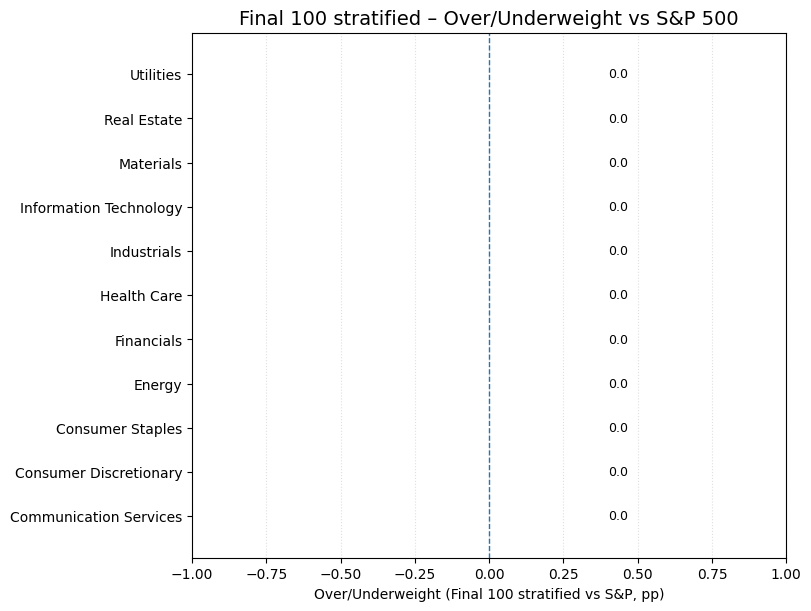

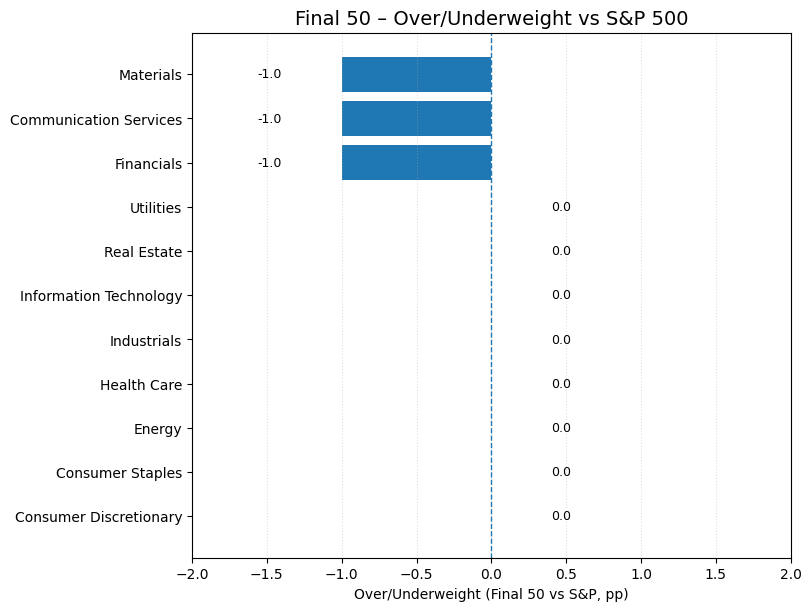

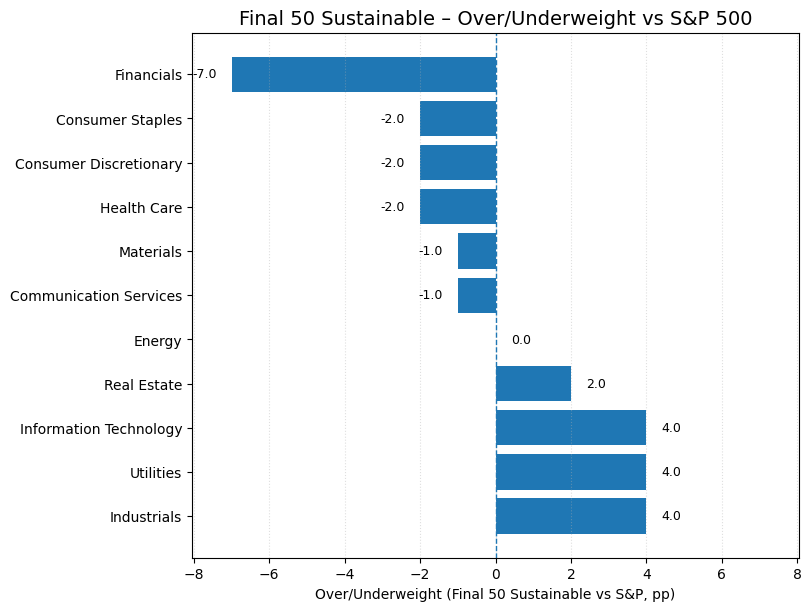

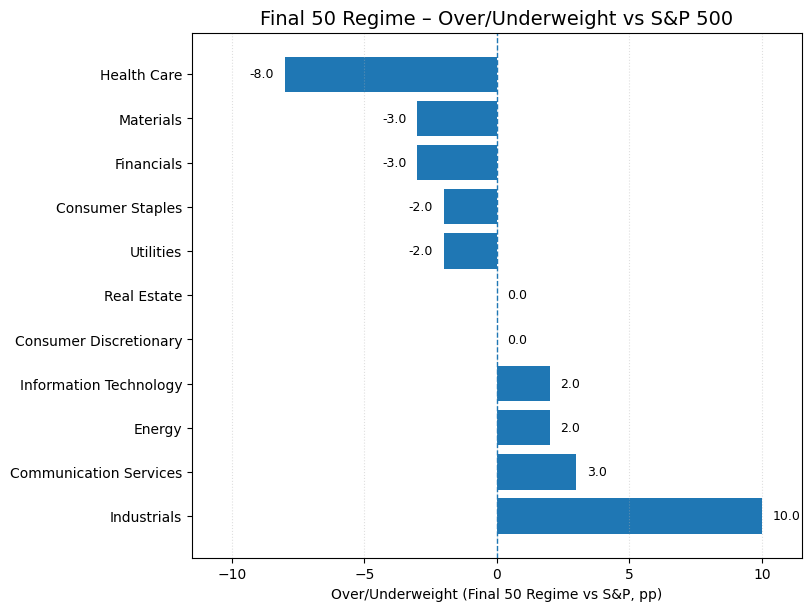

In [254]:
import matplotlib.pyplot as plt
import numpy as np

def plot_over_under(portfolio_df: pd.DataFrame, sp_df: pd.DataFrame, name: str):
    title = f"{name} – Over/Underweight vs S&P 500"
    sp = sp_df["weight"]
    pf = portfolio_df["weight"]
    sectors = sp.index.union(pf.index)

    diff_pp = (pf.reindex(sectors).fillna(0) - sp.reindex(sectors).fillna(0)) * 100.0
    diff_pp = diff_pp.sort_values(ascending=False)

    # Use constrained layout (more robust than tight_layout)
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

    bars = ax.barh(diff_pp.index, diff_pp.values)
    ax.axvline(0, linewidth=1, linestyle="--")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(f"Over/Underweight ({name} vs S&P, pp)")

    m = float(np.nanmax(np.abs(diff_pp.values))) if len(diff_pp) else 0.0
    pad = max(1.0, 0.15 * m)          # fixed minimum padding avoids identical limits
    ax.set_xlim(-m - pad, m + pad)
    ax.grid(axis="x", linestyle=":", alpha=0.4)

    for rect, val in zip(bars, diff_pp.values):
        x = rect.get_width()
        ax.text(
            x + (0.4 if x >= 0 else -0.4),  # smaller nudge so labels stay inside limits
            rect.get_y() + rect.get_height() / 2,
            f"{val:.1f}",
            va="center",
            ha="left" if x >= 0 else "right",
            fontsize=9,
            clip_on=False,
        )

    plt.show()


portfolios = {
    "Final 100 stratified": final_stratified_100_sector_weights,
    "Final 50": final_stratified_50_sector_weights,
    "Final 50 Sustainable": final_50_sustainability_sector_weights,
    "Final 50 Regime": final_50_regime_sector_weights,
}

for name, df in portfolios.items():
    plot_over_under(df, SP_sector_weights, name)

# Step 6: Portfolio Optimization
A traditional optimizer is used to generate the final portfolio. Constraints include:

- **Objective**: Maximize dividend yield
- **Beta Target**: Between 0.8 and 1.2
- **Sector Deviation**: ±5% of S&P 500 sector weights
- **Position Limits**: Max 5% per position


Run below if your runtime reset

In [255]:
import pandas as pd
stratified_50_df = pd.read_csv('stratified_50_df.csv',index_col=0)
constituents = pd.read_csv('SP_constitutents.csv',index_col=0)
returns_df = pd.read_csv('returns_df.csv',index_col=0,parse_dates=True)
metrics_df = pd.read_csv('metrics_df.csv',index_col=0)

### Install Portfolio Opt Dependencies

In [ ]:
pip install PyPortfolioOpt

### Run Portfolio Optimization

In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp
import yfinance as yf
from datetime import timedelta
from pypfopt.efficient_frontier import EfficientFrontier


# Universe & basic data
universe = stratified_50_df.index.tolist()
R = returns_df[universe].dropna(how="all").fillna(0.0)
S = R.cov()
dividend_yield = metrics_df.reindex(universe)["DividendYield"].fillna(0.0)

# Market for beta calc
start_dt = pd.to_datetime(returns_df.index[0]) - timedelta(days=1)
end_dt = pd.to_datetime(returns_df.index[-1]) + timedelta(days=1)
mkt = yf.Ticker("^GSPC").history(start=start_dt, end=end_dt)["Close"].pct_change().dropna()
mkt.index = pd.to_datetime(mkt.index, utc=True)

# Align market & asset returns by date intersection
common_idx = R.index.intersection(mkt.index)
R = R.loc[common_idx]
mkt = mkt.loc[common_idx]

# Betas
var_m = mkt.var()
betas = {t: (R[t].cov(mkt) / var_m) if var_m != 0 else 1.0 for t in universe}
beta_vec = pd.Series(betas).reindex(universe).fillna(1.0).values

# S&P sector benchmark, normalized
bench = SP_sector_weights.astype(float).copy()
bench = bench / bench.sum()

# Sector setup
sector_of = stratified_50_df["GICS Sector"].to_dict()
sectors = sorted(set(bench.index).union(stratified_50_df["GICS Sector"].unique()))
bench = bench.reindex(sectors).fillna(0.0)

sector_masks = {
    s: np.array([1.0 if sector_of[t] == s else 0.0 for t in universe], dtype=float)
    for s in sectors
}

# EF with dummy expected returns (we use custom objective)
mu_dummy = pd.Series(0.0, index=universe)
per_name_cap = 0.05
ef = EfficientFrontier(mu_dummy, S, weight_bounds=(0.01, per_name_cap))

# 
ef.add_constraint(lambda w: w @ beta_vec >= 0.8)
ef.add_constraint(lambda w: w @ beta_vec <= 1.2)

# Sector bands: lower = max(bench - 0.05, 0), upper = min(bench + 0.05, capacity, 1.0)
lower_band = 0.05
upper_band = 0.05

sum_upper = 0.0
sum_lower = 0.0

for s in sectors:
    m = sector_masks[s]
    n_s = int((m > 0).sum())
    bench_w = float(bench.loc[s]) if s in bench.index else 0.0

    if n_s == 0:
        # No investable names -> exact zero
        ef.add_constraint(lambda w, m=m: w @ m == 0.0)
        continue

    capacity = n_s * per_name_cap
    lower = max(bench_w - lower_band, 0.0)
    lower = min(lower, capacity)                 
    upper = min(bench_w + upper_band, capacity, 1.0)

    if lower > upper:  
        lower = upper

    ef.add_constraint(lambda w, m=m, lo=lower: w @ m >= lo)
    ef.add_constraint(lambda w, m=m, up=upper: w @ m <= up)

    sum_lower += lower
    sum_upper += upper

# Objective: maximize dividend yield (minimize negative) + tiny L2 regularization
y = dividend_yield.values

def negative_dividend_objective(w, y=y):
    return - (w @ y)

def l2_reg(w, gamma=1e-4):
    return gamma * cp.norm(w, 2)

ef.convex_objective(lambda w: negative_dividend_objective(w) + l2_reg(w))

# Solve and report
w = ef.clean_weights()
weights = pd.Series(w).reindex(universe)

port_beta = float(weights.values @ beta_vec)
port_yield = float(weights.values @ y)
sector_w = pd.Series({s: float(weights.values @ sector_masks[s]) for s in sectors})

out = (
    pd.DataFrame({
        "Ticker": universe,
        "Weight": [weights[t] for t in universe],
        "GICS Sector": [sector_of[t] for t in universe],
        "Dividend Yield": dividend_yield.reindex(universe).values,
        "Beta": beta_vec,
    })
    .sort_values("Weight", ascending=False)
    .query("Weight > 1e-6")
    .reset_index(drop=True)
)

print("\nTop holdings:")
print(out.head(15).to_string(index=False))
print("\nPortfolio dividend yield:", round(port_yield, 4))
print("Portfolio beta:", round(port_beta, 3))


Top holdings:
Ticker  Weight            GICS Sector  Dividend Yield     Beta
    VZ 0.05000 Communication Services            6.10 0.269147
   PRU 0.05000             Financials            4.91 1.036587
   AES 0.05000              Utilities            5.22 1.065291
   BBY 0.05000 Consumer Discretionary            5.04 1.180608
   LYB 0.05000              Materials            9.32 0.975662
   GIS 0.05000       Consumer Staples            4.86 0.090139
   CAG 0.05000       Consumer Staples            7.12 0.186996
   PFE 0.05000            Health Care            6.65 0.450165
   EXR 0.04970            Real Estate            4.54 0.798276
   FRT 0.04970            Real Estate            4.54 0.797126
   IPG 0.04950 Communication Services            4.84 0.870332
   FDX 0.03842            Industrials            2.45 0.968003
   HPQ 0.02861 Information Technology            4.17 1.157885
    ES 0.02485              Utilities            4.52 0.505861
   TGT 0.01921       Consumer Staples   

/var/folders/fg/2mkc8cs91fz_lw_yzyhr5zxr0000gn/T/ipykernel_2112/295739719.py:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bench_w = float(bench.loc[s]) if s in bench.index else 0.0


### Final Portfolio

In [158]:
out

,Ticker,Weight,GICS Sector,Dividend Yield,Beta
0,TGT,0.05000,Consumer Staples,4.53,0.920972
1,KEY,0.05000,Financials,4.32,1.394007
2,AES,0.05000,Utilities,5.22,1.065291
3,BBY,0.05000,Consumer Discretionary,5.04,1.180608
4,F,0.05000,Consumer Discretionary,5.11,1.128034
5,USB,0.05000,Financials,4.14,1.124971
6,VTRS,0.05000,Health Care,4.51,0.794914
7,SPG,0.05000,Real Estate,4.87,0.977362
8,HPQ,0.05000,Information Technology,4.17,1.157885
9,PFE,0.05000,Health Care,6.65,0.450165


In [267]:
SP_sector_weights = constituents.groupby('GICS Sector').agg(weight_SPY=('GICS Sector',lambda x: x.count()/len(constituents))).round(3)

### Final Sector Allocation

In [270]:
out.groupby('GICS Sector').agg(weight_opt_port=('GICS Sector',lambda x: x.count()/len(out))).round(3).join(SP_sector_weights.rename(columns={'weight':'weight_SPY'}))

,weight_opt_port,weight_SPY
GICS Sector,,
Communication Services,0.041,0.048
Consumer Discretionary,0.102,0.101
Consumer Staples,0.082,0.076
Energy,0.041,0.044
Financials,0.143,0.147
Health Care,0.122,0.119
Industrials,0.163,0.155
Information Technology,0.143,0.135
Materials,0.041,0.052
